In [1]:
import numpy as np
import os, sys, re
from math import *
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd

import numpy.ma as ma
import fit_beta as fb
import scipy.special as scs
import bisect

<H2>GRaDE Rijn:</H2>
<UL>
    <LI> Beta-verdelingen fitten aan de hydraulische simulaties (hydraulische onzekerheid)
    </LI>
    <LI> Onzekerheidsbanden meteo (jackknife) en hydraulica (beta-fits) combineren
    </LI>
    <LI> Uitgeintegreerde werklijn
    </LI>
</UL>

In [2]:
# Voor gumbelplotjes
def add_return_period(tretlist,ax):
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    lbl = ["%d"%int(tr) for tr in tretlist]
    pos = [-np.log(-np.log(1.-1./tr)) for tr in tretlist]
    ax2.set_xticks(pos)
    ax2.set_xticklabels(lbl, rotation='vertical')
    return ax2

def add_gum_axis(tretlist,ax):
    ax2 = add_return_period(tretlist,ax)
    grid2 = ax2.grid()
    grid1 = ax.grid()
    ylbl1 = ax.set_ylabel('Afvoer [m3 s-1]')
    xlbl1 = ax.set_xlabel('Standardised Gumbel Variate [-]')
    xlbl2 = ax2.set_xlabel('Herhalingstijd [jaar]')
    return ax2

In [3]:
# Relevante herhaaltijden
Tretlist = [10,100,1000,1250,3000,10000,50000,100000,200000,300000,400000]

In [4]:
# Lezen van Deltares TEKAL blokken en tabel-interpolatie
def readTEKAL(fnin,blklbl,**kwargs):
# Read selected TEKAL block in a list of numpy 1d-arrays
    try:
        each = int(kwargs['skip'])+1
    except:
        each = 1
    with open(fnin,"r") as fn:
        line = "."
        cnt = 0
        while line:
            line = fn.readline()
            if line.strip()==blklbl:
                nrowcol = fn.readline().split()
                nrow, ncol = int(nrowcol[0]), int(nrowcol[1])
                break
        data =[]   # list of numpy arrays
        for icol in range(ncol):
            data.append(np.array([]))
        for irow in range(nrow):
            strings = fn.readline().split()
            if cnt%each == 0:
                for icol in range(ncol):
                    data[icol] = np.append(data[icol],float(strings[icol]))
            cnt += 1
    return data

def listTEKALBlocks(fnin):
    blocks = {}
    with open(fnin,"r") as fn:
        pos = 0
        while True:
            line = fn.readline()
            pos += 1
            if not line:
                break
            if line[0] in '*#':
                continue
            lbl = line.strip()  
            blocks[lbl] = {}
            line = fn.readline()
            pos += 1
            while line[0] in '*#': 
                line = fn.readline()
                pos += 1
            nrow, ncol = [int(substr.strip()) for substr in line.split()]
            blocks[lbl]['nrow'] = nrow 
            blocks[lbl]['ncol'] = ncol
            blocks[lbl]['linenr'] = pos     # first line following the row column specification
            for i in range(nrow):
                line = fn.readline()        # skip nrow lines
                pos += 1
    return blocks

def interpolate(xx,yy,x,default=np.nan):
    if x<xx[0] or x>xx[-1]:
        return default
    for i in range(len(xx)-1):
        if (x>=xx[i] and x<=xx[i+1]):
            w=(x-xx[i])/(xx[i+1]-xx[i])
            return (1.-w)*yy[i] + w*yy[i+1]

In [202]:
import scipy.special as scs
def qfunbeta(alpha,beta,a,b,P):
    return scs.betaincinv(alpha,beta,P)*(b-a)+a

def quantilesetbeta(n,alpha,beta,a,b):
    pvalues = [(i+1.0-0.3)/(n+0.4) for i in range(n)]
    qvalues = [qfunbeta(alpha,beta,a,b,p) for p in pvalues]
    return pvalues, qvalues

def quantilesetnormal(n,mu,sigma):
    pvalues = [(i+1.0-0.3)/(n+0.4) for i in range(n)]
    qvalues = [mu+sigma*(2.**0.5)*scs.erfinv(2.*p-1.) for p in pvalues]
    return pvalues, qvalues

def pdfbeta(n,alpha,beta,a,b,bnd):
    xvalues = [bnd[0]+(bnd[1]-bnd[0])/(n-1)*i for i in range(n)]
    qvalues = [((x-a)/(b-a))**(alpha-1 )*(((b-x)/(b-a))**(beta-1))/(b-a)/scs.beta(alpha,beta)   for x in xvalues]
    return xvalues, qvalues

#define distribution function and quantile function for the Beta distribution
def beta_forward(alpha,beta,a,b,y):
    if (y<a):
        return 0.0
    elif (y>b):
        return 1.0
    else:
        return(scs.betainc(alpha,beta,(y-a)/(b-a)))

def beta_reverse(alpha,beta,a,b,p):
    return(scs.betaincinv(alpha,beta,p)*(b-a)+a)

def P_from_Beta(beta):
    return (0.5+0.5*scs.erf(beta/(2**0.5)))
def Q_from_Beta(beta):
    return (0.5+0.5*scs.erf(-beta/(2**0.5)))
def Beta_from_Q(Q):
    return(-scs.erfinv(2*Q - 1.0)*(2**0.5))
def Beta_from_P(Q):
    return(scs.erfinv(2*Q - 1.0)*(2**0.5))

def quantileplot(ensembles, results, lbl):
    q_obs = sorted(ensembles[lbl])
    n_obs = len(q_obs)
    result = results[lookup[lbl]]
    alpha = result['estimate'][0]
    beta = result['estimate'][1]
    a = result['estimate'][2]
    b = result['estimate'][3]
    pvalues, q_fit = quantilesetbeta(n_obs,alpha,beta,a,b)
    mysample = np.array(quantilesetbeta(n_obs,alpha,beta,a,b))             # exact quantiles (order statistics) for the given parameters
    plt.plot(pvalues,q_obs,'+',pvalues,q_fit,'r-')

def pdfplot_duo(ax, results_m, lbl):
    result = results_m[lbl]
    n_obs=1000
    alpha = result['estimate'][0]
    beta = result['estimate'][1]
    a = result['estimate'][2]
    b = result['estimate'][3]
    xvalues, q_pdf_m = pdfbeta(n_obs,alpha,beta,a,b)

    alpha = result['estimate2'][0]
    beta = result['estimate2'][1]
    a = result['estimate2'][2]
    b = result['estimate2'][3]
    xvalues, q_pdf_q = pdfbeta(n_obs,alpha,beta,a,b)
    ax.plot(xvalues,q_pdf_m,'r-',xvalues,q_pdf_q,'g-')        
    
def quantileplot_duo(ax, ensembles, results_m, lbl):
    q_obs = sorted(ensembles[lbl])
    n_obs = len(q_obs)
    result = results_m[lbl]
    alpha = result['estimate'][0]
    beta = result['estimate'][1]
    a = result['estimate'][2]
    b = result['estimate'][3]
    pvalues, q_fit_m = quantilesetbeta(n_obs,alpha,beta,a,b)

    alpha = result['estimate2'][0]
    beta = result['estimate2'][1]
    a = result['estimate2'][2]
    b = result['estimate2'][3]
    pvalues, q_fit_q = quantilesetbeta(n_obs,alpha,beta,a,b)
    
    mysample = np.array(quantilesetbeta(n_obs,alpha,beta,a,b))             # exact quantiles (order statistics) for the given parameters
    ax.plot(pvalues,q_obs,'b+',label="Sample")    
    ax.plot(pvalues,q_fit_m,'r-',label="Fit Moments")    
    ax.plot(pvalues,q_fit_q,'g-',label="Fit Quantile")    
    ax.set_xlabel('P-value [-]')
    ax.set_ylabel('Percentile [m3 s-1]')    
    ax.legend()
    ax.set_title("Fits, percentiles versus P-value")
    
def linfit(x,y):
    nn = ma.count(x)
    c = [(ma.sum(x*y)-ma.sum(x)*ma.sum(y)/nn)/(ma.sum(x*x)-ma.sum(x)*ma.sum(x)/nn)]
    c.append((ma.sum(y)-c[0]*ma.sum(x))/nn)
    return(c)


In [6]:
# Hulp routines voor de uitintegratie
def normal_cdf(x,parms):
    mu = parms[0]
    sigma = parms[1]
    return (1.0 + erf((x-mu) / sigma / sqrt(2.0))) / 2.0

def normal_pdf(x,parms):
    mu = parms[0]
    sigma = parms[1]
    return exp(-0.5*((x-mu)/2./sigma)**2)/(sigma*(2*pi)**0.5)

def all_distributions(distfun, parms, levels):
    distribution = []
    for level in levels:
        distribution.append(distfun(level,parms))
    dist_np=np.array(distribution)
    return dist_np

def all_densities(densfun, parms, levels):
    densities = []
    for level in levels:
        densities.append(densfun(level,parms))
    dens_np=np.array(densities)
#   dens_np = normalise(levels, dens_np)   # ASSUMPTION THAT dens_np IS NORMALISED !!
    return dens_np

def pdf2cdf(x,pdf):
    nsections = len(x) - 1              # hekjes-paaltjes probleem
    cdf = pdf*0.0
    for i in range(len(x)-1):
        cdf[i+1] = cdf[i] + (x[i+1]-x[i])*(pdf[i+1]+pdf[i])/2.
    return cdf 

def normalise(x,f):
    total = 0.0
    nsections = len(x) - 1              # hekjes-paaltjes probleem
    for i in range(nsections):          # i runs from o through nsections -1 (zero-based index)
        total += (x[i+1]-x[i])*(f[i+1]+f[i])/2.
    f = f / (total/(1.-1./nsections))
    return (f,total)

def outintegrate_equ(parms, levels, distfun):
    # based on a sample average
    # this works if we have an evenly distributed sample (in terms of reference q) in parms
    # each record in parms consists of a tuple of parameters
    # does not have to be ordered
    nx = len(parms['distpar'])
    nl = len(levels)
    cdf = np.array([0.0]*nl)
#   for i in range(nx):
    for i in tqdm(list(range(nx))):
        distribution = all_distributions(distfun, parms['distpar'][i], levels)
        cdf += distribution
    cdf /= nx
    return cdf

def outintegrate(parms, levels, distfun):
    # based on a numerical integral over q probabilities
    # this works if we have an ordered set (in terms of reference q) in parms, each with its non-exceedance probability
    # each record in parms consists of a tuple of parameters AND an associated non-exceedance probability
    # has to be ordered on reference Q (that also means ordered by non-exceedance probability) 
    nx = len(parms['F'])
    nl = len(levels)
    cdf = np.array([0.0]*nl)
    H = parms['F']
    wtsum = 0.0
#   for i in range(nx):
    for i in tqdm(list(range(nx))):
        if i==0:
            wt = 0.5*(H[0]+H[1])
        elif i==nx-1:
            wt = 1.-0.5*(H[nx-1]+H[nx-2])
        else:
            wt = 0.5*(H[i+1]-H[i-1])
        wtsum = wtsum + wt
        distribution = all_distributions(distfun, parms['distpar'][i], levels)
        cdf += distribution * wt
    return cdf

In [7]:
# Lees oude werklijn
column_Tret  = 8
column_Qref  = 9
column_Sigma = 10

with open('./oude_getallen.csv',"r") as fnin:
    sgv_list = []
    mu_list = []
    sigma_list = []
    while True:
        line = fnin.readline()
        if not line:
            break
        if line[0] in '#*':
            continue
        columns = line.strip().split(';')
        Tret = float(columns[column_Tret-1])
        mu_value = float(columns[column_Qref-1])
        sigma_value = float(columns[column_Sigma-1])
        sgv_list.append(-np.log(-np.log(1.-1./Tret)))
        mu_list.append(mu_value)
        sigma_list.append(sigma_value)
nx_old = len(sgv_list)        
np_sgv_old = np.array(sgv_list)        
np_qref_old = np.array(mu_list)
np_sigma_old = np.array(sigma_list)
rijn_old={'sgv':np.array(sgv_list),'mu':np.array(mu_list),'sigma':np.array(sigma_list)}

In [8]:
# Lees de referentie werklijn voor de Rijn (2021)
with open('GRADE_RHINE_2021_REF_SBK3_GW.csv',"r") as fnin:
    qref = []
    minimum = 1000000.
    while True:
        line = fnin.readline()
        if not line:
            break
        syear, sqvalue = line.strip().split(',')
        year = int(syear)
        qvalue = float(sqvalue)
        bisect.insort(qref,qvalue)
nx = len(qref)
np_qref = np.array(qref)
np_sgv = -np.log(-np.log((np.array(list(range(nx)))+1.-0.3)/(nx+0.4)))


In [9]:
# Lees TEKAL file met Meteo onzekerheden
listTEKALBlocks("Final_FreqCurve_Rhine_HBV.tek")
# Lees TEKAL file (Henk vd Boogaard, met HBV onzekerheden)
UncMeteo = readTEKAL('Final_FreqCurve_Rhine_HBV.tek','BL01',skip=99)
tbl_mu_Meteo = UncMeteo[3]
tbl_sigma_Meteo = UncMeteo[5]

In [10]:
# Voeg de geinterpoleerde sigma's toe als onzekerheid
sigma_Meteo = []
for i in tqdm(list(range(np_qref.size))):
    sigma_Meteo.append(interpolate(tbl_mu_Meteo,tbl_sigma_Meteo,np_qref[i],default=10))
np_sigma_Meteo = np.array(sigma_Meteo)

rijn_new={'sgv':np_sgv,'mu':np_qref,'sigma':np_sigma_Meteo}
# rijn_new['sigma'] = (SBKmaas_new['sigma']**2.+ np_sigma_HBV**2.)**0.5   # Onzekerheden nog combineren

In [11]:
# Lees de observaties(blokmaxima, toestand 2004)
with open("Lobith_HR2006_AM.csv","r") as fnin:
    qhis = []
    while True:
        line = fnin.readline()
        if not line:
            break
        try:
            ss = line.split(';')
            year = int(ss[0])
            qmax_1977 = float(ss[1])
            qmax_2004 = float(ss[2])
            bisect.insort(qhis,qmax_2004)
        except:
            pass
nxhis = len(qhis)
rijn_obs = {}
rijn_obs['sgv'] = -np.log(-np.log((np.array(list(range(nxhis)))+1.-0.3)/(nxhis+0.4)))
rijn_obs['mu'] = np.array(qhis)

(0, 20000)

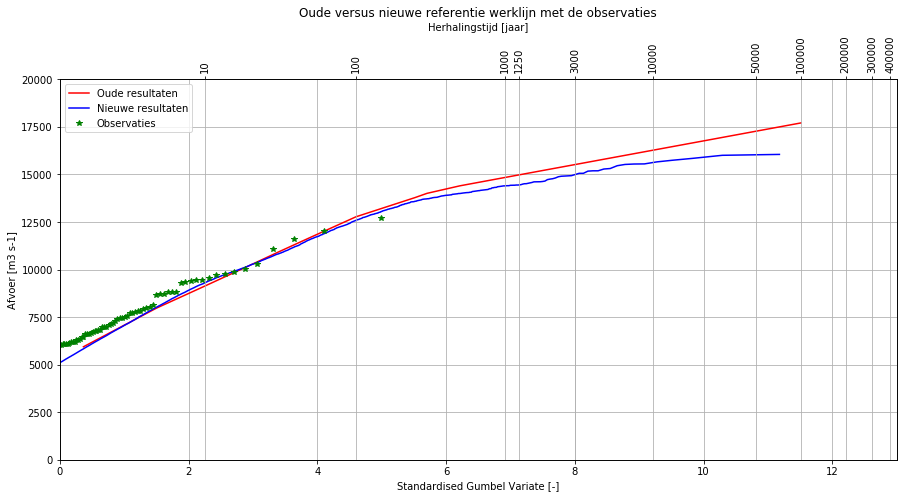

In [12]:
#plot oud versus observations

plt.plot(rijn_old['sgv'],rijn_old['mu'],'r-',label="Oude resultaten")
plt.plot(rijn_new['sgv'],rijn_new['mu'],'b-',label="Nieuwe resultaten")
plt.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observaties")
ax=plt.gca()
ax.set_xlim(0,13)
fig=plt.gcf()
fig.set_size_inches(15,7)
lgnd = ax.legend(loc="upper left")
ax2 = add_gum_axis(Tretlist,ax)
ti=ax.set_title('Oude versus nieuwe referentie werklijn met de observaties')
ax.set_ylim(0,20000)

(0, 20000)

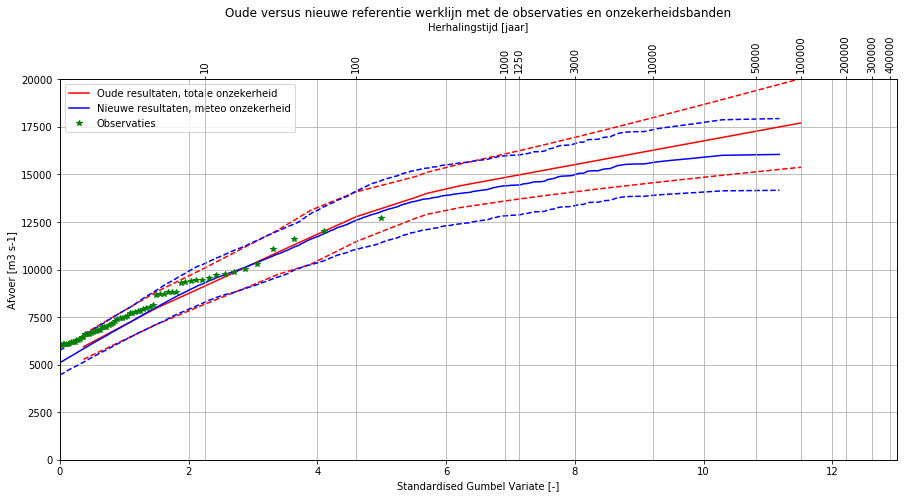

In [13]:
#plot oud versus observations
plt.plot(rijn_old['sgv'],rijn_old['mu'],'r-',label="Oude resultaten, totale onzekerheid")
plt.plot(rijn_old['sgv'],rijn_old['mu']+1.96*rijn_old['sigma'],'r--')
plt.plot(rijn_old['sgv'],rijn_old['mu']-1.96*rijn_old['sigma'],'r--')
plt.plot(rijn_new['sgv'],rijn_new['mu'],'b-',label="Nieuwe resultaten, meteo onzekerheid")
plt.plot(rijn_new['sgv'],rijn_new['mu']+1.96*rijn_new['sigma'],'b--')
plt.plot(rijn_new['sgv'],rijn_new['mu']-1.96*rijn_new['sigma'],'b--')
plt.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observaties")

ax=plt.gca()
ax.set_xlim(0,13)
fig=plt.gcf()
fig.set_size_inches(15,7)
lgnd = ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax)
ti=ax.set_title('Oude versus nieuwe referentie werklijn met de observaties en onzekerheidsbanden')
ax.set_ylim(0,20000)

In [14]:
# Voer een uitintegratie uit voor de oude resultaten
nx_old = len(rijn_old['sgv'])
rijn_old['uitintegratie']={}
rijn_parms = {'distpar':[(rijn_old['mu'][i] ,rijn_old['sigma'][i]) for i in range(nx_old)],
              'F':np.exp(-np.exp(-rijn_old['sgv']))}
rijn_old['uitintegratie']['levels'] = np.array(list(range(5000,20000,100)))
rijn_cdf = outintegrate(rijn_parms, rijn_old['uitintegratie']['levels'], normal_cdf)
rijn_old['uitintegratie']['sgv'] = -np.log(-np.log(rijn_cdf))

In [15]:
# Voer een uitintegratie uit voor de nieuwe resultaten
nx_new = len(rijn_new['sgv'])
rijn_new['uitintegratie']={}
rijn_parms = {'distpar':[(rijn_new['mu'][i] ,rijn_new['sigma'][i]) for i in range(nx_new)],
              'F':np.exp(-np.exp(-rijn_new['sgv']))}
rijn_new['uitintegratie']['levels'] = np.array(list(range(5000,20000,100)))
rijn_cdf = outintegrate(rijn_parms, rijn_new['uitintegratie']['levels'], normal_cdf)
rijn_new['uitintegratie']['sgv'] = -np.log(-np.log(rijn_cdf))

(0, 20000)

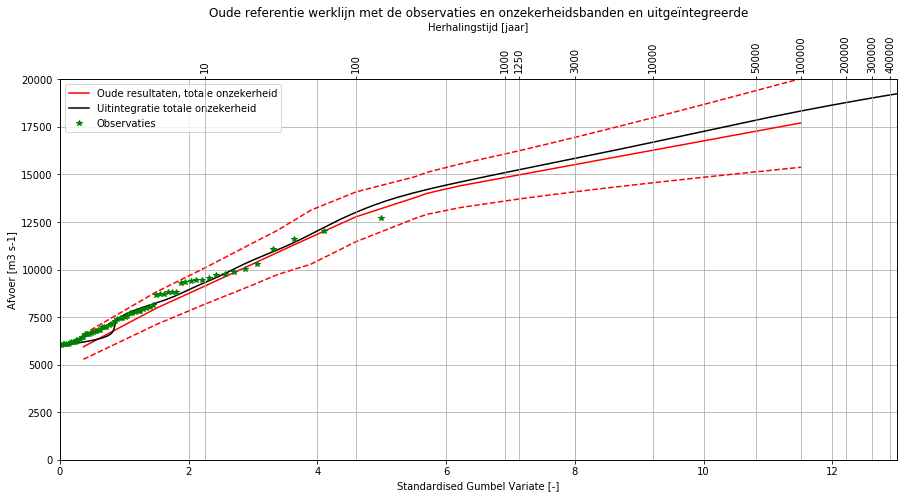

In [16]:
#plot oud versus observations met 
plt.plot(rijn_old['sgv'],rijn_old['mu'],'r-',label="Oude resultaten, totale onzekerheid")
plt.plot(rijn_old['sgv'],rijn_old['mu']+1.96*rijn_old['sigma'],'r--')
plt.plot(rijn_old['sgv'],rijn_old['mu']-1.96*rijn_old['sigma'],'r--')
plt.plot(rijn_old['uitintegratie']['sgv'],rijn_old['uitintegratie']['levels'],'k-',label="Uitintegratie totale onzekerheid")
plt.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observaties")

ax=plt.gca()
ax.set_xlim(0,13)
fig=plt.gcf()
fig.set_size_inches(15,7)
lgnd = ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax)
ti=ax.set_title('Oude referentie werklijn met de observaties en onzekerheidsbanden en uitgeïntegreerde')
ax.set_ylim(0,20000)

(0, 20000)

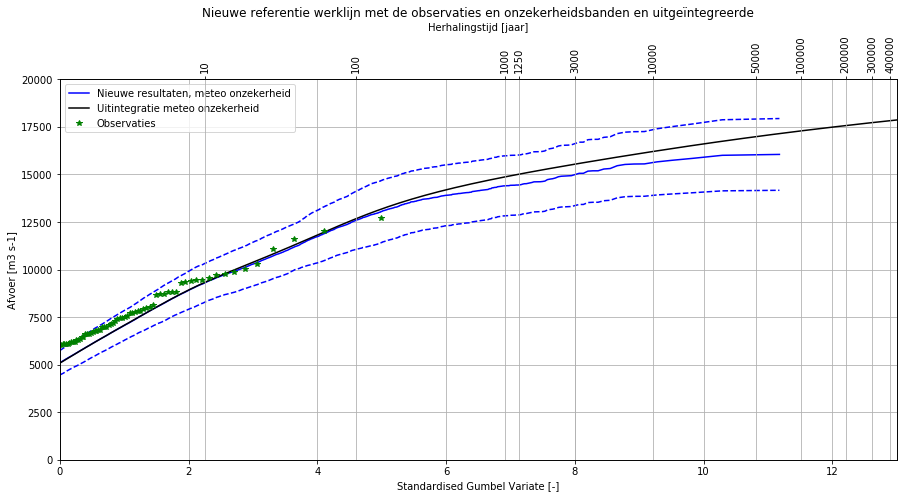

In [17]:
#plot nieuw versus observations met 
plt.plot(rijn_new['sgv'],rijn_new['mu'],'b-',label="Nieuwe resultaten, meteo onzekerheid")
plt.plot(rijn_new['sgv'],rijn_new['mu']+1.96*rijn_new['sigma'],'b--')
plt.plot(rijn_new['sgv'],rijn_new['mu']-1.96*rijn_new['sigma'],'b--')
plt.plot(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],'k-',label="Uitintegratie meteo onzekerheid")
plt.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observaties")

ax=plt.gca()
ax.set_xlim(0,13)
fig=plt.gcf()
fig.set_size_inches(15,7)
lgnd = ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax)
ti=ax.set_title('Nieuwe referentie werklijn met de observaties en onzekerheidsbanden en uitgeïntegreerde')
ax.set_ylim(0,20000)

(0, 20000)

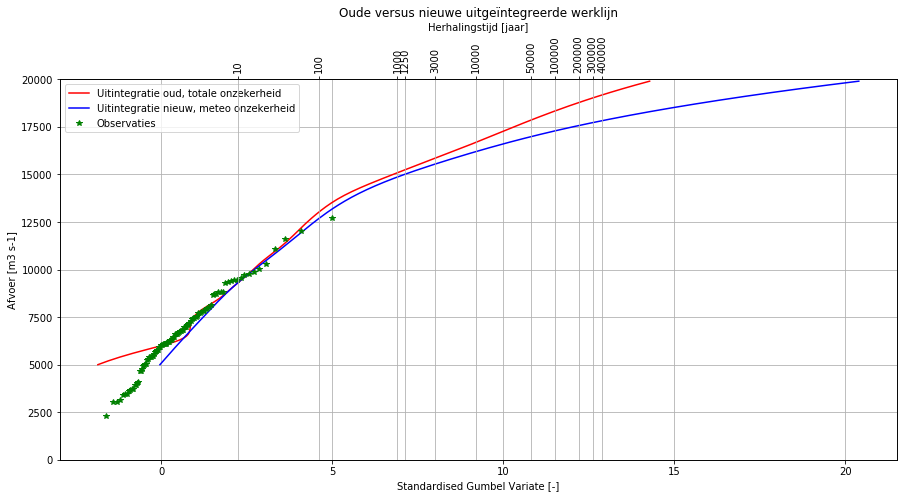

In [18]:
#plot oud en nieuw uitgeïntegreerd versus observations
plt.plot(rijn_old['uitintegratie']['sgv'],rijn_old['uitintegratie']['levels'],'r-',label="Uitintegratie oud, totale onzekerheid")
plt.plot(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],'b-',label="Uitintegratie nieuw, meteo onzekerheid")
plt.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observaties")

ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(15,7)
lgnd = ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax)
ti=ax.set_title('Oude versus nieuwe uitgeïntegreerde werklijn')
ax.set_ylim(0,20000)

In [19]:
table = {'Herhaaltijd':Tretlist}
qmax_old = []
sigma_old = []
uit_old = []
qmax_new = []
sigma_new = []
uit_new = [] 
table={'Herhaaltijd':Tretlist}
for tr in Tretlist:
    qmax_old.append(interpolate(rijn_old['sgv'],rijn_old['mu'],-np.log(-np.log(1.-1./tr)),default=np.nan))
    sigma_old.append(interpolate(rijn_old['sgv'],rijn_old['sigma'],-np.log(-np.log(1.-1./tr)),default=np.nan))
    uit_old.append(interpolate(rijn_old['uitintegratie']['sgv'],rijn_old['uitintegratie']['levels'],-np.log(-np.log(1.-1./tr)),default=np.nan))
    qmax_new.append(interpolate(rijn_new['sgv'],rijn_new['mu'],-np.log(-np.log(1.-1./tr)),default=np.nan))
    sigma_new.append(interpolate(rijn_new['sgv'],rijn_new['sigma'],-np.log(-np.log(1.-1./tr)),default=np.nan))
    uit_new.append(interpolate(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],-np.log(-np.log(1.-1./tr)),default=np.nan))
table['Qmax oud']=qmax_old
table['Sigma oud']=sigma_old
table['Uitgeïntegreerd oud']=np.round(np.array(uit_old)*100)/100.
table['Qmax nieuw']=np.round(np.array(qmax_new)*100)/100.
table['Sigma nieuw']=sigma_new
table['Uitgeïntegreerd nieuw']=np.round(np.array(uit_new)*100)/100.
pd.DataFrame(table)


,Herhaaltijd,Qmax oud,Sigma oud,Uitgeïntegreerd oud,Qmax nieuw,Sigma nieuw,Uitgeïntegreerd nieuw
0,10,9129.0,486.0,9313.40,9301.00,519.576911,9323.82
1,100,12773.0,667.0,13007.38,12593.06,780.668366,12672.11
2,1000,14835.0,630.0,15089.74,14397.00,804.412619,14864.70
3,1250,14974.0,647.0,15244.76,14446.18,803.032693,15011.21
4,3000,15520.0,731.0,15845.76,14996.98,831.304985,15542.25
5,10000,16271.0,872.0,16691.80,15623.98,880.636204,16203.90
6,50000,17275.0,1090.0,17860.94,16032.11,958.500266,16987.84
7,100000,17707.0,1189.0,18333.87,NaN,NaN,17287.71
8,200000,NaN,NaN,18774.07,NaN,NaN,17566.13
9,300000,NaN,NaN,19015.91,NaN,NaN,17720.20


In [20]:
# Load ensembles into dictionaries
# Read the file into a dictionary, labelled by event->timeseries
datafile = 'read_Qmax_sums_results.csv'
sep = ';'
with open(datafile,"r") as fnin:
    line = fnin.readline().strip()
    colnames = re.sub(r'[^\x00-\x7F]','', line).split(sep)
    ensembles = { colname:[] for colname in colnames}
    while line:
        line = fnin.readline()
        linesplit = line.strip().split(sep)
        for i in range(len(linesplit)):
            if linesplit[i]:
                try:
                    ensembles[colnames[i]].append(float(linesplit[i].replace(',','.')))
                except:
                    ensembles[colnames[i]].append(linesplit[i])

# Select realizations from ensembles:
first_realization = 0
last_realization = 100
refnr = 113

label2nr = {}
rownames = ensembles['Scenario']
for i in range(len(rownames)):
    label2nr[rownames[i]] = i
selected = ['Sum%d'%dd for dd in range (first_realization,last_realization+1)]    # selected labels for realizations
selnr = [label2nr[rowname] for rowname in selected]

# Determine min, max, alpha, beta for each ensemble
irow_ref = label2nr['Sum%d'%refnr]
results_m = {}
for icol in range(1,len(colnames)): 
    standard=ensembles[colnames[icol]][irow_ref]
    sample=np.array([ensembles[colnames[icol]][i] for i in selnr])
    est,var = fb.fitBetaMomentsJack(sample)
    results_m[colnames[icol]]={'estimate': est, 'variance':var, 'standard': standard}
    
a = np.array([])
b = np.array([])
alpha = np.array([])
beta = np.array([])
std = np.array([])

a_2se = np.array([])
b_2se = np.array([])
alpha_2se = np.array([])
beta_2se = np.array([])

lbl = []
for label in results_m.keys():
    std = np.append(std,results_m[label]['standard'])
    alpha = np.append(alpha,results_m[label]['estimate'][2])
    beta = np.append(beta,results_m[label]['estimate'][3])
    a = np.append(a,results_m[label]['estimate'][0])
    b = np.append(b,results_m[label]['estimate'][1])
    alpha_2se = np.append(alpha,results_m[label]['variance'][2])
    beta_2se = np.append(beta,results_m[label]['variance'][3])
    a_2se = np.append(a,results_m[label]['variance'][0])
    b_2se = np.append(b,results_m[label]['variance'][1])
    lbl.append(label)

sys.stdout.write("%11s    %8s %8s       %8s    %8s    %s\n"%('Ref','alpha','beta','A', 'B', 'Label'))
for i in range(len(lbl)):
    sys.stdout.write("%8.5f    %8.5f %8.5f    %8.5f %8.5f    %s\n"%(std[i],a[i],b[i],alpha[i],beta[i],lbl[i]))    

        Ref       alpha     beta              A           B    Label
17553.90820     3.71201  2.09194    13615.14343 19462.67328    b24000
14902.15723     2.62803  1.50101    13412.81502 15745.20368    maxQ_14199_maxV_28.8_year_3345
15286.16699     1.77462  1.56257    13709.32447 16841.72014    maxQ_14210_maxV_18.1_year_2288
13351.64551     2.03466  1.06650    11795.17034 14115.33281    maxQ_14256_maxV_11.5_year_3236
14307.43555     1.61699  1.45716    12767.70517 15810.41097    maxQ_14434_maxV_14.1_year_3126
14193.20605     1.33763  1.48444    13180.73558 15434.22470    maxQ_14450_maxV_23.4_year_3048
14482.79395     1.45828  1.46577    13095.98703 15817.19115    maxQ_14567_maxV_18.9_year_7445
15096.23535     1.54703  1.60232    13823.27269 16404.51866    maxQ_14594_maxV_23.3_year_9987
14179.44336     1.64708  1.55112    12614.64039 15610.31952    maxQ_14756_maxV_14.5_year_7191
14396.85254     2.01663  2.02840    13369.75899 15641.03664    maxQ_14808_maxV_23.1_year_9093
14611.16504    

In [21]:
parameterlist =  ({rec['standard']:{'estimate': rec['estimate'], 'variance': rec['variance']} for key,rec in results_m.items()})
reference = sorted(parameterlist.keys())
alpha1 = np.array([parameterlist[ref]['estimate'][0] for ref in reference])     
beta1 = np.array([parameterlist[ref]['estimate'][1] for ref in reference])     
a1 = np.array([parameterlist[ref]['estimate'][2] for ref in reference])     
b1 = np.array([parameterlist[ref]['estimate'][3] for ref in reference])     

In [22]:
qref=np.array(reference)

# logarithmic fits on the location parameters of the Beta distribution A and B
q0 = 3000
clog_a1 = linfit(qref-q0,np.log(qref-a1))
clog_b1 = linfit(qref-q0,np.log(b1-qref))

# linear fits on the shape parameters alpha and beta
c_alpha1 = linfit(qref,alpha1)
c_beta1 = linfit(qref,beta1)

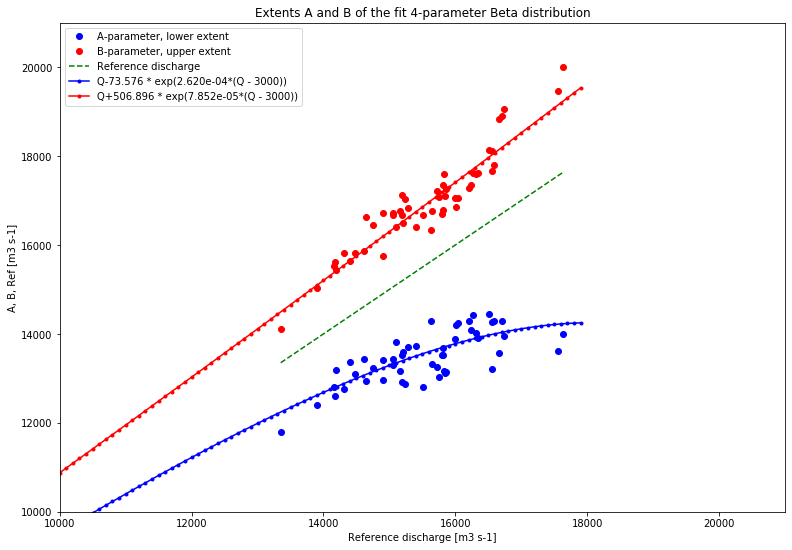

In [23]:
plt.plot(qref,a1,'bo',label='A-parameter, lower extent')
fig = plt.gcf()
ax=plt.gca()
ax.set_ylim([10000,21000])
ax.plot(qref,b1,'ro',label='B-parameter, upper extent')
ax.plot(qref,qref,'g--',label='Reference discharge')
ax.set_xlim([10000,21000])

#logarithmic fits
qs=np.array(list(range(3000,18000,100)))
ax.plot(qs,qs-np.exp(clog_a1[0]*(qs-q0)+clog_a1[1]),'b.-',label="Q-%.3f * exp(%.3e*(Q - %.0f))"%(np.exp(clog_a1[1]),clog_a1[0],q0))
ax.plot(qs,qs+np.exp(clog_b1[0]*(qs-q0)+clog_b1[1]),'r.-',label="Q+%.3f * exp(%.3e*(Q - %.0f))"%(np.exp(clog_b1[1]),clog_b1[0],q0))

fig.set_size_inches(13,9)
ax.set_xlabel('Reference discharge [m3 s-1]')
ax.set_ylabel('A, B, Ref [m3 s-1]')
ax.set_title('Extents A and B of the fit 4-parameter Beta distribution')
lgnd = ax.legend()

$$
A(q_r)\,=\,q_r\,-\,C_{A1}\exp\left(C_{A2}(q_r-q_0)\right)\\ \,\\ 
B(q_r)\,=\,q_r\,+\,C_{B1}\exp\left(C_{B2}(q_r-q_0)\right)\\ \,\\
\alpha(q_r)\,=\,\max\left(1,C_{\alpha 1}\,+\,C_{\alpha 2}q_r\right)\\ \,\\
\beta(q_r)\,=\,\max\left(1,C_{\beta 1}\,+\,C_{\beta 2}q_r\right) 
$$

In [24]:
# Pas de gefitte functionele relatie van (alpha,beta,a,b) toe op de afvoeren uit de uitgeintegreerde werklijn
# linear alpha and beta, limited below by a value of 1
np_alpha = np.array([max(1.0,c_alpha1[0]*q+c_alpha1[1]) for q in rijn_new['uitintegratie']['levels']])
np_beta = np.array([max(1.0,c_beta1[0]*q+c_beta1[1]) for q in rijn_new['uitintegratie']['levels']])

# logarithmic A an B
np_A = np.array([q-np.exp(clog_a1[0]*(q-q0)+clog_a1[1]) for q in rijn_new['uitintegratie']['levels']])
np_B = np.array([q+np.exp(clog_b1[0]*(q-q0)+clog_b1[1]) for q in rijn_new['uitintegratie']['levels']])

rijn_new['uitintegratie']['beta-parameters'] = []
for i in range(len(np_A)):
    rijn_new['uitintegratie']['beta-parameters'].append((np_alpha[i],np_beta[i],np_A[i],np_B[i]))
# upper 97.5 percentile and sigma based on the beta parameters
#np_upper = np.array([qfunbeta(np_alpha[i],np_beta[i],np_A[i],np_B[i],0.975) for i in range(nx)])
#np_lower = np.array([qfunbeta(np_alpha[i],np_beta[i],np_A[i],np_B[i],0.025) for i in range(nx)])
#np_sigma_beta = ((np_alpha*np_beta)/(np_alpha+np_beta)**2./(np_alpha+np_beta+1.))**0.5 * (np_B-np_A)

(0, 20000)

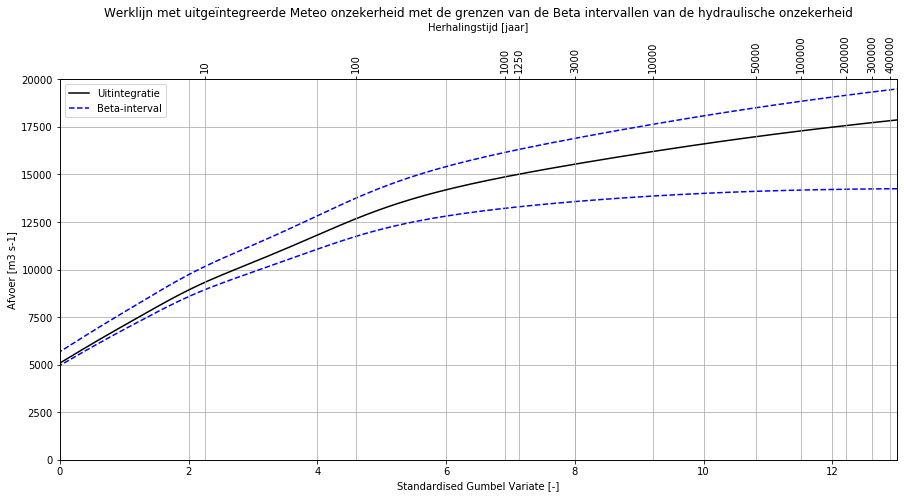

In [25]:
#plot uitgeintegreerde werklijn (Meteo onzekerheid) met de beta intervallen 
plt.plot(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],'k-',label="Uitintegratie")
plt.plot(rijn_new['uitintegratie']['sgv'],np_A,'b--',label="Beta-interval")
plt.plot(rijn_new['uitintegratie']['sgv'],np_B,'b--')
#plt.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observaties")

ax=plt.gca()
ax.set_xlim(0,13)
fig=plt.gcf()
fig.set_size_inches(15,7)
lgnd = ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax)
ti=ax.set_title('Werklijn met uitgeïntegreerde Meteo onzekerheid met de grenzen van de Beta intervallen van de hydraulische onzekerheid')
ax.set_ylim(0,20000)

In [26]:
# OutIntegration for the new numbers with the beta distribution
def cdfbeta(y,parms):
    return beta_forward(parms[0],parms[1],parms[2],parms[3],y)

rijn_parms_new = {}
rijn_parms_new['F'] = np.exp(-np.exp(-rijn_new['uitintegratie']['sgv']))
rijn_parms_new['distpar'] = rijn_new['uitintegratie']['beta-parameters'] 
rijn_levels_new = np.array(list(range(6000,21000,100)))
rijn_cdf_new = outintegrate(rijn_parms_new, rijn_new['uitintegratie']['levels'] , cdfbeta)
rijn_new['uitintegratie']['sgv2'] = -np.log(-np.log(rijn_cdf_new))

(0, 20000)

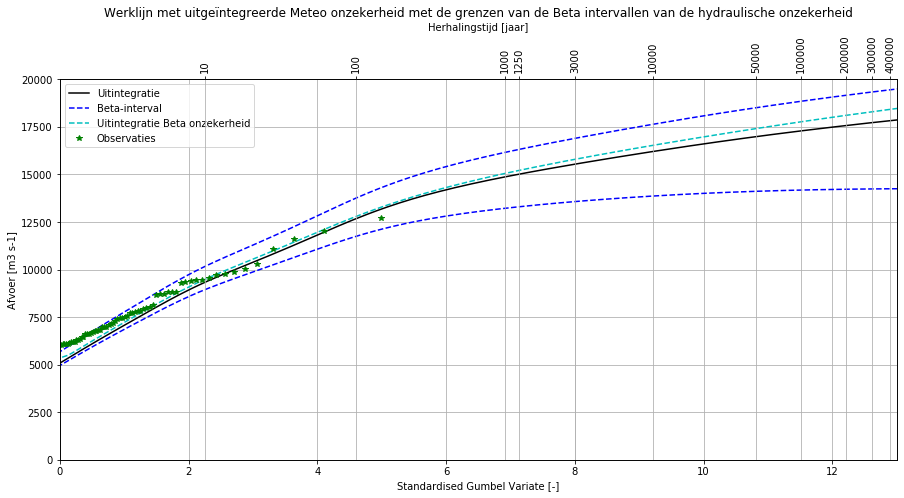

In [27]:
#plot uitgeintegreerde werklijn (Meteo onzekerheid) met de beta intervallen 
plt.plot(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],'k-',label="Uitintegratie")
plt.plot(rijn_new['uitintegratie']['sgv'],np_A,'b--',label="Beta-interval")
plt.plot(rijn_new['uitintegratie']['sgv'],np_B,'b--')
plt.plot(rijn_new['uitintegratie']['sgv2'],rijn_new['uitintegratie']['levels'],'c--',label="Uitintegratie Beta onzekerheid")
plt.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observaties")

ax=plt.gca()
ax.set_xlim(0,13)
fig=plt.gcf()
fig.set_size_inches(15,7)
lgnd = ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax)
ti=ax.set_title('Werklijn met uitgeïntegreerde Meteo onzekerheid met de grenzen van de Beta intervallen van de hydraulische onzekerheid')
ax.set_ylim(0,20000)

(0, 20000)

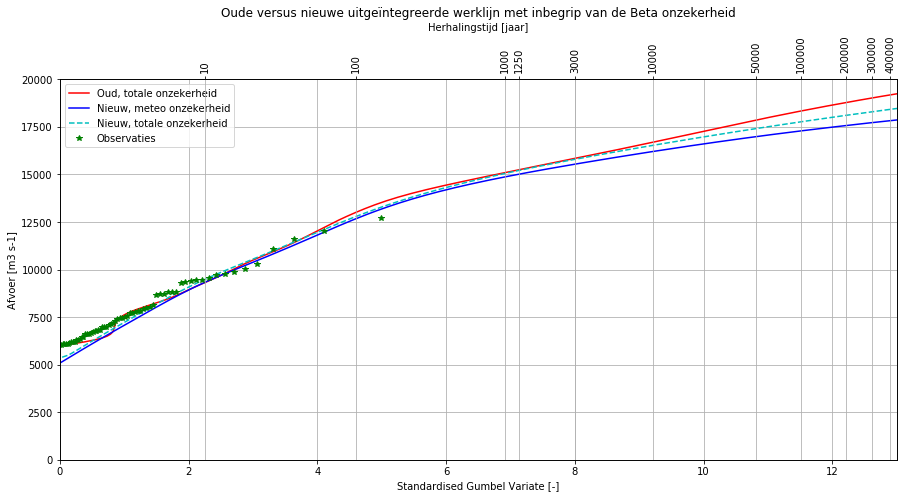

In [28]:
#plot oud en nieuw uitgeïntegreerd versus observations
plt.plot(rijn_old['uitintegratie']['sgv'],rijn_old['uitintegratie']['levels'],'r-',label="Oud, totale onzekerheid")
plt.plot(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],'b-',label="Nieuw, meteo onzekerheid")
plt.plot(rijn_new['uitintegratie']['sgv2'],rijn_new['uitintegratie']['levels'],'c--',label="Nieuw, totale onzekerheid")
plt.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observaties")

ax=plt.gca()
ax.set_xlim(0,13)
fig=plt.gcf()
fig.set_size_inches(15,7)
lgnd = ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax)
ti=ax.set_title('Oude versus nieuwe uitgeïntegreerde werklijn met inbegrip van de Beta onzekerheid')
ax.set_ylim(0,20000)

In [29]:
table = {'Herhaaltijd':Tretlist}
qmax_old = []
sigma_old = []
uit_old = []
qmax_new = []
sigma_new = []
uit_new = [] 
uit_new_beta = [] 
table={'Herhaaltijd':Tretlist}
for tr in Tretlist:
    qmax_old.append(interpolate(rijn_old['sgv'],rijn_old['mu'],-np.log(-np.log(1.-1./tr)),default=np.nan))
    sigma_old.append(interpolate(rijn_old['sgv'],rijn_old['sigma'],-np.log(-np.log(1.-1./tr)),default=np.nan))
    uit_old.append(interpolate(rijn_old['uitintegratie']['sgv'],rijn_old['uitintegratie']['levels'],-np.log(-np.log(1.-1./tr)),default=np.nan))
    qmax_new.append(interpolate(rijn_new['sgv'],rijn_new['mu'],-np.log(-np.log(1.-1./tr)),default=np.nan))
    sigma_new.append(interpolate(rijn_new['sgv'],rijn_new['sigma'],-np.log(-np.log(1.-1./tr)),default=np.nan))
    uit_new.append(interpolate(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],-np.log(-np.log(1.-1./tr)),default=np.nan))
    uit_new_beta.append(interpolate(rijn_new['uitintegratie']['sgv2'],rijn_new['uitintegratie']['levels'],-np.log(-np.log(1.-1./tr)),default=np.nan))
table['Qmax oud']=qmax_old
table['Sigma oud']=sigma_old
table['Uitgeïntegreerd oud']=uit_old
table['Qmax nieuw']=qmax_new
table['Sigma nieuw']=sigma_new
table['Uitgeïntegreerd nieuw']=uit_new
table['Uitgeïntegreerd nieuw Beta']=uit_new_beta
pd.DataFrame(table)


,Herhaaltijd,Qmax oud,Sigma oud,Uitgeïntegreerd oud,Qmax nieuw,Sigma nieuw,Uitgeïntegreerd nieuw,Uitgeïntegreerd nieuw Beta
0,10,9129.0,486.0,9313.404629,9301.000000,519.576911,9323.822286,9479.959019
1,100,12773.0,667.0,13007.380032,12593.057357,780.668366,12672.111223,12789.715230
2,1000,14835.0,630.0,15089.742129,14397.000000,804.412619,14864.700363,15046.418836
3,1250,14974.0,647.0,15244.757216,14446.177529,803.032693,15011.214519,15208.933434
4,3000,15520.0,731.0,15845.760775,14996.978052,831.304985,15542.250540,15798.490173
5,10000,16271.0,872.0,16691.798067,15623.984375,880.636204,16203.896678,16527.088614
6,50000,17275.0,1090.0,17860.942692,16032.105680,958.500266,16987.839983,17412.183790
7,100000,17707.0,1189.0,18333.867978,NaN,NaN,17287.713430,17765.954744
8,200000,NaN,NaN,18774.071166,NaN,NaN,17566.130860,18102.334916
9,300000,NaN,NaN,19015.914849,NaN,NaN,17720.198659,18290.361301


(0, 20000)

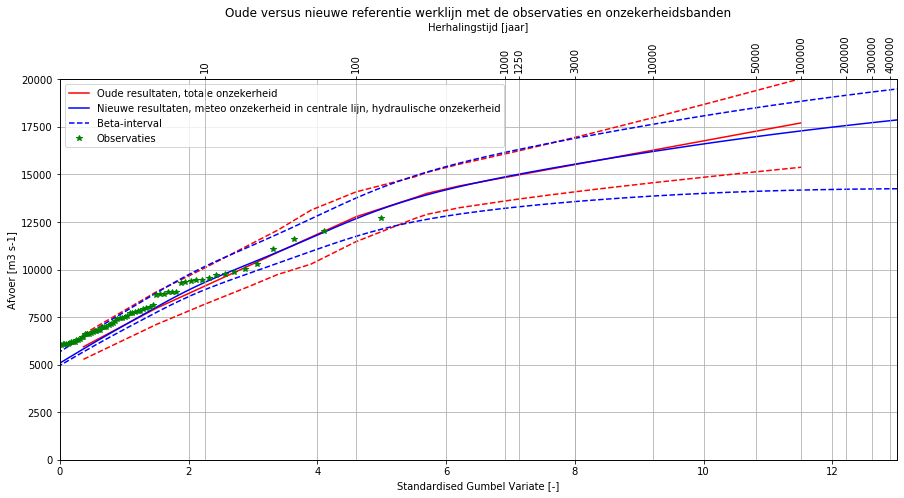

In [30]:
#plot oud versus observations
plt.plot(rijn_old['sgv'],rijn_old['mu'],'r-',label="Oude resultaten, totale onzekerheid")
plt.plot(rijn_old['sgv'],rijn_old['mu']+1.96*rijn_old['sigma'],'r--')
plt.plot(rijn_old['sgv'],rijn_old['mu']-1.96*rijn_old['sigma'],'r--')

plt.plot(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],'b-',label="Nieuwe resultaten, meteo onzekerheid in centrale lijn, hydraulische onzekerheid")
plt.plot(rijn_new['uitintegratie']['sgv'],np_A,'b--',label="Beta-interval")
plt.plot(rijn_new['uitintegratie']['sgv'],np_B,'b--')

plt.plot(rijn_obs['sgv'],rijn_obs['mu'],'g*',label="Observaties")

ax=plt.gca()
ax.set_xlim(0,13)
fig=plt.gcf()
fig.set_size_inches(15,7)
lgnd = ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax)
ti=ax.set_title('Oude versus nieuwe referentie werklijn met de observaties en onzekerheidsbanden')
ax.set_ylim(0,20000)

In [31]:
# Combi meteo (normaal) en hydraulische onzekerheid (beta-verdeling) door samplen en opnieuw Beta fitten
# q_Meteo gesampled uit de bovenstaande onzwekerheidsband voor de meteo
# q_Hydraulica gesampled uit een beta-verdeling met verwachting 0
# gesommeerd
# Beta verdeling gefit

def CombiNormalAndBeta(betaparameters,normalparameters,nx):
    alpha = betaparameters[0]
    beta = betaparameters[1]
    AA = betaparameters[2]
    BB = betaparameters[3]
#   DD = sigma0*(alpha+beta)*((alpha+beta+1)/(alpha*beta))**0.5     # DD for s given sigma
    DD = BB - AA                                                    # Keep the same interval
    AA = -alpha*DD/(alpha+beta)                                     # Zero mean
    BB = beta*DD/(alpha+beta)
    
    mu = normalparameters[0]
    sigma = normalparameters[1]

    betas=np.random.beta(alpha,beta,nx)*DD+AA
    normals=np.random.normal(mu,sigma,nx)
    sums=betas+normals
    est2 = fb.fitBetaQuantiles(sums)
    return est2

<h3>Regressie HBV-to-SOBEK Rijn</h3>
Uit regressie is een relatie bepaald uit de HBV-(piek)afvoeren $Q_h$ en de bijbehorende Sobek (piek)afvoeren $Q_s$ als volgt (Henk vd Boogaard, <tt>regression_2018</tt>):
    $$Q_s\,=\,C\,+\,r_1Q_h\,+\,(r_2-r_1)\sigma_1\log\left(1+\exp\left(\frac{Q_h-\mu_1}{\sigma_1}\right)\right)$$
    $$\phantom{Q_s\,=\,C\,+\,r_1Q_h\,}+\,(r_3-r_2)\,\sigma_2\log\left(1+\exp\left(\frac{Q_h-\mu_2}{\sigma_2}\right)\right)$$    
    $$\phantom{Q_s\,=\,C\,+\,r_1Q_h\,}+\,(r_4-r_3)\,\sigma_3\log\left(1+\exp\left(\frac{Q_h-\mu_3}{\sigma_3}\right)\right)$$
    $$\phantom{Q_s\,=\,C\,+\,r_1Q_h\,}+\,(r_5-r_4)\,\sigma_4\log\left(1+\exp\left(\frac{Q_h-\mu_4}{\sigma_4}\right)\right)$$

In [32]:
def regression_2018(x, fit_regr=False):
    c      = 342.254390
    r1     = 0.91577902
    mu1    = 14442.2780 #ORIG
    sigma1 = 307.118620
    r2     = 0.32752076
    mu2    = 18573.2200 #ORIG
    sigma2 = 2.71804449E-14
    r3     = 0.53632634 #ORIG
    mu3    = 21904.1250 #ORIG
    sigma3 = 136.807970  
    r4     = 0.21296795
    mu4    = 26177.6500 #ORIG
    sigma4 = 79.5476640
    r5     = 0.00000000
    if fit_regr == True:
        mu1    = 14800.0000
        mu2    = 17750.0000
        r3     = 0.75000000
        mu3    = 20000.0000
    
    x_ = []
    for value in x:
        z1 = (value-mu1)/sigma1
        z2 = (value-mu2)/sigma2
        z3 = (value-mu3)/sigma3
        z4 = (value-mu4)/sigma4
        
        a1 = (r1*value)
        a2 = ((r2-r1)*sigma1*np.log(1+np.exp(z1)))
        
        try:
            a3 = ((r3-r2)*sigma2*np.log(1+math.exp(z2)))
        except:
            a3 = ((r3-r2)*sigma2*z2)
        a4 = ((r4-r3)*sigma3*np.log(1+np.exp(z3)))
        a5 = ((r5-r4)*sigma4*np.log(1+np.exp(z4)))
        
        y = c + a1 + a2 + a3 + a4 + a5
        x_.append(y)

    return x_

In [33]:
rijn_new['sgv']

array([-2.41381168, -2.33109267, -2.28508837, ...,  9.82652751,
       10.28916103, 11.17647423])

In [186]:
from ipywidgets import *
sample_size = 10000
mu=rijn_new['mu']
sgv=rijn_new['sgv']
sgm=rijn_new['sigma']

def effective_beta_quantiles(stdgumvar, sample_size):
    qhbv = interpolate(sgv,mu,stdgumvar)                   
    sigma = interpolate(sgv,sgm,stdgumvar)
    F, normals = quantilesetnormal(sample_size,qhbv,sigma)    
    hydrologic_uncertainty=regression_2018(normals)
    
    qsbk = regression_2018([qhbv])[0]
    alpha = max(1.0,c_alpha1[0]*qsbk+c_alpha1[1]) 
    beta = max(1.0,c_beta1[0]*qsbk+c_beta1[1])
    AA = qsbk-np.exp(clog_a1[0]*(qsbk-q0)+clog_a1[1])
    BB = qsbk+np.exp(clog_b1[0]*(qsbk-q0)+clog_b1[1])
    DD = BB - AA                                                    # Keep the same interval
    mean = alpha/(alpha+beta)*DD+AA
    BB = BB - mean
    AA = AA - mean
    F, betas = quantilesetbeta(sample_size,alpha,beta,AA,BB)    
    hydraulic_uncertainty=betas

    sumlist = []
    for h1 in hydrologic_uncertainty:
        for h2 in hydraulic_uncertainty:
            sumlist.append(h1+h2)
    sums=np.array(sumlist)
    est2 = fb.fitBetaQuantiles(sums)
    beta_parameters = (alpha,beta,AA,BB)
    normal_parameters = (qhbv,sigma)
    return (est2, sums, beta_parameters, normal_parameters)

def effective_beta_random(stdgumvar, sample_size):
    qhbv = interpolate(sgv,mu,stdgumvar)
    sigma = interpolate(sgv,sgm,stdgumvar)
    normals = np.random.normal(qhbv,sigma,sample_size)     # trek een normaal verdeelde met mu=qref en sigma(qref)
    hydrologic_uncertainty=regression_2018(normals)         # haal deze door de HBV->SOBEK regressie

    qsbk = regression_2018([qhbv])[0]
    alpha = max(1.0,c_alpha1[0]*qsbk+c_alpha1[1]) 
    beta = max(1.0,c_beta1[0]*qsbk+c_beta1[1])
    AA = qsbk-np.exp(clog_a1[0]*(qsbk-q0)+clog_a1[1])
    BB = qsbk+np.exp(clog_b1[0]*(qsbk-q0)+clog_b1[1])
    DD = BB - AA                                                    # Keep the same interval
    mean = alpha/(alpha+beta)*DD+AA
    BB = BB - mean
    AA = AA - mean
    hydraulic_uncertainty=np.random.beta(alpha,beta,sample_size)*DD+AA # trek een Beta verdeelde 
    sums=hydrologic_uncertainty
    # sums=hydraulic_uncertainty+hydrologic_uncertainty
    est2 = fb.fitBetaQuantiles(sums)
    beta_parameters = (alpha,beta,AA,BB)
    normal_parameters = (qhbv,sigma)
    return (est2, sums, beta_parameters, normal_parameters)

C:\Users\leander\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Uit de gefitte Beta verdeling volgt (Tr = 4915 jaar): 
    2.5% :  11846.1
   50  % :  13162.2
   97.5% :  14025.5
   mean  :  13103.2


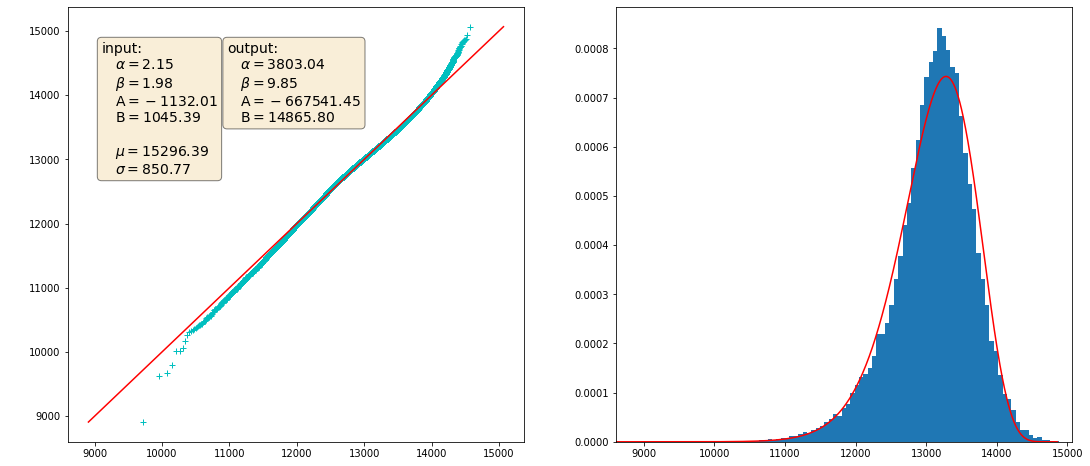

In [208]:
sample_size=50000
stdgumvar = 8.5
# def update_histogram(stdgumvar):
if True:
    (est2, sums, betapar, normpar) = effective_beta_random(stdgumvar, sample_size)
    alpha, beta, AA, BB = betapar
    qhbv, sigma = normpar
    Tret = 1./(1.-np.exp(-np.exp(-stdgumvar)))
    fig = plt.figure(figsize=(18,8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    pvalues2, q_fit_q = quantilesetbeta(sample_size,est2[0],est2[1],est2[2],est2[3])
    
    hisdata = ax2.hist(sums,100,density=True)
    minsum=np.min(sums)
    maxsum=np.max(sums)
    dsum=(maxsum-minsum)

    alpha_fit = est2[0]
    beta_fit = est2[1]
    AA_fit = est2[2]
    BB_fit = est2[3]
    
    jaQQplot = True
    if jaQQplot:
        ax1.plot(q_fit_q,np.sort(sums),'c+')
        ax1.plot([np.min(sums),np.max(sums)],[np.min(sums),np.max(sums)],'r-')
    else:
        ax1.plot(plotpos,np.sort(sums),'c+')
        ax1.plot(pvalues2,q_fit_q,'r-')

    # bereken de verwachting en het tweezijdig 95% betrouwbaarheids interval uit deze parameters:
    
    #qvalue, density = pdfbeta(1000,alpha_fit,beta_fit,AA_fit,BB_fit)
    xlim2 = list(ax2.get_xlim())
    xlim2[0] = max(xlim2[0],0.0)
    xlim2[1] = np.max(sums)
    
    ax2.set_xlim(max(xlim2[0],0.0),np.max(sums))
    x, y = pdfbeta(1000,alpha_fit,beta_fit,AA_fit,BB_fit,xlim2)
    ax2.plot(np.array(x),np.array(y),'r-')
    ax2.set_xlim(tuple(xlim2))
    
    # zet de parameters in box 1
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box of the input parameters for the Beta distribution
    textstr_in = '\n'.join((
    r'input:',
    r'   $\alpha = %.2f$' % (alpha, ),
    r'   $\beta = %.2f$' % (beta, ),
    r'   $\mathrm{A} = %.2f$' % (AA, ),
    r'   $\mathrm{B} = %.2f$' % (BB, ),'',
    r'   $\mu = %.2f$' % (qhbv, ),        
    r'   $\sigma = %.2f$' % (sigma, ),        
    ))    
    ax1.text(-0.04, 0.95, textstr_in, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='left', bbox=props)

    # place a text box of the output parameters for the Beta distribution
    textstr_out = '\n'.join((
    r'output:',
    r'   $\alpha = %-10.2f$' % (alpha_fit, ),
    r'   $\beta = %.2f$' % (beta_fit, ),
    r'   $\mathrm{A} = %.2f$' % (AA_fit, ),
    r'   $\mathrm{B} = %.2f$' % (BB_fit, ),
    ))    
    ax1.text(0.11, 0.95, textstr_out, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='left', bbox=props)

    print ("Uit de gefitte Beta verdeling volgt (Tr = %d jaar): "%Tret)
    print ("    2.5%% :  %.1f"%beta_reverse(alpha_fit,beta_fit,AA_fit,BB_fit,0.025))
    print ("   50  %% :  %.1f"%beta_reverse(alpha_fit,beta_fit,AA_fit,BB_fit,0.5))
    print ("   97.5%% :  %.1f"%beta_reverse(alpha_fit,beta_fit,AA_fit,BB_fit,0.975))
    DD_fit = BB_fit-AA_fit
    print ("   mean  :  %.1f"%(alpha_fit/(alpha_fit+beta_fit)*DD_fit+AA_fit))



In [200]:
sample_size=800
stdgumvar = 8.5
# def update_histogram(stdgumvar):
if True:
    (est2, sums, betapar, normpar) = effective_beta_quantiles(stdgumvar, sample_size)
    alpha, beta, AA, BB = betapar
    qhbv, sigma = normpardata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABDcAAAHSCAYAAAD4/CBBAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjMsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+AADFEAAAgAElEQVR4nOzde3zO5R/H8ddlbNiwzfk02zBzPs0pciqnROiAVEJRSSoVikg/xyJSzqdUzhGiojSR45xyCjFynEPC5tS27++Pzdo9O7Lt3u69n4/HHu7v9b2+1/dz77pw77Prur7GsixERERERERERDKrbPYOQERERERERETkfii5ISIiIiIiIiKZmpIbIiIiIiIiIpKpKbkhIiIiIiIiIpmakhsiIiIiIiIikqkpuSEiIiIiIiIimVp2eweQ0RQoUMDy9va2dxgiIiIZyo4dOy5allXQ3nFkFfo8IiIicrfEPo8ouRGHt7c3QUFB9g5DREQkQzHGnLB3DFmJPo+IiIjcLbHPI1qWIiIiIiIiIiKZmpIbIiIiIiIiIpKpKbkhIiIiIiIiIpmakhsiIiIiIiIikqkpuSEiIiIiIiIimZqSGyIiIiIiIiKSqSm5ISIiIiIiIiKZmpIbIiIiIiIiIpKpKbkhIiIiIiIiIpmakhsiIiIiIiIikqkpuSEiIiIiIiIimZqSGyIiIiIiIiKSqSm5ISIiIiIiIiKZmpIbIiIiIiIiIpKpKbkhIiIiIiIiIpmakhsiIiIOZmhwsL1DEBEREUlXSm6IiIg4mA9OnLB3CCIiIiLpSskNEREREREREcnUsts7ABEREbl/Q4ODbWZsmMBAAIaUKsVQHx87RSUiIiKSPpTcEBERcQBDfXxikhgmMBCrcWP7BiQiIpme94BVNsfHR7W2UyQiSdOyFBERERERERHJ1JTcEBERcTBDSpWydwgiIiIi6UrJDREREQejPTZEREQkq1FyQ0RExMEMDQ62dwgiIiIi6UrJDREREQcT+6kpIiIiIlmBkhsiIiIiIiIikqnpUbAiIiIOYGhwsM2MDRMYCERtLqo9OERERMTRKbmRwVy9epXr169jWZa9Q5FUYozB1dWVPHnyxHs+PDycy5cvEx4ens6RSWbg5OREvnz5cHFxsXcoksEN9fGJSWKYwECsxo3tG5CIiIhIOlJyI4PYv38/6wN/4urli7i55SZbNq0YchSRkZFcuxaGR4HCNGnanHLlygFw+/Ztvl+9igP79pArZ3Zy5MiOMcbO0UpGEx4ewbXQ6/iULscjrdvg7u5u75BERERERDIcJTcygP3797N6xSLatHwQb6/iSmw4oMjISI4G/8Xyb+bR/slnKF26NF99OYe8OSPp+Vwb8uRxs3eIkoHdvHmLoJ17mT1jKj1ffhVXV1d7hyQZkJaliIiISFam5EYG8Ov6n3m0RQN8vUvaOxRJI9myZaNsaW9aNI1gw6+/kD17dm5cu0SX9u01W0OSlDOnCw0eCODS5avs2bOHBx54wN4hSQakZSkiIiKSldltioAxZpYx5rwxZl+ssqHGmNPGmN3RX4/EOjfQGPOnMeaQMaZFrPKW0WV/GmMGxCr3McZsNcYcMcYsNMY4p9+7S77Q0FD+uXQen1Il7B2KpIOypUtx5tQJ9u/fh3+ZkkpsSIr4+3lz+NABe4chIiIiIpLh2HPmxhzgM2BunPJPLMv6OHaBMaYC0AmoCBQDfjLG+EWf/hxoBpwCthtjVliWdQAYHd3WAmPMFKAHMDmt3sy9CgsLw9VVe2xkFdmzZydnTmeu/HOZQiXj32BUJCH58uYhLDTU3mGIiIiIg/IesMreIYjcM7v9RG1Z1q/A38ms/hiwwLKsW5ZlBQN/ArWjv/60LOuYZVm3gQXAYybq1+FNgSXR138BtEvVN5CKsmWL/7f3L/QeQLtOvdI5GklrxhgiIyM1a0NSzBgDVqS9w5AMamhwMCYwMGavjTuvhwYH2zcwERERkXSQEacLvGqM+T162YpHdFlx4GSsOqeiyxIqzw/8Y1lWeJzyeBljehpjgowxQRcuXEit93Hfxo58jzlTP0r3+7p4+rN0+Q/pfl9JHes3bsXF05+Lly6nSft+VZsybuLMNGlbRO7dUB8frMaNY/bauPNam4mKiIhIVpDRNhSdDHwIWNF/jgW6A/H9itsi/uSMlUj9eFmWNQ2YBhAQEJBgvfSWL6+WLYiISPLoaSkiIpLW4lu2cnxUaztEInK3DDVzw7KsEMuyIizLigSmE7XsBKJmXsR+lEgJ4Ewi5RcBd2NM9jjlmUrsZSnN2jxLn7c+YPCH4yhWpi4l/B6g/+DRREb+N0Xdr2pTPhw1ked7vY1nyRp4+Te46zfs8c3KiP2beL+qTQHo3O11XDz9Y44l/dy6dZt+A0dQslx98hatwoPNOvLblh1A/LMyjv91ChdPf3bs2svxv07RvG1XAIqXrYeLpz8v9I7aZ7dZm2fp/eYQ3hwwnMI+tSnsU5sB74+5awzFHTPN2jxL33eGxbw+cfIMA4d8hIunPy6e/mn6vRAREREREUmODJXcMMYUjXXYHrjzJJUVQCdjjIsxxgcoC2wDtgNlo5+M4kzUpqMrLMuygF+AJ6Kv7wosT4/3kJYWLF5JdqfsBP4wn/GjBzNxylwWL1ttU2fCpDn4+5Vmyy/fMHjAq7z/v/F8u3JNsu/x289R25RMHv8hJw5uiDm+8wP03HlLU+8NSbwGDvmIJd9+z9SJw9kauIxKFfxo8+SLnD13PslrSxYvysIvPgVg96bvOHFwA2NHvhdzfsGSlURakaz/cQGfj/uAmV8s4tPJXyQ7toVzJ1KiWBHee/sVThzcwImDG2LOuXj68+GoiSl4pyKSmrQsRURERLIyuy1LMcbMBxoDBYwxp4AhQGNjTDWilpAcB3oBWJa13xizCDgAhAO9LcuKiG7nVeBHwAmYZVnW/uhb9AcWGGP+B+wCMv0mAeXLlWbIu68B4FfGh5lzF/PL+i10fPzRmDq1alZlQL+XYurs2LmPCZPm0K5N82Tdo2ABTwDc8+WhSOGCMeU5sufAr6yPlsqksbCw60ybvYApEz7kkeaNAfhs3FB+2bCFKTPn0bRRvUSvd3JywsMjHwAFC+anQH4Pm/NFChfkk1GDMMbg7+fLkaPH+XTSHF7v3S1Z8Xl6uOPklA03N1eb8QHgV9aH/HHuJyIiIiIikh7sltywLKtzPMUJJiAsyxoODI+nfDWwOp7yY/y3rMUhVKpYzua4WNGCnL94yaasbq1qNsd1alXj2+/W3ve9ixcrzN6t3993O5K4Y8dP8u+//1KvTo2YMicnJ+rWqsbBQ0eTTG4kpU5ANZuntNSpVY2hIyZw9WooefO63VfbGh8i9tV41y7WX7kSc3xnz41G+fIRWL26naISERERSR8ZbUNRSUSOHLbddeeRoilhjMGKs2Xqv+Hh8VeWdGdFd058j4k1QLZs2WzqAfz7b+r1n8mW7e7xkYrti0jaiZ3AMIGBMctTRERE4hPf5qAimVmG2nND7t/WoN02x9uC9uDv5xtzXLCAJ2dD/tu7IeT8Rc6es338bY4cOYiISFnSRFJHaR8vnJ1zsCl6A1GAiIgItmzfTflyZSiQP2rZ0LmQ//rs971/2LThnCNHzHVxbduxxyYxsi1oD8WKFoqZtVEwvyfnYo2PmzdvcejIMZs2cjjnSHFSTUREREREJC0pueFgtgXtYcwnUzly9Dgzv1jEVwu/5bWXu8acb/xgHabMnMeOXXvZ/fsBXug9kJw5XWzaKOVVjHW/buZcyAUu/xM1xfn0mRAq12nF8lRY4iIJc3XNTc9unRk0bCzfr13PwUNHebXfUM5fuESvHp0p4+tFyeJF+XD0Zxz+M5i16zYycuxkmza8ShbHGMP3a9Zz4eLfhIaGxZw7e+48/QaO4NCRYyxd/gPjJs6kz0uxxkfDOixY8h3rN27lwMEj9Ozz7l0zN0qVLM7GzUGcPhNi89SWynVaMWn6V2n0nRERSV3GmJbGmEPGmD+NMQPiOe9ijFkYfX6rMcY71rmB0eWHjDEtkmrTGPOQMWanMWa3MWajMaZMWr8/ERGRrEbJDQfT95Xn2bv/EHUad2DoiAkMGfgaHR5rGXN+9If98SlVkmZtu9Lp+b50f/YJCkVvIhq7zvqN2yhduQl1GrUH4N/wfzl8JJgrV6+l6/vJikYMfYvHH2tFz1ffpXajduzbf5iVi6dTtEghcuTIwZczxhJ8/CS1Grbjw1ETGTb4DZvrixcrzPsD+jBk+HhKlqvP6/0/jDnX6Yk2RERG8GCzjrz8+vs8/8zj9H3l+Zjz77zei8YP1uGJLr1p/UQPHqhbk+pVK9i0P2Tga5w6fY7yNZtRvOx/e4AcPhLMpVjJDhFJX0ODgzGBgTF7bdx5PTQ42L6BZUDGGCfgc6AVUAHobIypEKdaD+CyZVllgE+A0dHXViDq6WwVgZbAJGOMUxJtTga6WJZVDZgHDErL9yciIpIVGSvuAvssLiAgwAoKCkq3+4WEhLB4/ix6du1w3235VW3KSy904c0+PVIhMkkrE6cvpFARL/y93alauXy63bdZm2epUL4sE8a8n273lNQVcv4iK37cSu/X3rR3KJLBpcWeG8aYHZZlBaRqo3ZijKkHDLUsq0X08UAAy7JGxqrzY3SdzcaY7MA5oCAwIHbdO/WiL4u3TWPMIeA5y7K2RpfnsSzr3cRiTO/PIyKS9aTVnhvHR7VOk3ZFIPHPI9pQVERERLKa4sDJWMengDoJ1bEsK9wYcwXIH12+Jc61xaNfJ9TmC8BqY8wN4CpQN76gjDE9gZ4AXl5eKXtHIiIiWZyWpYiIiEhWc/cjqSDuVNaE6qS0HOAN4BHLskoAs4Fx8QVlWdY0y7ICLMsKKFiwYLyBi4iISPw0c8OBHN6zzt4hSAa2duWX9g5BRNJQ4127WH/lSszxnb03GuXLZ/OYWAGiZlWUjHVcAjiTQJ1T0ctS8gF/J3HtXeXGmIJAVcuytkaXLwR+SI03ISIiIv9RckNERMQBxE5gpMWeGw5mO1DWGOMDnCZqg9Cn49RZAXQFNgNPAOssy7KMMSuAecaYcUAxoCywjaiZG/G1eRnIZ4zxsyzrMNAMOJjWb1BERCSrUXJDRETEAQwNDuaDEydiju/M3BhSqhRDfXzsFFXGFL2HxqvAj4ATMMuyrP3GmGFAkGVZK4CZwJfGmD+JmrHRKfra/caYRcABIBzobVlWBEB8bUaXvwh8Y4yJJCrZ0T0d366IiEiWoD035J6N+WQqDzz0BAW8alK8bD3ad36J/QcOJ3ndhk3b6fD0y/hUbIiLpz9z5y29q86Hoybi4ulv8+Xl3yAt3oakQHL6ZfKMr6nZoC0FvGpSwKsmDZt3ZPWaQJs6yRk79zK+rl0Lpd/AEZSt0pR8xarSqEUngnbuTXF8IpnRUB8frMaNY2Zs3HmtxEb8LMtabVmWn2VZpS3LGh5d9n50YgPLsm5alvWkZVllLMuqbVnWsVjXDo++rpxlWd8n1mZ0+TLLsipbllXVsqzGsdsSERGR1KHkhtyz9Ru30at7Z9b/MJ8fl88he/bstOrQnb8v/5PodaFh16lYvixjR7xLrlw5E6znV9aHEwc3xHzt2Lgitd+C3IOk+qV4sSIMH/IWWwKXsmndEho3rMuTz7zK3v2HYuokZ+zcy/h6qe9g1q7byIxJI9mxcQUPN6lPq/bdOH0mJEXxiWRGQ4ODMYGBMTM27rweGhxs38BERERE0oGWpTionbv3MXDox2zZtotiRQszbeJwQkIu8tnUuQT+MD9V7rHqm5k2x7Mnj6agdy02bd3Joy2bJnhdq2aNaNWsEQAvvPpugvWyO2WnSGHtFp9c6dHnkHS/tH3kIZvjYYPeYNqsBWzZvovKFcsByRs7KR1fN27cZNnKNSz44lMaNYh6+uLgAX1Y9eMvTJs9nw/eez3Z8YmIiIiISOaimRsOKGjnXpq2fobGDeoQtGE5dQKq8uGoiYwaN4Uh7/a9q/7ocVPwLFkj0a+Nm4OSvO+10DAiIyPxcM+XKu8j+MRJfCo2xK/aQzzT402OHT+ZKu06ovTs85T0S0REBIu+WUVo2HXq1U74aQ3JGTtJ1QkPDyciIoKcLs425bly5mTTlh33FZ+IiIiIiGRsmrnhgPoPHk3rFk0Y+NbLAHR84lE6dH6ZBx8IoEnDunfVf7FbJx5v1yrRNosXLZzkffsNHEHVyuWpW6vavQUeS62aVZnx2UjK+fly/sIlRo2dTOOWndm1aSX5PT3uu31Hk159ntx+2XfgEA1bdObmzVu4ueZm0ZcTqVQh4VkRyRk7SdXJk8eNurWqMWrsFCqW96NI4QIs/GYVW7bvprSvl03dlMYnkhnMOXcuwXLtuyEiIiKOTskNB3Mu5AIbNwexZsUXMWXOOXIQGRkZ72/wATw93PH0cL+v+7793kg2bd3ButXzcHJyuq+2AFo2a2hzXCegKv41mvHl/G95vXe3+27fkaRnnye3X/zK+LBt/TKuXLnKspVreOGVAaxdMZeKFfzuajM5Yye542vWlDH06vMuvpUa4eTkRPWqFej4eGt27TlgUy8l8YlkFsfr1Yt5rUfBioiISFaj5IaD+ePwUQACqleOKTv8ZzB+ZX2oX7dmvNeMHjeF0Z9MS7TdFYum0aBeQLzn3np3JIuXrebH5V/g613yHiNPnJubKxX8y/DnsRNJV85i7NHndyTUL87OzpTxLQVAzeqVCdq1j08nf8HUicNt6iVn7KRkfJX28eKn774iLOw6V6+FUrRIIbp0fwPvUiXuKT6RzMR782ZO3LoVc3xnY9FSLi42iQ8RERERR6TkhoO5cuUaxhiyZYvaTuXatVBGj5tC4UIJbwB5P8tS3hwwnMXLVrNmxVz8/XzvPfAk3Lx5i0NHgmM2ipT/pHefx5bcfrEiI7l1+7ZNWXLGzr2OL1fX3Li65ubyP1dYu24jI4a+leL4RERERCTlvAessjk+Pqq1nSKRrEbJDQdTpXJ5LMtizCfT6PTkowwc8hFFChfk6LG/OHL0OGVLe991zb0uUXjt7WHMW7icxV99jod7Xs6FXADAzTU3bm6uAEya/hWTZ3zN3q3fx1wXGhrG0eC/AIiMjOTkqbPs2XsQD498eJUoBkTvIdGyCSVLFOPChUuM+HgSYWHXeaZzuxTH6ejSs8+T0y/vfTCWVs0bUaJ4EUJDw1iw5DvWb9zGtwumxtRJzti5l/G15ucNREZalPPz5eixEwwc8hF+ZXzo2qVDiuITyYy8c+a0mbkRu1xERETE0Sm54WB8SpVg2KDX+XTyF4ydOIP2bZrz/bLZtO/0Eo1bdub0kc2pdq+pM+cB0LLd8zblg97pzeABfQC4dOkyh48E25zfsXsfzdt2jTkeNmoiw0ZN5NnO7Zjx+SgATp8J4bkX+3Hx0j8ULOBB7ZpV2bBmIaVKFk+1+B1FevZ5cvol5PwFuvV6h3PnL5Avbx4qVSzHikXTaP7QgzF1kjN27mV8Xb0ayqAPx3H6zDk8Pdxp16YZwwa9QY4cOVIUn0hmdPzmzRSVi4hI1hJ3RoWIozGWZdk7hgwlICDACgpK+rGnqSUkJITF82fRs2uHpCuLQ5g4fSGFinjh7+1O1crl7R2OZCIh5y+y4set9H7tTXuHIhlQ3D037kitPTeMMTssy0p8Ix5JNen9eUREHJ+9khtaliKpKbHPI9nSOxgRERERERERkdSk5IaIiIgDSGhvDe25ISIiIlmBkhsiIiIOYOOVKwDkv3KF5tu2kS801KZcRERExJEpuSEiIuIA3JycAAg4dIgf+/en/IkTNuUiIiIijkzJDREREQfgnt32AWiWMfGWi4iIiDgiJTdEREQcwD/h4QCYOE9Bu1MuIiIi4siU3BAREXEAVyIigP+SG1acchERERFHpuSGA1uwZCU16rfBvXg1KgS0YMmy7+0dkqQx9bmIOEVGAhCuvTZEREQkC1Fyw0Gt+vEXer02iDf79GDnbyt5sn0rXn59MBGp+Bu8DZu20+Hpl/Gp2BAXT3/mzlua5DXXroXSb+AIylZpSr5iVWnUohNBO/fa1ImIiGDo8An4VXuIvEWr4FftIYYMH0+4plYnKiP1+ZSZ82L6r26TDmzcHJRk20ldk5yxIyKQPfrvfISSGyIiIpKFKLnhoMZ/NotXXnyGZzq1w9e7JG1aPcS10DCyZUu9Lg8Nu07F8mUZO+JdcuXKmaxrXuo7mLXrNjJj0kh2bFzBw03q06p9N06fCYmp8/GE6UyZOY9xo97j962rGTvyPabMmMeYT6alWuyOKKP0+eKlq+k3cAT93+jF1sBl1K1dnbZP9eSvU2cSbDc51yRn7IjIfzM3IlLx776IiIhIRqdPPg7o+vUb/LZlJ62aN4opW/PzBqpU8sdE756fGlo1a8SHg9+kw2Mtk/UD9I0bN1m2cg3/G9KPRg3qUMa3FIMH9KG0rxfTZs+Pqbd52y5at2zMoy2b4u1VgjatmvJoqyZs27En1WJ3NBmpzydMmsNzndvTo+tTlC9XmvGjB1OkcEGmzZofb/3kXJPcsSMi4BQ9c0PLUkREJLVli4yg2ZEtjF49gS8XDGLSshF0374cj+tX7B2aiJIbjmjv/kNERkZSrXIFbty4ydcLlzP6k6m82ad7vPVHj5uCZ8kaiX4lZ1lBUsLDw4mIiCCni7NNea6cOdm0ZUfMcf26NVm/YRt/HD4GwME//iTw1620bNYIiV9G6fPbt2+zc89+Hm5S36b84Sb12bJt1z1fk9yxI5KVuUQnMmOWpUQnIF1SMcEpIiJZV43TB1k7szfTl/6P5ke24Hb7BhXOB/P+uulsmPoCXXathjhP7BJJT9ntHYCkvj37/sDXx4ujwSeo1/QJLMuiWdMGPNGuVbz1X+zWiccTOHdH8aKF7zuuPHncqFurGqPGTqFieT+KFC7Awm9WsWX7bkr7esXUe6vvi1wLDaNavdY4OTkRHh7OgH4v8VKPp+87BkeVUfr84qXLREREUKhQfpvywgXzs279xXu+JrljRySr8t68mVvRHyjjLku5rQ+aIiJyn57ZtZqha6dwNm9BXnlsAD/41SMyW9QMwbIXTjB43QyGr5lE9TOHeKfVazHnRNKTkhsOaPfvB6hepQJlS3uzYc1CgnbtZcj/xvP2oFF8MmrQXfU9Pdzx9HBPl9hmTRlDrz7v4lupEU5OTlSvWoGOj7dm154DMXUWL13N1wuWM3fax1QoX4Y9e/+g38AReHuVoNuzT6RLnJlNRuvzuEthLMtKcnlMUtckZ+yIZFUnbt2KeR2T3IhelhLZuLE9QhIREQfRY/u3DF43g7VlavPmo/245uJqc/5IwVJ0feoD+v42n9d/m4+F4e1H+oJmDko6U3LDAf2+9w/atWmGm5srtWpWoVbNKpz46zS//rYt3vqjx01hdBKbda5YNI0G9QLuO7bSPl789N1XhIVd5+q1UIoWKUSX7m/gXapETJ2BQz7i9Ve789TjrQGoVKEcf508w5jx05TcSEBG6fMC+T1wcnIiJMR2lsb5i39TuGD++7omOWNHRCBXdKLjhrNzEjVFREQS1/LQbwxeN4PVfg/wWtt3CHeK/8dHy2RjfIMuALz+23wOF/Biep0O6RmqiJIbjiYiIoJ9Bw/Tv99LNuV79x+ift2a8V6TXstSYnN1zY2ra24u/3OFtes2MmLoWzHnrt+4gZOT7XYwTk7ZiIz+baTYykh97uzsTI2qFfkp8Dceb9cypvznwN9o36Z5qlyT2NgREXC9eROA0Fy57ByJiIhkZqUvnmTcqnHsLFaON9q8lWBiI7bx9Z/G78IJ+q+fw44S5dlZvHw6RCoSRckNB3P4SDA3btxk9NgpFC9aCDc3V75a8C07du1j4tih8V5zr0sUQkPDOBr8FwCRkZGcPHWWPXsP4uGRD68SxQCYNP0rJs/4mr1bvweinuARGWlRzs+Xo8dOMHDIR/iV8aFrl/8yu61bNuHj8dPxLlWCCv5l2PP7QSZMmkOXjo+lOMasIKP1ed9Xnqfby/2pVaMK9erUYPrsBZw9d4EXu3WKaSfuuEjONckZOyICbjduEGkMN1xc7B2KiIhkUk6REYxdPY6b2V3o1f49bmVP5mxAY+j/SF+qzPqT0d9/yiPdPk3bQEViUXLDwezee5DChQrg7p6XZm2fI1fOnNQOqMralXPx9S6ZqvfasXsfzdt2jTkeNmoiw0ZN5NnO7Zjx+SgALl26zOEjwTF1rl4NZdCH4zh95hyeHu60a9OMYYPeIEeOHDF1Phk1iKEjPqXvW8M4f/ESRQoXpPtzT/Le271TNX5HkdH6/MkOj3Dp8j+MGjuZsyEXqFi+LMsXTqVUyeIx18UdF8m5JjljR0SikhvXXVywkvGIbhERkfj02voN1c4eoXfb/lxw80zRtddcXBnc/GVmL/mAF7ctA9qlTZAicRhLu6jbCAgIsIKC7v+xp8kVEhLC4vmz6Nk1dX77POD9MRw6coxl86ekSnuS+iZOX0ihIl74e7tTtfL9T9VTn2cdIecvsuLHrfR+7U17hyIZjAkMjHk9ZexYHvvtN4ouXQqAlUobihpjdliWdf+bL0mypPfnERFxfN4DViWrntfls6yd+TJry9bj1cf63/P9Ji8bQaPgHeQ+eQIKp+4Sd8m6Evs8ol/rOJjdew9SuWI5e4ch6Uh9LpK1xU5sABS8coWL+fLZJxgREcn0BgbOJjxbdj546MX7amdMo644h/8LI0akUmQiiVNyw8Hs3fcHlSvoB92sRH0uIrEV+ftvznlGTSFOrVkbIiKSNdQ+uY9Whzcxue4TKV6OElewZ3EWV34YpkyBv/5KpQhFEqbkhoM5fWQzT3Z4xN5hSDpSn4tIbEUvXYpJboiIiCSbZfHuLzM5k6cAM2qlzj4Znz3QCSIiYPz4VGlPJDHaUFRERMRBmMhIil66xNn8+e0dioiIZDKNgndS7ewR+rfsw80cOVOlzdP5CvFtuQY8/PkUHoisw9WcbgAcH9U6VdoXiU0zN0RERByE1/nz5Pz3Xw6XKGHvUEREJDOxLPpsWsCpvAVZWqlpqjY9rfbjuN2+Qec9P6Rqu+pRU6MAACAASURBVCJxKbkhIiKSScXdTNQ/ek3zH15eNNKmoiIikkz1/tpLwOmDTKnzBP865UjVtg8U9mVLyUo8vfsHjBWZqm2LxKbkhoiIiIOocPw4EJXcCKxe3b7BiIhIpvHylsWcd/VgcZVmadL+/KotKPXPOer+tTdN2hcBJTcc2u7fD5CrQAUat+xs71AStWHTdjo8/TI+FRvi4unP3HlL76nO5BlfU7NBWwp41aSAV00aNu/I6jWBNnXGfDKVBx56ggJeNSleth7tO7/E/gOHk4xxysx5+FV7iLxFq1C3SQc2bg5KcXzpIbP0+bVrofQbOIKyVZqSr1hVGrXoRNBO2//sUtpXo8dNwcXTn77vDEtRO8m5T2r0b0LxRUREMHT4hJjx5VftIYYMH094eHiK7yFS98ABThQuzEV3d3uHIiIimUTpSydpeHwXc2u05lZ25zS5xw/l6vNPTjc67/kxTdoXASU3HNrMuYvp1aMz+w8e4eCho/YOJ0GhYdepWL4sY0e8S65c8W9elJw6xYsVYfiQt9gSuJRN65bQuGFdnnzmVfbuPxRTZ/3GbfTq3pn1P8znx+VzyJ49O606dOfvy/8kGN/ipavpN3AE/d/oxdbAZdStXZ22T/Xkr1NnUhRfesgsff5S38GsXbeRGZNGsmPjCh5uUp9W7btx+kxITJ2U9NXW7buZOXcxlSve/UjcpNpJzn3ut38Ti+/jCdOZMnMe40a9x+9bVzN25HtMmTGPMZ9MS/F9JIuzLOrv389vFSvaOxIREclEnt25iltO2ZlftWWa3eNWdmeWVWxCi8Ob8Lh+Jc3uI1mbkhsO6saNmyxc8h09nnuKDm1bMOerJfYOKUGtmjXiw8Fv0uGxlmTLFv+QTE6dto88RMtmDSnjWwq/Mj4MG/QGedxc2bJ9V0ydVd/MpGuXx6lYwY9KFcoxe/JoLlz8m01bdyYY34RJc3iuc3t6dH2K8uVKM370YIoULsi0WfNTFF9ayyx9fuPGTZatXMP/hvSjUYM6lPEtxeABfSjt68W02f99T5PbV1euXqNrr7eZ+ulwPNzz3nW/pNpJzn3up3+Tim/ztl20btmYR1s2xdurBG1aNeXRVk3YtmNPiu4jWU/c/TZKnzlD8YsX+a1SJe23ISIiyeJ26zpP7PuZVf4Pcsk1bWf9LajaApeIcB47sD5N7yNZl5IbDmrpih/xKlmMyhXL8XTHtny9cDn//vtvvHVHj5uCZ8kaiX7FXYaR0UVERLDom1WEhl2nXu2E151fCw0jMjISD/f4fxC4ffs2O/fs5+Em9W3KH25Sny3bdsV7jb1klj4PDw8nIiKCnC620x5z5czJpi07Erwuob565fX36dC2BU0a1k3W/ZPq86TOp1RS8dWvW5P1G7bxx+FjABz8408Cf91Ky2aNUuX+knU89ttvAKyqV0/7bSSDMaalMeaQMeZPY8yAeM67GGMWRp/faozxjnVuYHT5IWNMi6TaNMZsMMbsjv46Y4z5Nq3fn4hIcnTY9zNut2/wRY1H0/xehwp6c7CgN4/+sSHN7yVZU3Z7ByBpY/aXi3n6qbYANKxfm9y5cvLd9+to37bFXXVf7NaJx9u1SrS94kULp0mcqW3fgUM0bNGZmzdv4eaam0VfTqRShbuXAtzRb+AIqlYuT91a1eI9f/HSZSIiIihUKL9NeeGC+Vm3/mKqxn6/Mkuf58njRt1a1Rg1dgoVy/tRpHABFn6zii3bd1Pa1yvB6+Lrq5lfLOJo8AlmTxmd7Psn1edJnU+J5MT3Vt8XuRYaRrV6rXFyciI8PJwB/V7ipR5P3/f9xXHFnbUB0H7DBnaVKcOJIkXSP6BMxhjjBHwONANOAduNMSssyzoQq1oP4LJlWWWMMZ2A0UBHY0wFoBNQESgG/GSM8Yu+Jt42Lct6MNa9vwGWp/FbFBFJmmXRdecqdhf1Y0+xhD8vp6aV5Rvyzq9z4a+/wCvhz30i90LJDQf057ETbNq6i7nTxwJgjKHTk22Y9eWSeH/Q9fRwx9Pj/qahDRk+nlFjpyRaZ82KL2jUoM593ScpfmV82LZ+GVeuXGXZyjW88MoA1q6YS8UKfnfVffu9kWzauoN1q+fh5OSUaLvGGJtjy7LuKrOnzNbns6aMoVefd/Gt1AgnJyeqV61Ax8dbs2vPgXhaib+vDh05xvv/+4SfV32Ns3PyNr9Kqs9TMiaSktz4Fi9dzdcLljN32sdUKF+GPXv/oN/AEXh7laDbs0/cVwySdZQ9eZIG+/bxbo8eWI0b2zuczKA28KdlWccAjDELgMeA2P8IPQYMjX69BPjMRP3D/xiwwLKsW0CwMebP6PZIqk1jTB6gKdAtjd6XiAgA3gNWJVmn5umDlP77FG+36psOEUW5k9wY3vUDptfpEFN+fFTrdItBHJeSGw5o9pdLiIiIoEyVpjFllmUBcPLUWUqWKGpTf/S4KYxOYvPCFYum0aBeQILn+7zUlc5Ptk20Da84900Lzs7OlPEtBUDN6pUJ2rWPTyd/wdSJw23qvfXuSBYvW82Py7/A17tkgu0VyO+Bk5MTISG2szTOX/ybwgXzJ3BV+stsfV7ax4ufvvuKsLDrXL0WStEihejS/Q28S5W4q25CfbV1+24uXrpMjfptYsoiIiLYsCmI6bMXcvnULlxiLX1Jqs+TOyaSK7nxDRzyEa+/2p2nHo/6T71ShXL8dfIMY8ZPU3JDkq3XypX86+TErEceYYS9g8kcigMnYx2fAuJmYmPqWJYVboy5AuSPLt8S59ri0a+TarM98LNlWVfvK3oRkVTwxN6fCMuRk1X+DdLtnifdi7CnSFna/PGrTXJDJDUoueFgwsPD+WrBt/zv/Td5pHljm3PdXu7P3HlLee+d3jblqbFEoUB+Dwrk97inmNOSFRnJrdu3bcreHDCcxctWs2bFXPz9fBO93tnZmRpVK/JT4G883u6/HaR/DvyN9m2ap0nMKZWZ+9zVNTeurrm5/M8V1q7byIihb9mcT6yv2rZ+mJrVKtmUvdjnXcr4lqL/G71wds6RrHaSc/5eJDe+6zdu4ORku/2Rk1M2IiMjUyUOcTxxl6S4X7tGj9WrWdagASGenvYJKvOJb+qdlcw6CZXHt49Z3DY7AzMSDMqYnkBPAC9N1xaRNJTr9k0e/WMDq8s14LpzrnS998ryDzLol1mUunyGEx7F0vXe4tiU3HAwq9es5+Kly3R/7knye9r+4PlUh0eYNms+A9962eaJD6mxROF+hIaGcTT4LwAiIyM5eeose/YexMMjH14liiW7znsfjKVV80aUKF6E0NAwFiz5jvUbt/Htgqkx93rt7WHMW7icxV99jod7Xs6FXADAzTU3bm6uTJr+FZNnfM3erd/HXNP3lefp9nJ/atWoQr06NZg+ewFnz13gxW6dUvQe0kpm7PM1P28gMtKinJ8vR4+dYOCQj/Ar40PXLv9l8JPqK/d8eXHPZ/v0EdfcufDwyGezDCmpdpI6D8nr37hjJ7nxtW7ZhI/HT8e7VAkq+Jdhz+8HmTBpDl06Pnb/32jJEt5cvBj3sDCGP/OMlqQk3ykg9hStEsCZBOqcMsZkB/IBfydxbYJtGmPyE7V8pX1CQVmWNQ2YBhAQEBA3MSIikmpaHNlMnts3WFL5oXS/9w/l6jPol1k0O7KFGbU1e0NSj56W4mDmfLWERg1q3/VDLkCHx1py4uQZfg7cZIfIErZj9z5qN2pP7UbtuXHjJsNGTaR2o/YMG/lpiuqEnL9At17vULl2K1q260bQrn2sWDSNls0axtSZOnMe10LDaNnueUqVfzDm65PPZgFw6dJlDh8JtonvyQ6P8PGIgYwaO5najdqxaesOli+cSqmSxWPqJCe+tJIZ+/zq1VBe7/8hVeq0oscrA3igbg1WLZ1Jjhz/zbZIqq+SK6l2knOf5PRvfGMnOT4ZNYj2bVvQ961hVK3bmncGj6b7c08ybNAbKW5LHF/cWRtFL17k9SVLWNyoEYfKlrVPUJnTdqCsMcbHGONM1AahK+LUWQF0jX79BLDOilrvtwLoFP00FR+gLLAtGW0+CXxnWdbNNHtXIiLJ9MTenzjhXoRtJSum+71P5SvMwYLePPzntnS/tzg2c2ddvkQJCAiwgoLS77GnISEhLJ4/i55dlbXMKiZOX0ihIl74e7tTtXJ5e4cjmUjI+Yus+HErvV97096hiB24b9jAlYgIm7KFQ4fSdtMmKs2ezZ9duqTp/Y0xOyzLSngjnkzGGPMIMB5wAmZZljXcGDMMCLIsa4UxJifwJVCdqBkbnWJtFvoe0B0IB163LOv7hNqMdb9AYJRlWT8kJ770/jwiIo4lsQ1Fi109z8bJPRjf4Gk+rd85HaP6z1u/zuWlLUuo8do8ruZ004aikmyJfR7RshQREZFMIG5io+3GjTy1fj3v9eiR5okNR2RZ1mpgdZyy92O9vknUbIv4rh0ODI+n/K42Y51rfB/hioikmjYHfyUbFssqNrFbDD+Xrs2rmxfR+FgQKyo0tlsc4li0LEVERCSDi7scpWRICLPHjGFXmTJ81LGjfYISEZFM6dGDG9hd1I+T7kXsFsPuYn5cyO2upSmSqpTcEBERycCyx0lsuNy+zcJhw8geEcFTQ4Zwu1kz+wQmIiKZjvffp6kccpSV5RsmXTkNWSYb60rXovGxHWSPCLdrLOI4lNwQERHJwGIvRjGRkXwxciT1Dhyg+zvvcOSZZ+wWl4iIZD6P/rEBgFXlGtg5ElhXuhZ5b4VR7ewhe4ciDsJuyQ1jzCxjzHljzL54zr1ljLGMMQWij40x5lNjzJ/GmN+NMTVi1e1qjDkS/dU1VnlNY8ze6Gs+NcbE91x6ERGRDMtmOYpl8fHkyXQMDOTtXr34plEju8UlIiKZ06MHN7CtRAXO5S1g71DYXKoKESYbDwbvtnco4iDsOXNjDtAybqExpiTQDPgrVnEroh61VhboCUyOrusJDAHqEPXs+CHGmDvPw5wcXffOdXfdy1G90HsALp7+MV/FytSlXade/HH4WKrfa8Om7XR4+mV8KjbExdOfufOWxltvysx5+FV7iLxFq1C3SQc2bo5/B/jR46bg4ulP33eG2ZR/OGqizXty8fTHyz/pjPPkGV9Ts0FbCnjVpIBXTRo278jqNYE2da5dC6XfwBGUrdKUfMWq0qhFJ4J27k3eNyCDyIh9fkd8fRoREcHQ4RNixoRftYcYMnw84eH/TUv0q9r0rj538fTnsY69Yurc67gY88lUHnjoCQp41aR42Xq07/wS+w8ctqnjCONCMre4iY2xkybx5pIlfNq+PR937IjVuLG9QhMRkUyo7IUT+F88wXf+D9o7FACu5nRjT9GyPHh8p71DEQdht+SGZVm/EvVotbg+Ad4BYj+j9jFgrhVlC+BujCkKtADWWpb1t2VZl4G1QMvoc3kty9oc/Uz6uUC7tHw/GU3TRg9w4uAGThzcwKpvZnLj5i2eevbVVL9PaNh1KpYvy9gR75IrV8546yxeupp+A0fQ/41ebA1cRt3a1Wn7VE/+OnXGpt7W7buZOXcxlSuWi7cdv7I+Me/pxMEN7Ni4Isn4ihcrwvAhb7ElcCmb1i2hccO6PPnMq+zd/9/0t5f6Dmbtuo3MmDSSHRtX8HCT+rRq343TZ0JS8J2wv4zU53ck1KcfT5jOlJnzGDfqPX7fupqxI99jyox5jPlkWkyd335eYtPfWwOXYozhiXa2ecp7GRfrN26jV/fOrP9hPj8un0P27Nlp1aE7f1/+J6aOo4wLyZxiJzZMZCSfTZgQk9jo26cPVhP77XAvIiKZ06N/bCTCZOP7DLAk5Y4N3tWpevYIXL5s71DEAWSoPTeMMW2B05Zl7YlzqjhwMtbxqeiyxMpPxVOe0H17GmOCjDFBFy5cuI93kHG4uOSgSOGCFClckOpVK/Lay105dOQYN27cTNX7tGrWiA8Hv0mHx1qSLVv8w2nCpDk817k9Pbo+RflypRk/ejBFChdk2qz5MXWuXL1G115vM/XT4Xi45423nexO2WPeU5HCBSlYwDPJ+No+8hAtmzWkjG8p/Mr4MGzQG+Rxc2XL9l0A3Lhxk2Ur1/C/If1o1KAOZXxLMXhAH0r7ejFt9vwkWs9YMlKfQ+J9unnbLlq3bMyjLZvi7VWCNq2a8mirJmzb8d9f/YIFPG36+4e1v5I3jxuPP2ab3LiXcbHqm5l07fI4FSv4UalCOWZPHs2Fi3+zaWvUbw4caVxI5hM7seF64wZL33+f3suXM6ZjRyU2RETknjU/spmgEhW44OaRdOV0ssGnOk5WJPzyi71DEQeQYZIbxpjcwHvA+/GdjqfMuofyeFmWNc2yrADLsgIKFiyYnHAzlWvXQlmy7HsqVfCL9zfto8dNwbNkjUS/ElpGkpTbt2+zc89+Hm5S36b84Sb12bJtV8zxK6+/T4e2LWjSsG6CbQWfOIlPxYb4VXuIZ3q8ybHjJxOsG5+IiAgWfbOK0LDr1KtdHYDw8HAiIiLI6eJsUzdXzpxs2rIjRe1nJPbs8zsS69P6dWuyfsO2mGUzB//4k8Bft9KyWfx7CFiWxeyvltD5qTbkzp3L5tz9jguAa6FhREZG4uGeD3DccSEZX+zERonz59nYpw9tNm/mtVdfpX+vXkpsiIjIPfG6fJbyF46zpmzCn7XtYXfRclxzzgVr1tg7FHEA2e0dQCylAR9gT/TenyWAncaY2kTNvCgZq24J4Ex0eeM45YHR5SXiqZ9lrPl5I54lo/ZdDQu7TsniRVm+cGq8dV/s1onH27VKtL3iRQvfUxwXL10mIiKCQoXy25QXLpifdesvAjDzi0UcDT7B7CmjE2ynVs2qzPhsJOX8fDl/4RKjxk6mccvO7Nq0kvyeiWef9x04RMMWnbl58xZurrlZ9OVEKlWIWiaRJ48bdWtVY9TYKVQs70eRwgVY+M0qtmzfTWlfr3t6z/aSUfocku7Tt/q+yLXQMKrVa42TkxPh4eEM6PcSL/V4Ot76P/3yG8dPnKL7s0/alN/PuIit38ARVK1cnrq1qgGONS4k84id2Hhk82bmjB6Nc3g4rUeO5MfatbXHhoiI3LNmR7YAZLjkRrhTdrZ4VaHZ2rX2DkUcQIZJbliWtRcodOfYGHMcCLAs66IxZgXwqjFmAVGbh16xLOusMeZHYESsTUSbAwMty/rbGHPNGFMX2Ao8B0xMz/djbw8+EMDnn0Rt4Hj58hWmzppH6yd6sGHNIkqWKGpT19PDHU8P9zSNJ+7DaizLwhjDoSPHeP9/n/Dzqq9xdnZO4Gpo2cz2Wdx1AqriX6MZX87/ltd7d0v03n5lfNi2fhlXrlxl2co1vPDKANaumEvFCn4AzJoyhl593sW3UiOcnJyoXrUCHR9vza49B+7x3dpHRunz5PTp4qWr+XrBcuZO+5gK5cuwZ+8f9Bs4Am+vEnR79om76s+au5iAGpWpWrm8Tfn9jIs73n5vJJu27mDd6nk4OTn9d08HGReSOdxJbDjfvs3I6dN5c8kSdpcuTcf33+ewl5cSGyIicl+aH9nCwYLenHQvYu9Q7rLZqwrN1k2HkyehZMmkLxBJgN2SG8aY+UTNuihgjDkFDLEsa2YC1VcDjwB/AteBbgDRSYwPge3R9YZZlnVnk9KXiXoiSy7g++ivLCNXrpyU8S0Vc1yjWkUKetdi5heLGPpeX5u6o8dNYXSsjRzjs2LRNBrUC0hxHAXye+Dk5ERIyEWb8vMX/6Zwwfxs3b6bi5cuU6N+m5hzERERbNgUxPTZC7l8ahcuLnf/gOzm5koF/zL8eexEkjE4OzvHfC9qVq9M0K59fDr5C6ZOHA5AaR8vfvruK8LCrnP1WihFixSiS/c38C5VIrFmM5yM0ufJ6dOBQz7i9Ve789TjrQGoVKEcf508w5jx0+5Kbpy/cImV369jwpjBSd47JeMC4K13R7J42Wp+XP4Fvt62/5k6yriQjK3xrl2sv3IFgBqHDjHzo4+odvQoE9u35+2XXuKWs7MSGyIicl/yh/1DwOmDfFavo71DiddWr0pRL379Fbp0sW8wkqnZLblhWVbnJM57x3ptAb0TqDcLmBVPeRBQ6f6idBzGGLIZw/UbN+46l5ZLFJydnalRtSI/Bf7G47GecvFz4G+0b9Octq0fpmY12256sc+7lPEtRf83euHsnCPedm/evMWhI8E0alAnxTFZkZHcun37rnJX19y4uubm8j9XWLtuIyOGvpXitjMSe/V5cvr0+o0bODnZbvnj5JSNyMjIu9qbO28pLi45eKrDI0neOyXj4s0Bw1m8bDVrVszF3883wXqONi4k47gzWyPnrVsMnTOHtxYtIsTDg7b/+x8r60ftU6TEhoiI3K+mR7fhZEWyxi9jLUm542BBb8iXT8kNuW8ZZlmKpK5bt/7lXEjUk18u/3OVyTO+JjTsOq1b3r0Z3f0sUQgNDeNo8F8AREZGcvLUWfbsPYiHRz68ShQDoO8rz9Pt5f7UqlGFenVqMH32As6eu8CL3Trhni8v7vlsn6ThmjsXHh75YpaNAPQfPJrWLZtQskQxLly4xIiPJxEWdp1nOv/3hN9J079i8oyv2bv1v0k6730wllbNG1GieBFCQ8NYsOQ71m/cxrcL/tuLYs3PG4iMtCjn58vRYycYOOQj/Mr40LVLh3v6nthLRunz5PRp65ZN+Hj8dLxLlaCCfxn2/H6QCZPm0KXjYzbXWZbFrC+X8FT71uTJ43ZXLPc6Ll57exjzFi5n8Vef4+GeN+b75uaaGzc3V8BxxoVkPLH31mi1ZQsTPvuMsqdPM711a95+6SWuuEWNdSU2REQkNTQ/soVTeQuyv1DCv8yxp8hsTtCgAaxfb+9QJJNTcsNBrVu/iVLlHwQgj5sr5fx8mT97/D3NdEjMjt37aN62a8zxsFETGTZqIs92bseMz0cB8GSHR7h0+R9GjZ3M2ZALVCxfluULp1KqZIJP573L6TMhPPdiPy5e+oeCBTyoXbMqG9YstGnj0qXLHD4SbHNdyPkLdOv1DufOXyBf3jxUqliOFYum0fyhB2PqXL0ayqAPx3H6zDk8Pdxp16YZwwa9QY4c8c8ayagyUp8n5ZNRgxg64lP6vjWM8xcvUaRwQbo/9yTvvW07QWv9xq0cPXaCL6Z+FG879zoups6cB0DLds/blA96pzeDB/QBHGdcSMZyJ7Hhf+IE4yZNotW2bRwqWZKmY8fyS40aMfWU2BARkdSQ+/YNGgbvYl61lmDie6BkBtGwIaxaBSEhUPjeN7WXrM1ErfiQOwICAqygoPt7BGZKhISEsHj+LHp21W+Ds4qJ0xdSqIgX/t7ud22QKZKYkPMXWfHjVnq/9qa9Q5EUupPUKPDPPwz68kt6f/stobly8UHXrnzerh3/xkqaZdTEhjFmh2VZKd+IR+5Jen8eERHH4j1gFQDND29m2rLhdO40nM2lqto5qoQdb18A6taFRYvgySeTvkCyrMQ+j2jmhoiISBq5k9TwuHqVfosW0febb8h1+zbTW7dmcPfuXHS3XR6WURMbIiKSsd1JZsTV+FgQ15xzsb1ExXSOKIVq1ABX16h9N5TckHuk5IaIiEgqc9+wgSsREeQJC+P1JUvot3gx+cLCWNCkCUOff55DXl53XaPEhoiIpCrLosnRIDZ4VyfcKYP/2JcjBzzwgPbdkPuSwUe5iGNyccnJjRs37R2GZDLXb9zEJVcue4chSTCBgRT6+2/+t3QpryxfjkdoKEsffJAhzz/PPt+7N3NTUkNERNJCuYsnKBp6iU98M8mKwkaNYNAguHQJ8ue3dzSSCSm5IWIHJb1K8cfvm6lbu7q9Q5FM5Oixv/DxLWvvMCQBJjCQsidPMmXRIrr++CPO4eF807Ahozp3Zme5cvFeo8SGiIiklSZHo/btCfStaedIkqlBg6g/N2+GRx+1byySKSm5IWIHpUuXZsumXwnasZeaNSphMvLu1ZIhHA3+i98PnuCFXm3sHYrEYX75hYZ79rBk6VLab9zI7ezZmd2qFeOefJI/S5SI9xolNUREJK01ORbE/kK+nM+TSWZBBASAkxNs2aLkhtwTJTdE7CBHjhw8370n876ey6Yd+/EqVogcOZyU5JC7hIdHcO7C39y8ZdGpy/MUKFDA3iFJtDyrV/PsmjXsXb6cSseP83eePIzo0oWJ7dtz3tMzweuU2BARkbSW51YYNU8dYGqdx+0dSvK5ukLVqlEzN0TugZIbInbi4eHBK71f4/z585w9e5bw8HB7hyQZkJOTE7Xz56dkyZJKfmUA2QMD8Tt+nFeWL+f0mjXkvX6dID8/ur3zDguaNuWmi0uC1yqpISIi6aVB8C6yW5H8UjqT7LdxR926MHcuREREzeIQSQElN0TsyBhD4cKFKVy4sL1DEZFE5Fm9mqd++YXAH36gwb593MqRg4WNG/N5u3ZsK18eEkk8KakhIiLprfGxHVxxcWVXMX97h5Iy9erBpEmwfz9UqWLvaCSTUXJDREQkPpZFowkT6PbDD5xbvx7Xmzf5o2RJ3unZk9mtWnHR3T3xy5XUEBERe7AsmhwLYoNPDSKyZbLZD/XqRf25ebOSG5JiSm6IiIjE4r1gAc+sXcvzP/zA+jNnuJo7N18/9BCzW7ViS4UKic7SuEOJDRERsZeK549RKOwyv2SWR8DG5usLBQpEbSraq5e9o5FMRskNERGRkBD6DB9O53XrOL5/PwDrqlfng65dWfrgg1zPlStZzSipISIi9tbo2A4AfvWpYedI7oExUbM3tKmo3AMlN0REJGv65x+6jxhB53XraLprFxMjI9nj68vAF15gQdOmHC9aNNlNKakhIiIZRYPjuzlQyIcLbh72DuXe1K0LK1fC339DIk8fE4lLyQ0REck6rl6l80cf0fGXX2i1bRuz/v2XP4sVY0SXLsxv2pSD3t7JbkoJDRERyWhy/nuTmqcPMKdmwbu6tAAAIABJREFUW3uHcu/u7LuxdSu0amXfWCRTUXJDREQc24UL9Bgzhg4bNvDwzp3M//dfThcowOePPcb8hx4iqFy5ZO2jcYeSGiIiklHVPrkfl4hwfitV1d6h3LtatSBbtqh9N5TckBRQckNERBzPyZO8PmYM7TZs4MG9e5kZGcmxokWZ2L49Sx98kC0VKmBly5aiJpXUEBGRjMJ7wKp4yxsc380tp+xsK1kxnSNKRW5u4O8PO3bYOxLJZJTcEBGRzM+y4MABBo4fT/uNG6n9xx+MB/b6+DC8SxeWNmzIntKlUzRDA6CUiwvH70yPFRERyeAanNjNjuIVuJkjp71DuT8BAbBmTdT/7yn8v1uyLiU3REQkc7p5E9avZ+LUqTy6eTM+584xEtjq70//nj1Z1qABR0qWvKemNUtDREQymwJhl6lwPpgxDZ+zdyj3r2ZNmDsXzpyB4sXtHY1kEkpuiIhI5nH2LKxaxbdz5vDwjh243bxJDxcXfqpZk5FPP83qunU5XbDgPTXdKF8+AqtXT+WARURE0scDJ34HYKN3NTtHkgoCAqL+3LFDyQ1JNiU3REQk44qMhJ074bvvCJo/n4DDhwH4P3v3HR5Vmb5x/PsmQOihg/QSSEghlKD0IoIUBexiY224rq6rP1cFV111RdG17K4dsYEFu6KiVAOh9zRqpEgTQodACEne3x8ziQkkkIQkZ8r9uS6vmTnnzJlndleW3Hnf5+nUsCEfXnopP3TvTmzHjqQHBZX4I7RKQ0REfEGvras5VLk6SQ3bOF1KsZ3eQ2TrE/1dTUVXrIDhXjz5RcqVwg0REfEsu3fDzJl8PGUKA1eupMGhQ2QFBHCyfXvG3XEHP3TvTlKrVue1B1eBhoiI+BRr6bk1nkXNO5AdEOh0NeevalUID1dTUSkWhRsiIuKs9HRYsABmzCDh66/psHkzAJfUrs2Mrl2Z0bUrP194IfuDg8/rYxRoiIiIr2p9YCdNjqbyeo9rnS6l9MTEwPTpaioqRaZwQ0REype1sG4dzJjBT1On0jc+nqonT3KyYkVSIyN5eMwYZnbtSkLr1sUe13rGRynQEBERP9Bz2xoAFrTwgX4bObp0gQ8+gJ07oWlTp6sRL6BwQ0REyt6ePfDLLzBrFtu//55mqakAtGrWjHeGDWNG167Mi47meJUq5/1RCjRERMTf9Nq6ht+CG/Jb7QucLqX05DQVXbFC4YYUyfn9Skz8Wtyi5Vx5w920iuhDUJ0wJn/y9RnX/GvCqwTVCcv3T/OwXvmueeGVt+kx4GrqNe9Ck7bduWLUn0leuzHfNUePHuPBcc/StsPFBDeOpu+l17NiVeIZn7f7973c/pdHaNK2OzUv6EB0t2HMX7is0O/w5qSP6dJrOPWad6Fe8y70GXQd02fGluizRSSPQ4fg22/hvvtc/TEaNYJRozj4+ecsCQ/nzgcfpMWnn9J+8mTu/+tf+albt/MKNmy/frn/iIiI+JPA7Cy6b0vwjSkpeUVHQ2Cg+m5IkWnlhpTYsbTjRLRvy03XjeC2v4wt9Lp2bVsxa9rk3NeBgfmbHM1bsIy7bhtFTKcoLJannnuVIVfexprFP1Cndi0A/vy3x0lM3sCkN56jSeNGfPr5NIZccStrFv9Ik8YNATh0+Aj9htxAz25d+Hbq29SrV4ctW7dTv17dQmtr0rgR4//5d0LatCA7O5uPpn7LNTfdy5JfviIqIrTIny3i99LSXH0z5s5l+Xff0XnTJgKzszkeFMTOqCimDBrEnM6dWR0SQnZg6TQ6U5Ah58MYMxj4LxAITLLWTjjtfBAwGegC7Aeus9ZudZ8bB9wOZAH3WWtnnO2exhgDPANc437Pm9ba/5X1dxQR/xD1ewo1M46z0Je2pABUqQIREa6VGyJFoHDDBy1Ztpp+Q25g37YVVK9eDYCDhw7TqPVFLJ//LR0iw0rlc4YM7MuQgX0BuOPeRwu9rkJgBRo1rF/o+R+/ejff6/fffJ76LbuyaOkqLht8MSdOpPPN9zOZ+uH/6NvrIgAeH/tXfpzxCxPf/5Sn/nE/AC/9bxIXNKzPe28+n3uvVi3OvoRt+NAB+V4//dgDTHxvKkuWryYqIrTIny3idzIyYOlSmDOH+d98Q7e1a6mUmUlGhQqcCA/nXzffzNxOnVjavj0ZlSqVyke2CApia/fupXIv8W/GmEDgdWAgsANYboyZZq1dm+ey24GD1toQY8z1wPPAdcaYcOB6IAJoDMw2xrRzv6ewe/4JaAaEWWuzjTENyv5bioi/6Paba0XxkuZRDldSBrp0gR9+UFNRKRKFGz4oPmk9IW1a5AYbAGsS1lGpUkXah+afe/38y2/x/CsTz3q/aZ9PpFf3mBLXs2XbdlpF9KFixYpc2CWapx9/gNYtmxV6/dFjaWRnZ1O7lmsyQmZmJllZWVQOyv8DUpXKlVm05I9latN+nMOgAb248bYHmLdgKRc0asCtN1/N3XfciCnCH4ZZWVl89e3PHEs7TvcLOxXrs0V83qlTsGoVD7/3HgNWraJXUhLV0tPJNoaqbdvyytVXM7dTJxZERZVK34wcWp0hZeRCIMVauxnAGDMVGAHkDTdGAE+6n38JvOZegTECmGqtPQlsMcakuO/HWe55N3CDtTYbwFq7twy/m4j4me6/JbChXnP2V6vldCmlLyYG3n8ftm+H5s2drkY8nMINHxSfuI5OHcLzHVuTsJb2oSFUrFgx3/E7b72eq0YOOev9mlxQ8q0XXbtEM+m15wht15q9qfuZ8NKb9Bs8itWLvqdundoFvufBcc8SHdWebl1dS+tq1KhOt64dmfDSW0S0b0ejhvX47KsfWbJ8DW1a//GH3JZt23n7vU+57+7RPHT/ncQnruOBseMB+MudNxVaY9LaDfS5dBTp6SepXq0qn095lcjw0GJ9tojPOXkSli3jHx9+SN/4eHokJVE9PZ0XgOQWLXh3yBDmdu7MvOhoDtWoUaofrUBDykETYHue1zuAiwq7xlqbaYw5DNR1H19y2nubuJ8Xds82uFZ9XAGk4trKsqkUvoeI+LkKWZnE7FjLl1EDzn2xN+rc2fW4erXCDTknhRs+KCFxPSOHD8p3bE3CWqIL2I5Sp3at3L4WZWHwwD75Xl8UE01Y54FM+fRb7r/n1jOuf+gfz7Fo6UrmTv8kX2+O9956gbv++iitI/sSGBhIp+hwrrtqGKvj//glW3a2pUvHCJ554kEAOnYIJ2XzNt6a9MlZw412Ia1YNu8bDh8+wjffz+SOv4xl1rTJRIS3K/Jni3i948dhyRKe+vBD+iQk0G3tWqpkZDAeSGzVig8GD2Z+hw7Mj45mT506pfrRCjPEAQUt57NFvKaw4wU1ac+5ZxCQbq2NMcZcCbwH9D6jKGPGAGMAmusv8SJSBB1+30S1U+ksbt7B6VLKRlSUaztKfDyMGOF0NeLhFG74mOzsbJLXb+Kpx/L3gli5Jom7brvhjOvLY1tKXtWrVyM8LISUzdvOOPf3R5/ji2+mM+O7D8/YttKmVXNm//ARaWnHOXL0GBc0asCNtz1Ayzw9NS5oWJ/2oSH53hfWrg2v7Zxy1poqVapESOsWAHTpFMWK1Un8780PefvV8UX+bBGvc/QoLFrEs5Mn0zc+nq4bNlApM5PHAgJY06YNbw0fzrzoaOKiojgQHFyqHx0IZCrQEGftwNUDI0dTYFch1+wwxlQAgoED53hvYcd3AF+5n38DvF9QUdbaicBEgJiYmNPDFhGRM+T021jaLNLhSspItWrQti2sWeN0JeIFFG74mA2btnD8+AkaN/qjV1nS2g1sStlKdNSZKzfKelvK6dLTT7Jh05bc5pw5/m/seL74Zjozp00mrF3rQt9frVpVqlWrysFDh5k1dwHPPvn33HPdL+rExpQt+a7flLKV5k0bF6tGm53NyYyMYn22iMc7dAji4vj3xx/TNz6ezhs3UiE7m4cDAlgRGsorV1/N/A4dWBAVxZHq1Uv947U6QzzMcqCtMaYVsBNXg9DTfwMwDRgNLAauBuZaa60xZhrwiTHmZVwNRdsCy3Ct6Cjsnt8CF+NasdEXyD/vXESkhLr9lsi6+i05WLV0fxHhUaKjNQ5WikThho9JSFoHwBuTPua+u0ez7bed/P3R5wA4efLMH9jPZ1vKsWNp/LrlN8C1YmT7jt3EJ66jdu3g3EDhkcefZ9jg/jRr2pjU1P08++IbpKUd56ZRI3Pvc99DT/PJZ9/xxUevU7tWTX7fkwpA9WpVc5uizpwTR3a2JbRda37dvI1x//w37UJaMfrGK/+4z91/ou/gUUx46S2uvmII8QnreH3iFJ5+/AHXfybvfMSbkz4mcelPue/5x1MvMWRQX5o2acSxY2lM/fIH5i1YxrdT3869piifLeJxdu/m6okT6Z2QQJ+EBKJ//ZUAa7mvYkWWhYUx4YYbmBcdzeKICNJKsQEowD9btODJVq1K9Z4ipcndQ+NeYAauxUTvWWuTjTFPAyustdOAd4Ep7oahB3CFFbiv+xxXo9BM4B5rbRZAQfd0f+QE4GNjzAPAMeCO8vquIuK7KmadImbnWj7rMOjcF3uzjh3hiy/gyBGoWdPpasSDKdzwMfGJ6xnQrwc7d/1O556X07ZNS55+/AHG3Psob7zzEQMv7lVqn7VyTRKDho/Off30hFd5esKr3DxqJJNenwDAzl17uOXOB9m3/xD169Xmwi7RxM38jBbNmuS+7+13PwFg8Mg/5bv/Yw/fw+Nj/wrAkSPHeOxfL7Nz1+/UqV2LkZcP5OnHHsjXIDWmcxRffPQaT/zrFZ598Q2aNb2Afz56H3++3fWLs/37D7JxU/6VHXv2pnLrXQ/z+95UgmvWIDIilGmfT2TQgD+2Qhfls0UclZ0Na9dy13vv0TMpiV5JSbTevZsvgeNBQSwOD+ep0aOZFx3N0vbtSQ8KKvUStDJDvI21djow/bRjT+R5ng5cU8h7xwPji3JP9/FDwLDzLFlEJJ8OuzdR9dRJ3xwBm1d0tOsxIQF6ld7PMuJ7FG74mPjEdXTO01Qzx/DNS0v9s/r2uoiTB9af9ZqP3n35nPc51z0Arr5iCFdfcfbtMwBDB/Vj6KB+BZ57fOxfc8OSHDkhTGl8tki5OXGCPhMn0isxkZ5JSfRITqb2sWO8DeypXZuFkZG8NnIkCyMjWd22LadKOYhTkCEiIuK87r8lkI3x3X4bOTq6JigSH69wQ85K4YaPSUzewC03XOF0GSJSmvbu5Yq333atykhMpPOmTczPzARgbYsWfNm3LwsjI1kQFcWvjRu7uoqXIoUZIiIinqfbb4msb9CSQ1V8fKtG48ZQt66aiso5KdzwIXv27mPP3n1EhYc6XYqIlJS1hE2ZQs/ERHolJdEzKYl2O3bwDXCyYkWWh4by8jXXsDAykkUREaU+yQQUZoiIiHi6SpmniNm5jk+iBztdStkzxrU1JT7e6UrEwync8CENG9Qr0hYPEfEgJ0/Sc+JEerqDjJ5JSaw/cgSAfTVrsjAykklDh7IgKoqV7dqRUalSqZegMENERMS7RO/eQOXMDBa36OB0KeWjY0d44w3IzIQK+hFWCqb/ZYiIlKO6331Hj+Tk3H4ZMRs2sPDUKQA2Nm3KtB49WBgZycKoKDY0a1bqW0xAYYaIiIi36/5bon/028gRHQ3p6bBpE7Rv73Q14qEUboiIlBHzyy+E7NyZuyKjV2Ii+39zjU/OqFCBle3a8doVV7AgKopFERGk1q5d6jUoyBAREfE93X5LZG3D1hypXN3pUspHTlPRNWsUbkihFG6IiJQCExtLxVOn6LRpU+441t+Tkmh48CAAB6tXZ2FkJJMHDWJhZCTLw8I0klVERESKLz2dLjvXMaXTUKcrKT9hYVCxoqvvxqhRTlcjHkrhhohIMZnYWABqHT1K9+RkeiYl8UtSEhetW0eVjAwAfm3cmBkxMSyIimJhZCTrWrTABgSUah0KMkRERPzQ0qUEZZ3yn34bAJUqQXi4morKWSnckBLLysriXxNe45MvpvH7nlQaNazPqGsu5/FH7qWCu9HPvya8yjMvvJ7vfQ0b1OO39QvyHXvr3U94+dV3+X1PKuFhIbz47KP06h5T6Ge3i76Ybdt3nXF88MC+fPfZ20W+RqQoTGwsWEvL33+nZ1ISb7r7ZURs3UqAtWQGBLCqXTveGj7c1S8jMpLf69Yt9ToUZoiIiAi//EKWCWB50winKylfHTvCjBlOVyEeTOGGlNiL/32Ht979hElvPEdkeDsSkzdyx1/GElSpEo8+9Jfc69q1bcWsaZNzXwcGBua7zxdfT+fBcc/yv38/QY9uXXj7vU8Yfu0Y1iz+geZNGxf42QvnfElWVlbu69/3pNKt/1VcPXJwsa4ROV3OqozArCw6pqTQMzGRz9zbTBrv3w/A4WrVWBwezuf9+rEgKoplYWEcr1KlVOtQkCEiIiIFmjePtQ1a+U+/jRwdOsCHH8K+fVCvntPViAdSuOGjlq9M4Iln/kNC0jr27T+Y79zalTNp06r5eX/G4mWrGTa4H5cNvhiAls2bctmQ/ixbmX+5WIXACjRqWL/Q+/z3jQ+4ZdQV3D76WgD+8/zjzJyzgInvfcozTzxY4Hvq16uT7/UHH31FzRrVuWrE4GJdI/4tJ8gAqJGWRre1a3nKvSrjonXrqJ6eDsC2hg35pWPH3FUZSa1akX1aSHc+ggMDOdS7d6ndT0RERHzUyZOwZAnLIi91upIy1XLsj2cc23qxezJMcjL07VvOFYk3ULjhg5LXbmTg8Fu49eareenZcezdt5/RYx6iWZMLuOeum2ndslnutc+//BbPvzLxrPeb9vnEAreI9OzWhbff/ZT1GzcT1q4169anEDt/KQ89MCbfdVu2badVRB8qVqzIhV2iefrxB3JryMjIYFV8Mg/ce1u+91zSvydLlq0u0ve11vL+R18y6trLqVq14N+eF+Ua8W15gwyApnv3cr07yOiZlESHzZsJzM4mKyCA+DZteH/IEBa4R7LurF94OFcSWpUhIiIiJbJyJaSns6yZn21JAYh0hxtJSQo3pEAKN3zQ/z36LJcO6M0rEx4DIJy23DxqJF9Pm8moay7Pd+2dt17PVSOHnPV+TS5oWODxv//tTo4eS6Nj92EEBgaSmZnJ2Af/zJ9vvyH3mq5dopn02nOEtmvN3tT9THjpTfoNHsXqRd9Tt05t9u0/SFZWFg0a5O9P0LB+XebO21ek7zv7l4Vs3baD226+5ryuEd9xepARkJVFhy1b6OUOM3olJdF8714AjlWuzOKICP51880sjIxkSXg4x6pWLbVaFGSIiIhIqZk/H8D/+m0AXHAB1K4NiYlOVyIeSuGGj9m3/yBxC5fzw5eT8h2vVrUqxpx5fZ3atahTu1aJPuuLr6fz8dTvmDzxRcLbhxCfuJ4Hxz1Ly+ZNufXmqwEYPLBPvvdcFBNNWOeBTPn0W+6/59bc4+a04qy1ZxwrzHuTvyCmcxTRUYXPvC7KNeKdTg8yAKqeOMGF69fnhhnd164lOC0NgJ316rEgMpIXr72WhZGRxIeEkFVKW0wUZIiIiEiZiouDsDAOVA12upLyZ4xr9UZSktOViIdSuOFjVq1JIisriw6RYfmOr1yTREynqDOuP59tKeP++W/uv/c2rr1qGACR4aH8tn0XL/xnYm64cbrq1asRHhZCyuZtANSrW5vAwED27Mm/SmPvvgM0rH/uaRN7U/fz/U9z+e8Lj5/XNeIdCgoyABoeOEDPxER6ubeYdN64kQrZ2WQbQ3LLlnwyYAALIyNZEBXFtoYNKTDpKyYFGSIiIlKusrJg4UK47jqnK3FOZCR88glYWyp/nxPfonDDx2RlZwNw4kR67rGUzduYNXcBn09+7Yzrz2dbyvETJwgMDMh3LDAwgGx3DQVJTz/Jhk1b6NvrIgAqVapE5+gIZscu5Ko8U0zmxC7kissHnbUugMmffE1QUEWuvXLoeV0jnqewIMNkZxP222+u7SXulRkhu1wjf09UqsSysDCeHzWKhZGRLI6I4FCNGqVSj8IMERERcUJOc83wPZuZfvgw9++qAbUdLsopkZFw+DDs3AlNmzpdjXgYhRs+5sIuHahatQqPPvlvHn3oHrbv2MX/jRvPtVcM5dJLzpzGcD7bUoYN7s+L/3mHli2aEh4WQnzCOv77xgfceN2I3Gseefx5hg3uT7OmjUlN3c+zL75BWtpxbho1Mveav/3lT9x69yN07dyB7hd15p33p7L791TuvPX63GveeOcj3pz0MYlLf8o9Zq3lvSlfcu0Vw6hRo+BRWEW5RpxXWJABEJSRQcyGDblhRo/kZOoeOQLA3lq1WBgZyZsjRrAwMpJVbdtyqmLF865HQYaIiIh4mq47kgE/7beRI29TUYUbchqFGz6mbp3afPL+f3j4sQl07TOSxhc04Nabruah++8s9c96ZcJjPPns//jb359m7779NGpYn9tuuYZ/PHRP7jU7d+3hljsfZN/+Q9SvV5sLu0QTN/MzWjRrknvNNVcOZf/BQ0x46U1270klon1bvvvs7XzX7N9/kI2btuT7/HkLlvLr5m18+Pa/C62xKNdI+TpbkAFQ9/Bheri3l/RKTCRm40aCTp0CYH2zZnzbsycLoqJYGBnJpqZNz3tJooIMERER8QZdtyezo2Z9dgY3cLoU50S4g52kJBg8+OzXit8x1lqna/AoMTExdsWKFeX2eXv27OGLT99jzOgry+0zxVmvvvMZt935V2rX9o/1hGcNM6yl1e7d9E5IoJc7zGj/228AZFSowIrQUFevjMhIFkVGsq9WyVYZ5X6cggyREjPGrLTWntmAScpEef99REQ8V8uxP4K1LH/9Zha06MgDl//d6ZIcsXWCq88fjRvDoEHwwQeO1iPOONvfR7RyQ0RKzblWZZjsbNpv20afhAR6JyTQJyGBpvtczWQPVq/OwshIJg8axIKoKFaEhpIeFFTiWhRkiIiIiK9oeXAX9dMOsaxZpNOlOE8TU6QQCjc8QHa2Vs/4k+KMufVk5woyAAKzsuiYkkKf+Hj6JCTQKzGReu5+Gbvq1mV+hw7M79CBuA4dSG7ZEhsQcI47FkxBhoiIiPiynH4by/y530aOyEh46y3X9JjAQKerEQ+icMNhVatWJS3tONnZ2QSU8Ac78R6ZmZmkp2dQpUoVp0sploDYWIoSwQVlZHDhunX0TkykT3w8PZKTqXHiBAApjRszrUcP4tyBxubGjUvUL0NBhoiIiPibi7Yns79KTX6tqyaaREbCiROwZQuEhDhdjXgQhRsOq1GjBsF16rP1t520btnM6XKkjG36dRsXNGlO0HlstygPRVmVAVD9+HF6JCW5tpkkJnLRunW5zT8TW7Vi8qBBuSszdterV+w6FGSIiIiIuFZuLG8Wcd6N1H1C3okpCjckD4UbHqBP3wF8/8OXjBjSmxbNmvjElgXJLzs7m81btzNj7lJGXHWD0+WcoahhRp3Dh3NXZfRJSKBTSgqB2dlkBgSwsl07Xr3iCuZ36MDCyEgOBAcXqwYFGSIiIiJnanh0Hy0O/c7kzpc5XYpnCA93PSYlwciRztYiHkXhhgeIjIzEWsuseXM4dngeNWpUQ/GG78i2lqNH0wiuU5/hV44iNDTU0XqKGmQA1D5yhD4JCfRfvZp+a9YQvXkzAOkVK7IkPJzxN95IXIcOLI6IIK0YW20UZIiIiIgUzYXb1W8jn+rVoVUrNRWVMzgWbhhj3gMuA/ZaayPdx/4FjACygb3An6y1u4xrKcN/gaHAcffxVe73jAYec9/2GWvth+7jXYAPgCrAdOBv1oPn3kZFRREVFcXhw4dJS0vDg0uVYjLGUL16dWrWrFn+n12MIAOg1tGj9ImPp198vCvM+PVXAqzleFAQiyIi+MfttzMvOprloaFkVKpU5PsqzBAREREpma471nKsUhXWNmztdCmeQxNTpABOrtz4AHgNmJzn2L+ttY8DGGPuA54A/gwMAdq6/7kIeBO4yBhTB/gnEANYYKUxZpq19qD7mjHAElzhxmDgp7L/WucnODiY4GIu5xfJqziBRs1jx+iTkEC/NWvov2YNHVNSCLCWE5UqsSgign/+6U/80qlTscIMBRkiIiIipefC7UmsahxGVoAmg+SKjISffoKMDCjGL9zEtzkWblhr5xtjWp527Eiel9Ugd0DDCGCye+XFEmNMLWPMBUA/YJa19gCAMWYWMNgYEwvUtNYudh+fDIzEC8INkeIo7sqMmseO0SsxkX7x8fRfvTq3Z0Z6xYosjojgqdGj+aVjR5a1b8/JIvwfhYIMERERkTJ04ABh+7bxffs+TlfiWSIjITMTNm78o8Go+D2P67lhjBkP3AIcBvq7DzcBtue5bIf72NmO7yjguIhXK26YUfnkSXolJjJg1SouXr2aLhs3EpidzcmKFVnSvj3/uvlmYjt2ZEl4+DnDDAUZIiIiIuVs4UIA16QU+UNOU9F16xRuSC6PCzestf8A/mGMGQfci2vbSUH9NW0JjhfIGDMG1xYWmjdvXtySRcpMccOMgKwsumzcyIBVq7hk5Up6JiVR+dQpMipUYGn79oy/8UZiO3ZkcUQE6ecYR6swQ0RERMRh8+dzMrAC8Re0c7oSzxIa6hqLu3at05WIB/G4cCOPT4AfcYUbO4Bmec41BXa5j/c77Xis+3jTAq4vkLV2IjARICYmRp08xTHFDTOwlrY7dnDJypVcsmoV/VevpvaxYwCsadOG10eOZHaXLsR16HDWaSYKMkREREQ8UFwc8Re042QF9ZXIp0oVaNnStXJDxM2jwg1jTFtr7Sb3y+HAevfzacC9xpipuBqKHrbW7jbGzACeNcbUdl83CBhnrT1gjDlqjOkGLMW1zeXV8vsmIkVT7DADaHjgAAPcYcYlK1fSLDUVgG0NG/JVnz7M7tKFuZ06kVq7dqH3UJghIiIi4uHS0mCHNxluAAAgAElEQVTlSpbHXOF0JZ4pPFzhhuTj5CjYT3GtuqhnjNmBa4XGUGNMKK5RsNtwTUoB17SToUAKrlGwtwK4Q4x/Acvd1z2d01wUuJs/RsH+hJqJiocobqBRJT2dfmvWMGjFCi5ZuZLIrVsB2F+zJnM7deKZzp2Z06ULvzZu7FqedxoFGSIiIiJeaMkSyMxkeVP12yhQ+/YwezZkZUGgJsmIs9NSRhVw+N1CrrXAPYWcew94r4DjKwB1lxHHlWSrSfjWrQxevpxLly+nT3w8lU+d4kSlSsR16MCUQYOY3bkza0JCyC7kD3IFGiIiIiJeLi4OAgJY2bS905V4pvbt4eRJ2LIFQkKcrkY8gEdtSxHxBSXZalLr6FEGrFrF4GXLuHT58tytJsktWvDGiBH8fOGFxHXoUGATUAUZIiIiIj4oLg6iozkaVM3pSjxT3okpCjcEhRsi560kYUbOVJNLly9n8LJldFu3jsDsbA5Vq8bsLl14avRoZnTtyo4GDc54r8IMERERER+XkQGLF8OYMU5X4rnau1e0rF0Ll1/ubC3iERRuiJRASQKNOocPM2TZMoYuWcKgFSuod+QI2cawsl07nr3xRn7u2pWl4eFknbbVRGGGiIiIiJ9ZtQpOnIDevf/oLij5BQdD48ZqKiq5FG6IFEFJwgysJWLrVi5bvJjLFi+m+9q1BGZns6d2bX7s1o0ZXbsyKyaGfbVq5X+bwgwRERER/xYX53rs1QuWr3C2Fk/Wvr1r5YYICjdEClWSQCMoI4N+a9bkBhot9+wBYGXbtjxz00380L07K9u1wwYE5L5HYYaIiIiI5DN/PoSGQsOGTlfi2dq3hw8/BGsLnBoo/kXhhkgeJQk0Lti3j6FLl3LZ4sUMXLmSaunppFWuzOzOnRl/001Mv+gidtWvn+89CjREREREpEDZ2bBwIVx1ldOVeL7wcDh6FHbuhKZNna5GHKZwQ/xa5XnzOGlt8d5kLe23bWPkggVcsWABXTdsAGBbw4a8P3gwP3brRmzHjrmTTVoEBWG7dy/t0kVE5DwYYwYD/wUCgUnW2gmnnQ8CJgNdgP3Addbare5z44DbgSzgPmvtjLPd0xjzAdAXOOy+/Z+stWvK8vuJiBdLToaDB139NuTs8jYVVbjh9xRuiF8q7goNk51N1/XrucIdaIRu3w7AkvbtGXfHHXzfowfJLVvmLofTygwREc9ljAkEXgcGAjuA5caYadbavBu3bwcOWmtDjDHXA88D1xljwoHrgQigMTDbGNPO/Z6z3fMha+2XZf7lRMT7zZ/veuzTx9k6vEHecbCDBjlbizhO4Yb4jeIGGhUyM+m3Zg0jFyxg5MKFNNm3j1OBgcR27Mh/r7yS73r2zN1uojBDRMSrXAikWGs3AxhjpgIjgLzhxgjgSffzL4HXjDHGfXyqtfYksMUYk+K+H0W4p4jIOX3/2md0qVGPHm8mgUl2uhzPVr8+1KmjiSkCKNwQH1fcQKPyyZMMXraMK+PiuGzxYmofO8bxoCB+vvBCvunVix+6d+dQjRqAAg0RES/WBNie5/UO4KLCrrHWZhpjDgN13ceXnPbeJu7nZ7vneGPME8AcYKw7HBERyc9aLtyRzJJmUWqQWRTGaGKK5FK4IT6nuIFGUEYGly5bxrWxsQxftIgaJ05woEYNpvXowTe9ezMzJoYTlSsrzBAR8R0F/cRwegOmwq4p7HhAIccBxgG/A5WAicAjwNNnFGXMGGAMQPPmzQuqW0R83ebNNDx2gGXNIpyuxHuEh8M33zhdhXgAhRviE4obaFTKyGDgypVc+8svjFi0iOC0NPbXrMnUiy/m8379iO3YkcwKFRRoiIj4ph1AszyvmwK7CrlmhzGmAhAMHDjHews8bq3d7T520hjzPvD3goqy1k7EFX4QExNTzG7XIuIT4uIAWNZU4UaRtW8P77wDqamubSritxRuiNcqbqBR8dQpBqxaxbWxsVwRF0ettDQOVq/OV71783n//szp3FmBhoiIf1gOtDXGtAJ24moQesNp10wDRgOLgauBudZaa4yZBnxijHkZV0PRtsAyXCs6CrynMeYCa+1ud8+OkUBSWX9BEfFS8+dzoEpNUuo1O/e1fqbl2B/zvd46YZjrSc7ElHXrFG74OYUb4nWKFWpYS4+kJG6aPZtrY2Ope+QIh6tV49uePfmsf39md+lCxsCB3FZm1YqIiKdx99C4F5iBa2zre9baZGPM08AKa+004F1girth6AFcYQXu6z7H1Sg0E7jHWpsFUNA93R/5sTGmPq4AZA3w5/L6riLiZeLiWNE0HGsK2ukmBco7MUUTZvyawg3xGsUJNdpu385Ns2Zx0+zZtN69m+NBQXzbsyefDhjAzJgYsipVIlMrNERE/Ja1djow/bRjT+R5ng5cU8h7xwPji3JP9/GLz7deEfEDv/8OKSks668f0IulWTOoVk1NRUXhhni24gQa9Q8e5LpffuGmWbO4aP16sgICmNO5M0+OHs03vXtzqlo10vv2LbtiRURERERKyt1vY7n6bRRPzsQUjYP1ewo3xCMVNdSoeOoUwxct4k8//8zgZcuokJ3N6pAQHrz7bj69+GJ216unHhoiIiIi4vni4qBqVZIbtnG6Eu8TFgbz5jldhThM4YZ4lKKGGuFbtnD79OncPGsW9Q8fZke9erx43XV8NHAgya1aYfv146WyLVVEREREpPTMnw/du5MZqB/Rii0sDD76CNLSXFtUxC/p3xxxXFEDjerHj3P93LncPn063datI6NCBb7r2ZN3hw5lVpcuZA0YwNiyLVVEREREpPQdOgQJCfDkk3Dc6WK8UGio63HjRujUydlaxDEKN8QxRQo1rKXb2rWM+eEHro2NpVp6OsktWvB/d9/NlEGDSB05suBubyIiIiIi3mLRIrAWeveGGUo3ii0szPW4YYPCDT+mcEPKXVFCjaonTnDDnDn85bvv6JSSwtEqVfhkwADeHTqUpe3bY/v35+WyL1VEREREpOzFxUHFinDRRTDjF6er8T4hIa7GouvXO12JOEjhhpSbooQabbdv5y/ffceffv6ZWmlpJLRuzV0PPMDHAweSVqWKmoOKiIiIiO+Ji4MuXaBqVacr8U6VK0PLlq6VG+K3FG5ImTtXqBGQlcXlixfzl+++Y9CKFWRUqMBXffrw+siRLIyMxPbvz9vlU6qIiIiISPk6cQKWL4e//c3pSrxbWJhWbvg5hRtSZs4ValQ7cYLbpk/n/q++ovXu3WyvX5/HbruNScOGsadOHa3SEBERERHft2wZZGS4+m1IyYWGusbBZmdDQIDT1YgDFG5IqTtXqNE4NZW/fvMNd33/PbWPHWNhRAQP3XUX3/XqRVZgoEINEREREfEfcXGufhG9ejldiXcLC4Pjx2HnTmjWzOlqxAEKN6TUnCvUiE5J4cHPP+f6uXMJsJave/fmpWuvZWl4uAINEREREfFPcXEQGQm1aztdiXfLGQe7fr3CDT+lcENKxdmCjR6JiTz20UcMWbaMY5Ur88aIEfzn6qvZesEFCjVERERExH9lZrrGwN5yi9OVeL+ccGPDBhg40NlaxBEKN+S8FBpqWMvFq1bx2Ecf0X/NGlKDgxl3xx28NXw4h2rUUKghIiIiIhIfD8eOqd9GaWjUCGrW1MQUP6ZwQ0rkbKHG0CVLeOyjj+i+di0769Xj/nvu4Z1hwziuUa4iIiIiIn+Ii3M9Ktw4f8a4Vm9oYorfUrghxVZgsGEtg5YvZ/y77xKzcSNbGzbkzw88wAeDB3OyUiWFGiIiIiIip5s/H1q1giZNnK7EN4SFwTn6AIrvUrghRVbYao0eiYk8O2kSfRMS2NqwIbc+/DAfDRxIZoUKCjVERERERApiLSxYAEOGOF2J7wgNhSlTIC0NqlVzuhopZwo35JwCYmOxBRyPTknhmXff5bIlS/i9dm3uue8+Jg0bRoZWaoiIiIiInN2GDZCaCn36OF2J78hpKrpxI3Tq5GwtUu4UbshZFbRao0lqKs+98w43z5rFgRo1eGTMGF4bOVI9NUREREREikr9NkpfWJjrccMGhRt+SOGGFKigUKPqiRM89NlnPDx1KgHZ2Tx3ww08P2oUh6tXp29wMLH6A0REREREpGji4qBBA2jb1ulKfEdIiKuxqJqK+iWFG3KG04MNk53NjbNn89w779B03z6m9u/P2DFj2NaoEYBWa4iIiIiIFFdcnGvVhjFOV+I7KleGli01DtZPKdyQfE4PNqJTUnjr5Zfptm4dy8LCuO6JJ1gUFQUo1BARERERKZHt22HrVrj/fqcr8Votx/6Y7/XWCcNcT8LCtHLDTyncEODMUKP68eM89f77/O3rr9kXHMwtY8fy0cCB2IAAQMGGiIiIiEiJqd9G2QkNhXnzIDsb3D+7iH9QuCH5gw1ruSIujv+9+iqN9+/n7csv59E77uBQjRqu0wo1RERERETOT1wc1KgB0dFOV+J7wsLg+HHYuROaNXO6GilHCjf8XN5go+GBA7z18suMXLiQ+Natufqpp1gaHg4o1BARERERKTVxcdCzJwQGOl2J78kZB7t+vcINP6N1On4sN9iwluvmziX51lsZvGwZD911F10mTlSwISIiIiJS2vbvh+RkbUkpKznhhpqK+h2t3PBDAbGxWPfzeocO8cZ//sM18+axNCyM0ePGsaF5c0ChhoiIiIhIqVu40PWocKNsNGoENWsq3PBDCjf8TN5tKIOXLuXDCRMITktj7J138uJ115HlXhqnYENEREREpAzMnw+VKkHXrk5X4puMca3e0MQUv6Nww4/kBBsVT51i/Lvv8tBnnxHfujUXv/wyya1a5V6nYENEREREpIzExcGFF0Llyk5X4rvCwuC0aZDi+9Rzw0/kBButdu0i7r77eOizz3hj+HC6vfFGbrBh+/VTsCEiIiIiUlbS0mDVKm1JKWuhobB9u+s/b/EbWrnhB3KCjcsWLeKjZ5/FAlc9+SRf9+2be41CDRERERGRMrZkCWRm5gs3Wo790cGCfFROU9GNG6FTJ2drkXKjlRs+zsTGYrKz+ceUKXz32GNsatKEjpMmKdgQERERESlvcXEQEAA9ejhdiW8LC3M9qqmoX9HKDR9mYmOpduIEHz73HFfFxTFl4EDGPPgg6UFBudco2BARERERKSfz5kF0NAQHO12JbwsJcTUWVVNRv6Jww0eZ2Fia7t3Lj+PGEbF1K/939928cs01rn/JUaghIiIiIlKuTp50bUu5+26nK/F9lStDq1ZaueFnFG74IBMbS+Tmzfz0yCPUOHGCIRMmMCvPqCkFGyIiIiIi5WzZMkhPhzzbw6UMaRys31HPDR9jYmPpt3o1C+67DwP0/u9/FWyIiIiIiDgtNta1ilqTUspHaKiroWh2ttOVSDlRuOFDTGwsV86bx8+PPMKOevXo/tprJLZpk3tewYaIiIiIiEPmzYMOHaBOHacr8Q+hoXD8OOzc6XQlUk4UbvgIExvLtXPn8tnTT7OyXTt6vfoq2xs2zD2vYENERERExCEZGbBokbaklKeccbDqu+E3FG74ABMby42zZvHJ+PEsjIzk0hde4FCNGrnnFWyIiIiIiDhoxQo4cULhRnnSOFi/o3DDy5nYWG6aOZPJzz1HbHQ0QydM4FjVqrnnFWyIiIiIiDgsNtb12KePo2X4lUaNoEYNNRX1Iwo3vJiJjeXyhQt5//nnmdupE5c99xzHq1TJPa9gQ0REpGDGmMHGmA3GmBRjzNgCzgcZYz5zn19qjGmZ59w49/ENxphLi3HPV40xx8rqO4mIB5s3DyIjoV49pyvxH8a4tqZo5YbfULjhpUxsLH3WrOHzp55iZbt2jHzmGdKDgnLPK9gQEREpmDEmEHgdGAKEA6OMMeGnXXY7cNBaGwK8Ajzvfm84cD0QAQwG3jDGBJ7rnsaYGKBWmX4xEfFMp07BwoXakuIEhRt+ReGGl+qQksK0xx5jc+PGDJswgTSt2BARESmqC4EUa+1ma20GMBUYcdo1I4AP3c+/BAYYY4z7+FRr7Ulr7RYgxX2/Qu/pDj7+DTxcxt9LRDzRypWQlqZwwwmhofDbb66pKeLzFG54oUZff80Pjz7KkapVufSFF9gfHOx0SSIiIt6kCbA9z+sd7mMFXmOtzQQOA3XP8t6z3fNeYJq1dncp1S8i3mTePNejwo3ylzMxZdMmZ+uQcqFww8tUnjmTbx5/nDpHjzJ8/Hh2NGiQ77xWbYiIiJyTKeCYLeI1xTpujGkMXAO8es6ijBljjFlhjFmRmpp6rstFxFvMmwft28Npf2+XcqCJKX5F4YYXMb/8wsQXX6T72rXcPG4ca9q2zXdewYaIiEiR7ACa5XndFNhV2DXGmApAMHDgLO8t7HgnIARIMcZsBaoaY1IKKspaO9FaG2Otjalfv37JvpmIeJbMTFiwQKs2nNK2rauxqMINv6Bww4v8edo0bpk1i8dvvZVvThsjpWBDRESkyJYDbY0xrYwxlXA1CJ122jXTgNHu51cDc6211n38evc0lVZAW2BZYfe01v5orW1krW1prW0JHHc3KRURf7B6NRw9Cvq7ujOqVIHmzTUO1k9UcLoAKZqOkyax5PXXmX7RRYy/6aZ85xRsiIiIFJ21NtMYcy8wAwgE3rPWJhtjngZWWGunAe8CU9yrLA7gCitwX/c5sBbIBO6x1mYBFHTP8v5uIuJh1G/DeZqY4jccCzeMMe8BlwF7rbWR7mP/Bi4HMoBfgVuttYfc58bhGsuWBdxnrZ3hPj4Y+C+uv0hMstZOcB9vhatTeR1gFXCzu3u516kxfTorn3qK/cHBjB47FhugBTciIiLnw1o7HZh+2rEn8jxPx9Uro6D3jgfGF+WeBVxTvST1ioiXmjcP2rWDRo0AaDn2R4cL8kOhofD++2Cta4uK+CwnV258ALwGTM5zbBYwzv0bleeBccAjp82UbwzMNsa0c7/ndWAgrr2uy40x06y1a3HNo3/FWjvVGPMWrmDkzXL4XqXuP6+9Rptdu7j4pZfYV6tWvnNatSEiIiIi4oGysmD+fLj+eqcr8QsFBUdbJwxzhRvHjsHu3dC4sQOVSXlxbAmAtXY+rmWeeY/NdI9bA1iCqxkXFHOmvHsO/cW45tKDa079yDL9QmVk8AsvcPtPP/HC9dczv2PHfOeClDyKiIiIiHim+Hg4ckRbUpyWMw5WW1N8nifvb7gN+Mn9vLgz5esCh/IEJQXNr/d4NX/8kXdefJG1LVrw1OjRZ5xP1x+UIiIiIiKeSf02PIPGwfoNjww3jDH/wNWk6+OcQwVcVuxZ82f5PI+cK//8xIk03r+f2x5+mJOVKuU7p+0oIiIiIiIebN48aNMGmnjd71h9S5MmUK2aJqb4AY8LN4wxo3E1Gr3RPXINij9Tfh9Qyz2XPu/xAnniXPkub7/NXd9/z/+uvJKl4eFOlyMiIiIiIkWVne3qt6FfSDrPGFdTV63c8HkeFW64J588Agy31h7Pc6q4M+Ut8AuuufTgmlP/XXl9j/NmLf979VVSa9XiyQK2o2jVhoiIiIiIB0tIgIMHtSXFU2gcrF9wLNwwxnwKLAZCjTE7jDG345qeUgOYZYxZ455ygntOfM5M+Z9xz5R399TImSm/Dvg8z0z5R4D/c8+nr4trXr1XuPGxx+iZnMy4O+7gSHVNjBMRERER8Spz57oeL77Y2TrEJTQUtm6F9HSnK5Ey5NgoWGvtqAIOFxpAFHemvLV2M65pKt4lPZ0J77zD8tBQPhg8+IzTWrUhIiIiIuLh5sxx/UCtfhueITQUrIWUFIiMdLoaKSOOhRtSsPseeoj/pabyp0cewQbkX1ijwa8iIiIiIh7u1ClXv42bb6bl2B+drkYg/8QUhRs+y6N6bvi7Sxct4tGPP+aXjh2Z27nzGeeztWpDRERERMSzrVgBx45pS4onadfO9aiJKT5N4YYHiZoyhUYHD/L4bbe5uvrmoe0oIiIiIiJeIKffRv/+ztYhf6hWDZo2VVNRH6dww1NkZPB/X3zBrC5dWBgV5XQ1IiIiIiJSEnPmQMeOULeu05VIXpqY4vMUbniIW/75Txrv38+L1157xjmt2hARERER8QInTsCiRdqS4olywg1rna5EyojCDU9gLf/3xRcktWzJzK5dna5GRERERERKYvFiOHlS4YYnCg2Fw4dh716nK5EyonDDA1z8yit0/PVXXr7mmjN6bfyzRQuHqhIRERERkWKZOxcCA6F3b6crkdOFhroetTXFZync8ABjfviBAzVq8Mkll5xx7slWrRyoSEREREREim3OHOjaFWrWdLoSOV3ecbDikxRuOKzOtGlcsWABH11yCScrVXK6HBERERERKYkjR2D5chgwwOlKpCDNmkGVKhoH68MUbjjsxtmzCTp1ineHDj3jnBqJioiIiIh4ibg4yMpSvw1PFRAAbdtq5YYPU7jhsNt++omVbduSEBLidCkiIiIiIlJSc+dCUBB07+50JVIYjYP1aQo3HBQ6eTKdUlKYPGjQGedMAdeLiIiIiIiHmjMHevRwbX0QzxQaClu2QEaG05VIGVC44aCr5s8H4Ku+fc84l60tKSIiIiIi3mHfPoiP15YUTxca6to69OuvTlciZUDhhkNMbCxXzZ/P4vBwdtav73Q5IiIiIiJSUrGxrkeFG55NE1N8msINh7TatYsumzbxZQGrNtRIVERERETEi8yZA9Wru8bAiudq1871qIkpPknhhkMuX7QIgG969XK4EhEREREROS+zZ0PfvlCxotOVyNnUrAkXXKCVGz5K4YYDTGwsg1asYEOzZmxp3NjpckREREREpKQ2b4aUFChgSIB4IE1M8VkKNxxQKSODfvHxzIyJOeOctqSIiIiIiHiRWbNcjwMHOluHFI3CDZ+lcMMBPZOSqJaeXmC4ISIiIiIiXmTWLGja9I9mleLZQkPhwAHXhBvxKQo3HDBoxQpOBQYS27Gj06WIiIiIiEhJZWW5mokOHAjGOF2NFEVoqOtRqzd8jsKNcmZiY+mdkMDysDCOVa3qdDkiIiIiIlJSK1bAoUPqt+FNNA7WZyncKGeVMjKI2biRRRERZ5xTvw0RERERES8yc6ZrxcYllzhdiRRVixYQFKRxsD6ogtMF+JtOKSkEnTpVYLghIiIiIiJeZNYs6NQJ6tVzuhIpQMuxP+Z7vXXCMAgMhJAQrdzwQQo3ylHLxYu5MikJgMUKN0REREREvNfRo7B4Mfz977mHTv9hWjxUaCgkJztdhZQybUspR9tOnqRHcjJbGjXi97p1853TlhQRERERES8SGwuZmRoB641CQ+HXX+HUKacrkVKkcKOcdUpJYXlOh14REREREfFOM2dClSrQs6fTlUhxhYa6gqktW5yuREqRwo1yVCMtjTa7dhEfEuJ0KSIiIiIicj5mzoR+/VzNKcW7aGKKT1K4UY4i3clgQuvWDlciIiIiIiIltm0bbNyoLSneKmclvSam+BSFG+XExMbSYfNmAOLbtMl3rm9wsBMliYiIiIhIScya5XocNMjZOqRkatWCBg20csPHKNwoR9G//sqhatXY3qBBvuOxnTo5VJGIiIiIiBTbrFnQuDGEhztdiZRUaKjCDR+jcKMcRW7ZQmLr1mCM06WIiIiIiEhJZGa6wo1Bg/T3em+mcMPnKNwoR2137GBDs2ZOlyEiIiIiIiW1dCkcPAhDhzpdiZyP0FBITXX9dyk+QeFGOagQG0v148dpdPAgKU2aOF2OiIiI3zPGDDbGbDDGpBhjxhZwPsgY85n7/FJjTMs858a5j28wxlx6rnsaY941xsQbYxKMMV8aY6qX9fcTkTL0008QGKhmot4up6moVm/4DIUb5SALCNm5E+CMcMP261f+BYmIiPgxY0wg8DowBAgHRhljTt84fztw0FobArwCPO9+bzhwPRABDAbeMMYEnuOeD1hro621HYDfgHvL9AuKSNmaPh169HA1pRTvlTMOVhNTfIbCjXKSE25s0soNERERp10IpFhrN1trM4CpwIjTrhkBfOh+/iUwwBhj3MenWmtPWmu3ACnu+xV6T2vtEQD3+6sAtky/nYiUnd27YfVqGDLE6UrkfLVqBRUrauWGD1G4UU5ywo1fFW6IiIg4rQmwPc/rHe5jBV5jrc0EDgN1z/Les97TGPM+8DsQBrxaGl9CRBzw88+uR/Xb8H4VKkCbNgo3fIjCjXISsnMnv9euTVqVKk6XIiIi4u8KGm9w+mqKwq4p7nHXE2tvBRoD64DrCizKmDHGmBXGmBWpqakFXSIiTps+3TUCtkMHpyuR0qCJKT5F4UY5aZaayraGDZ0uQ0RERFyrKvKOL2sK7CrsGmNMBSAYOHCW957zntbaLOAz4KqCirLWTrTWxlhrY+rXr1/MryQiZe7UKdcI2CFDNALWV4SGQkoKZGU5XYmUAoUb5aRpaio79RcVERERT7AcaGuMaWWMqYSrQei0066ZBox2P78amGutte7j17unqbQC2gLLCruncQmB3J4blwPqXifijRYvhsOHtSXFl4SGQkYGbN3qdCVSCio4XYCvqzxvHgBN9u1jTufO+c4FOlGQiIiIn7PWZhpj7gVm4Pq/4/estcnGmKeBFdbaacC7wBRjTAquFRvXu9+bbIz5HFgLZAL3uFdkUMg9A4APjTE1cW1diQfuLs/vKyKl5KefXH0aLrnE6UqktOQdB9umjbO1yHlTuFHGTlpLtRMnCE5LY2e9evnOZWoMrIiIiCOstdOB6acdeyLP83TgmkLeOx4YX8R7ZgM9S6FkEXHa9OnQqxfUrOl0JVJa8o6D1Yocr6dtKeWgibsp2OnhhoiIiIiIeIGdOyEhQSNgfU3duq5/1FTUJyjcKAdN9u0DYId6boiIiIiIeJ+ffnI96rf7vkcTU3yGwo1ykBNuaOWGiIiIiIgX+uknaNoUIiKcrkRKW2ioa1uKeD313CgHDQ4dArlKpC8AACAASURBVGBv7doOVyIiIiIiIsVy8qRrBOyoURoB6+Vajv0x3+utE4ZBeDi8/z4cOAB16jhUmZQGrdwoB3UPHyYzIIDD1ao5XYqIiIiIiBTHvHlw9CgMH+50JVIWwsNdj+vWOVuHnDeFG2XMAHWPHGF/cHC+pFeZr4iIiIiIF5g2DapWhYsvdroSKQs54cbatc7WIedN4UYZs0C9w4fZf9rIKOtMOSIiIiIiUlTWusKNQYOgShWnq5Gy0Ly5K7zSyg2vp54b5aDukSPsCw52ugwRERERESmO+HjYvh2eeuqMU6f3bxAvFRAAYWFaueEDFG6UIRMbC7jCjZQmTfKd66uwQ0RERETEs02b5tpaPmyYwgxfFh7u6q0iXk3bUspBQdtSYjt1cqgaEREREREpkmnToHt3aNDA6UqkLIWHu1boHDnidCVyHhRulDVrXQ1FTws3RERERETEg+3YAStXakqKP8hpKrp+vbN1yHlRuFHGqqanUykzkwMKN0REREREvMcPP7geFW74vvbtXY9qKurVFG6UsRonTgBwVN2VRURERES8x7RpEBLiajYpvq11a6hUSU1FvZzCjTJWPSfcqFrV4UpERERERKRIjh2DOXNcqzaMcboaKWsVKkBoqMINL6dwo4zVOH4cgGNauSEiIiIi4h1mzoSMDG1J8Sfh4Qo3vJzCjTIUSMErNwIdqkdERETk/9u78/ioqvv/469PFhJk3xSUJUGBiqBE4oL9VnHHFRdssYvoV2trS6tff9pi7VfyrdpqtVq1tX6t+nVpC0LdaFGRqgEX9h2kKBqUqCCLIIvZz++Pe4NDmIQJZObM8n4+HvPInTNnbj5zuDPcfOaczxWRGDz/PHTqBF//uu9IJFEGDoSyMgj/fpPUo+RGHNXy1cyNyJobtZ7iERERERGRvaiqCuptjBwZLFeQzDBwIDgHq1b5jkT2kZIbcbYruaGaGyIiIiIiye+112DrVrj4Yt+RSCLVXzFFS1NSlpIbcdQhO3vXspTImhsdsrUwRUREREQkKT3zDLRrB6ef7jsSSaR+/SA7W8mNFKbkRhxtra396lKwETM3ttZqYYqIiIiISNKpqQnqbZx7LuTl+Y5GEqlVqyDBoeRGylJyI45UUFREREREJIW88QZs3KglKZlq4EBYudJ3FLKPvCU3zOwxM/vMzJZHtF1iZivMrM7Mihv0v8nMVpvZKjM7M6J9RNi22szGRbQXmtkcM3vPzJ42s1aJeWVf6ZmXR9svv6QyN5faiKUoPZUFFhERERFJPs88A61bw4gRviMRHwYOhPfeC4rKSsrxOXPjcaDhp8Zy4CJgZmSjmQ0ERgNHhM950MyyzSwb+CNwFjAQuDTsC3AncK9zrh/wOXBlnF5HVMMXLeLDykryq6r4stXueZXLu3dPZCgiIiIiIrI3dXXw7LNw1lnQpo3vaMSHww+H2togwSEpx1tywzk3E9jcoG2lcy7atXdGAhOdc5XOuTJgNXBseFvtnPvAOVcFTARGmpkBpwB/D5//BHBBnF5KVIu3bwcgr7qayojkRofsbEoKCxMZioiIiIiI7M3s2fDpp1qSkskGht+Tq+5GSkqVmhuHAGsj7peHbY21dwG2OOdqGrQnXH5VFZW5uT5+tYiIiIiIxOqZZyA3F845x3ck4suAAWCm5EaKSpXkhkVpc/vQHn3nZleb2Xwzm79hw4Z9DHF328MrouQ1SG5s15VSRERERESSi3NBcuP006FDB9/RiC+tW8Ohh8Ly5XvvK0knVZIb5UCviPs9gU+aaN8IdDSznAbtUTnnHnbOFTvnirt169YiAedYkF/Jq66mImJZSn27iIiIiIgkiQUL4MMPtSRFYPBgWLbMdxSyD1IluTEFGG1meWZWCPQD5gLzgH7hlVFaERQdneKcc8DrwKjw+WOAFzzEHdTc0LIUEREREZHkNXFisCTlgoSW6ZNkNGhQUFC0osJ3JNJMOXvvEh9mNgEYDnQ1s3JgPEGB0QeAbsBUM1vsnDvTObfCzCYB7wA1wI+dc7XhfsYC04Bs4DHn3IrwV/wcmGhmtwGLgEcT9+ogPyuLytraPWpu5GelSj5JRERERCQD1NXB00/DmWdC586+o5EEKhg3dY+2NUMHB8fEypVQVOQhKtlX3pIbzrlLG3nouUb63w7cHqX9ReDFKO0fEFxNxYuKujpgz2Up9e0iIiIiIpIE3noLysvhzjt9RyLJYPDg4OeyZUpupBhNI4iTcb17A3teCra+XUREREREksDEiUEhyfPP9x2JJIPDDoO8PNXdSEFKbsTJHR99BOx5Kdj6dhERERER8aymBiZPhvPOg7ZtfUcjySAnBw4/XFdMSUHelqWku3G9e/M/H364R0FRzdwQEREREUkSr70GGzbApXuumI9Wj0EyxODBwbEhKUUzN+Lk9+XlAORVVe1Wc6O+XUREREREPJswAdq3hxEjfEciyWTQIPj4Y/j8c9+RSDMouRFnDZeliIiIiIhIEqiogGefhYsugvx839FIMqkvKqqlKSlFyY04qb8qSm5tLdU5OXu0i4iIiIiIRy+/DF98EXVJimS4yCumSMpQciPOcmprqcnO9h2GiIiIiIhEmjABunWDU07xHYkkm0MOgQ4dlNxIMUpuxMnx7dsDkF1bS21W1h7tIiIiIiLiydatMGUKXHJJcHUMkUhmwewNJTdSipIbcbKmogKA7Lq63ZIb9e0iIiIiIuLJ5MlBzY0xY3xHIslq8OCg5oZzviORGClNGScF+fl8WFkZJDcilqUUqFiRiIiId2Y2ArgPyAYecc7d0eDxPOBJYCiwCfiWc25N+NhNwJVALfBT59y0pvZpZn8FioFqYC7wA+dcdbxfo4g04cknYcAAOOYYQJd9lSgGDQpm+JSXQ69evqORGGjmRpws3r4dCGZuRNbcqG8XERERP8wsG/gjcBYwELjUzAY26HYl8Llz7jDgXuDO8LkDgdHAEcAI4EEzy97LPv8KfA0YDLQGrorjyxORvfngA3jjjWDWhpnvaCRZqahoylFyI06GtG0Lzu2xLGVI27YeoxIRERHgWGC1c+4D51wVMBEY2aDPSOCJcPvvwKlmZmH7ROdcpXOuDFgd7q/RfTrnXnQhgpkbPeP8+kSkKU8+GSQ1vvtd35FIMhs0KPip5EbKUHIjThZv3052eNnXyOSGZm6IiIh4dwiwNuJ+edgWtY9zrgbYCnRp4rl73aeZ5QLfA17e71cgIvumri5IbpxyipYaSNM6dYKePYO6G5ISlNyIk+t69iS7thbYPblxXU99WSMiIuJZtHnoDSvGNdanue2RHgRmOufeiBqU2dVmNt/M5m/YsCFaFxHZX2+9BWVlKiQqsRk8GJYs8R2FxEjJjTh5fN26XTM3ImtuPL5una+QREREJFAORH5l2xP4pLE+ZpYDdAA2N/HcJvdpZuOBbsD1jQXlnHvYOVfsnCvu1q1bM1+SiMTkiSegTRu48ELfkUgqGDIEVq6EykrfkUgMlNyIky01NeTUz9yISG5sqanxFZKIiIgE5gH9zKzQzFoRFAid0qDPFKD+q91RwGthzYwpwGgzyzOzQqAfQR2NRvdpZlcBZwKXOufq4vzaRKQxO3fCpEkwahSoDp7EYsgQqKmBFSt8RyIxUHIjTq7r2TNqzQ0tSxEREfErrKExFpgGrAQmOedWmNmvzOz8sNujQBczW00w22Jc+NwVwCTgHYLaGT92ztU2ts9wXw8BBwGzzGyxmd2SkBcqIrubNAm2bYMrrvAdiaSKoqLg5+LFfuOQmOT4DiBdlW7ZEjW5Ubpli6+QREREJOScexF4sUHbLRHbFcAljTz3duD2WPYZtut8SyQZ/PnP0L8/nHii70gkVRx6aLCMScmNlKCZG3EyvGPHqAVFh3fs6CskEREREZHMtGIFvP02fP/7wWVgRWKRlQVHHaXkRorQNwlx8vi6dbtqbjQsKFpSWOgrLBERERGRzPPII5Cbu+sqKQXjpnoOSFLGkCHw1FPBZYSzNDcgmelfJ04u79496rKUy7t39xWSiIiIiEjmqaiAJ5+ECy4AXYlImquoKKjVsmaN70hkL5TciJPdam5EzNxQzQ0RERERkQR67jnYvDlYkiLSXEOGBD+1NCXpaVlKnJQWFUG7dkAwc8MNH+43IBERERGRTPTnP0NhIZx6qu9IJBUdcQRkZ8OiRXDRRb6jkSZo5kacDF+0iAFvvw0ENTestBQrLWX4okWeIxMRERERyRCrV8Prr8NVV6leguyb1q3ha1/TzI0UoHd4HOVEuVqKiIiIiIgkyIMPQk4OXHGF70gklRUVKbmRArQsJU7WVFTQPkpB0TUVFb5CEhERERHJHDt2wGOPwahR0KOH72gkRTS8ks6aO84J6m785S+wcSN07eopMtkbTSmIk4L8fLKcA6AuIrlRkJ/vKyQRERERkczx17/C1q3wk5/4jkRSXX1R0SVL/MYhTdLMjTgpLSrate3MVFBURERERCRRnIMHHgiWEwwbtse38SLNUp/cWLRIhWmTmGZuxElJWRlF8+cD4GBXQdGSsjK/gYmIiIiIpLuZM2H5chg7Fsx8RyOprksX6NMHwr/vJDlp5kaclBQWUjJ06K77mrkhIiIiIpIgDzwAnTvDpZf6jkTSRXGxkhtJTjM34mT4okUcXT9zw0yXghURERERSYS1a+H554PLv7Zu7TsaSRfHHAPvvw+bN/uORBqh5EacDO/YEQsLijZsFxERERGROHnwwaDmxjXX+I5E0klxcfBzwQK/cUijlNxIAKd1fiIiIiIi8bdtGzz0EFx0ERQU+I5G0kl9yYF58/zGIY1SzY04Uc0NEREREZEEe/RR2LIFbrjBdySSbjp2hH79VHcjiWnmRpyUlJVRHE5Ziqy5oauliIiIiIjEQU0N3HsvfOMbcNxxvqORdFRcrJkbSUzJjTiKVnNDRERERETiYPJk+OgjuPFG35FIujrmGCgvh3XrfEciUWhZSpxELktxaFmKiIiIiEjcOAd33w0DBsA55/iORtJVfVHR+fPh3HP9xiJ7UHIjnjRzQ0REREQk/kpLYeFCePhhyNLkdGk5BeOm7to+oOpL3snKUnIjSSm5EScFs2Zx4OLFzOWrmhsAffLyWDNsmNfYRERERETSyh13wIEHwve+5zsSSWM7W7WGww9X3Y0kpeRGnKwZNmy3rLGWpYiIiIiIxMGcOfDKK3DnnZCfv9s37SItrrgYXnopmKVv5jsaiaA5W/EULktxOuhFREREROLj1luhc2e45hrfkUgmOOYY+OwzWLvWdyTSgJIbCaDkhoiIiIhIHCxcCFOnwvXXQ7t2vqORTHDMMcHPOXP8xiF7UHIjnlRQVEREREQkfm69FTp2hLFjfUcimWLIEMjPh1mzfEciDajmRpwUzJpFj4ULmUVwKVgVFBURERERaUFLl8Lzz8Mtt0CHDr6jkUzRqlVQd+Ptt31HIg1o5kacXN69OxZl5sbl3bt7iEZEREREJM3cdluwFOXaa31HIpnmhBOCJVEVFb4jkQhKbsRJSWEhbx99NBDU3HDDh+OGD6eksNBzZCIiIiIiKW7RIpg8GX7yk6CYqEgiDRsG1dVBgkOShpIb8aSaGyIiIiIiLe8Xv4BOneDGG31HIpmovsyAlqYkFdXciJOSsjKmL1zIWwQzN+prbozv00ezN0RERERE9tWMGfDyy3DnndCxIwXjpvqOSDLNQQdB374qKppkNHMjTkq3bCHaBWBLt2xJeCwiIiIiImnBObjpJjj4YF0hRfwaNiyYuaHZ+klDyY04KCkrY8bWrbvuOwvSHOP79KG0qMhXWCIiIiIiqe0f/wi+LR8/Hg44wHc0kslOOAHWrYMPP/QdiYS0LCUOSgoLg6Un2dm72tzw4f4CEhERERFJdbW1cPPNcNhhcMUVvqORTBdZd6OgwGsoEtDMjXgKpygd2aaN50BERERERFLco4/C8uVw++2Qm+s7Gsl0gwdD27bw5pu+I5GQZm4kwD39+/sOQUREREQkdW3dCr/8JfzHf1Cw4ABYqCKi4kdkAdsnuvWnx6Sp9H/QY0Cyi2ZuxEHBrFlYaSknhdc9PmXxYqy0lAJV0xURERERab7bboONG+H3vweLVrZfJPHm9BpE/00fwYYNvkMRNHMjLtbUr78KP3hfKyoC1dwQEREREWm+996D++4L6mwMHQqTNWtDksPsXoODjZkz4eKL/QYjmrkRV7oskIiIiIjI/rnhBsjPD2ptiCSRZT0OY2duHsyY4TsUQcmNxNDUORERERGR5ps2DaZMCa6S0r2772hEdlOdncuCgw9XciNJKLkRT5q5ISIiIiKyb3buhGuugQED4LrrfEcjEtWc3oNg6VLYtMl3KBlPyY04KCkrw0pLOXnxYgBOCguKlpSVeY5MREREAMxshJmtMrPVZjYuyuN5ZvZ0+PgcMyuIeOymsH2VmZ25t32a2diwzZlZ13i/NpG0cdttUFYGDz0EeXm+oxGJak6vQcHGG2/4DURUUDQeSgoLKSkshLo6AGYUFcFJJ3mOSkRERADMLBv4I3A6UA7MM7Mpzrl3IrpdCXzunDvMzEYDdwLfMrOBwGjgCOBg4F9mVn/N98b2+RbwT6A0/q9OJE0sXw533cXkQadx48s74GUVEZXktKTHgKAmzIwZcMEFvsPJaJq5kQiquSEiIpJMjgVWO+c+cM5VAROBkQ36jASeCLf/DpxqZha2T3TOVTrnyoDV4f4a3adzbpFzbk28X5RI2qirgx/+EDp04NcnX+E7GpEmVeXkwrBh8PrrvkPJeEpuxJNqboiIiCSjQ4C1EffLw7aofZxzNcBWoEsTz41ln00ys6vNbL6Zzd+wYUNzniqSXh5+GN56C+6+m88P6OA7GpG9O+00WLIE1q/3HUlG85bcMLPHzOwzM1se0dbZzKab2Xvhz05hu5nZ/eF61aVmdnTEc8aE/d8zszER7UPNbFn4nPvDb1v80MwNERGRZBLtP+aG30g01qe57TFzzj3snCt2zhV369atOU8VSR8ffBBc+vXUU2HMmL33F0kC577bBoBrr7qLgnFaQuWLz5kbjwMjGrSNA151zvUDXg3vA5wF9AtvVwN/giAZAowHjiOYDjq+PiES9rk64nkNf1f8aeaGiIhIMioHekXc7wl80lgfM8sBOgCbm3huLPsUkabU1cHll0N2Njz2mL4glJSx4qC+bGrdnhPLFvoOJaN5S24452YSnCREilzf+gRwQUT7ky4wG+hoZj2AM4HpzrnNzrnPgenAiPCx9s65Wc45BzwZsa/EqU9u6INZREQkmcwD+plZoZm1IigQOqVBnylA/dfGo4DXwnOKKcDo8GoqhQRfoMyNcZ8i0pT77guuOHHffdC7t+9oRGLmLIs3C4o4cc0ifcHtUbLV3DjIOfcpQPjzwLC9uetbDwm3G7b7oeSGiIhI0ghraIwFpgErgUnOuRVm9iszOz/s9ijQxcxWA9cTziZ1zq0AJgHvAC8DP3bO1Ta2TwAz+6mZlRPM5lhqZo8k6rWKpIyVK+Gmm+C887QcRVLSG4VFdNuxha9tWOM7lIyVKpeCjeu6VzO7mmAJC71bIEtcUlbG/3z4IacvXswrwNcXLuTt6mrG9+kTXCJWREREvHLOvQi82KDtlojtCuCSRp57O3B7LPsM2+8H7t/PkEXSV2UlfOc70LZtUExUXwxKCnqjYAiAlqZ4lGzJjfVm1sM592m4tOSzsL2p9a3DG7SXhu09o/SPyjn3MPAwQHFx8X7PIyopLAySGFVVALw1dCiccML+7lZEREREJP3ceCMsWgRTplDw+wW+oxHZJ+vbdeXfXfvwjbJFvkPJWMm2LCVyfesY4IWI9svCq6YcD2wNl61MA84ws05hIdEzgGnhY9vM7PjwKimXRewr7krKyrDSUs5cvBiAExYuxEpLKSkrS1QIIiIiIiJJ7wcX3QwPPMAjxSMpeCvZ/jQRaZ43Cos4tnwF7NzpO5SM5G3mhplNIJh10TVchzoeuAOYZGZXAh/x1XTQF4GzgdXATuAKAOfcZjO7laCIF8CvnHP1RUqvIbgiS2vgpfCWELtmblRWAvD20KEwbFiifr2IiIiISPJbs4bfvngfS7r3487hl/uORmS/vd63mO/Pex6mT4eRI32Hk3G8JTecc5c28tCpUfo64MeN7Ocx4LEo7fOBQfsT435TpVwRERERkT1VVMC3voU5x9iRP6c6O9d3RCL7bW6vQWzNa0OH559XcsMDzf1KBBVFEhEREREJOAfXXANz53LjOdextmN33xGJtIia7BxeP7QY/vlPqK31HU7GUXIjnjRzQ0RERERkdw88AI8/DuPHM62/iu5Lenml3zDYuJFLLrubgnFTKRg31XdIGUPJjUTQzA0RERERyXAF46by7dG3U3PdfzGt3/EUfjnUd0giLW5G4dFUZudw+ntzfIeScZTciCfN3BARERERAaDvpnL++MKdvN+lJ9efcz3O9KeIpJ8deQcwq/dRnPHebP09mGD6RImn+oNZMzdEREREJJOtW8cTk8dTk5XN9y/6b3bkHeA7IpG4md7vOAq2fEq/jR/5DiWjKLkhIiIiIiLx88UXcPbZdN65lf8cNZ6POvXwHZFIXE0/7DjqMM5Z9abvUDKKkhvxpJkbIiIiIpLJqqpg1ChYupQfXXATy3r08x2RSNx91q4Lc3oP4ryVM7U0JYGU3EgEJTdEREREJMMcduMLvDx4OEyfzg1n/oQZfVVAVDLHC4efxKGbP+aI9e/7DiVjKLkRByVlZVhpKectXQpA8YIFWGkpJWVlniMTEREREUmAmhp+/4+7GfHuLMaf9gP+Pvg03xGJJNRLA75OVVYOI9+Z4TuUjJHjO4B0VFJYSElhIWzbBsD84mIYqky1iIiIiKSngnFTd21n1dVy7z/vYeSqN7n15Ct5Yuh5HiMT8WNr63bM6Ht0sDSlrg6yNK8g3jTC8aT1VSIiIiKSQXJrq7n/H3czcuUM7jjpch499kLfIYl4M+Xwk+ixfROUlvoOJSMouZEIqrkhIiIiImmudVUFjzxzK+f++w1uH/6fPHT8KN8hiXj1Sr/j2ZrXBh55xHcoGUHLUuJJMzdEREREJAO0r9jO/00uYcin7/KzET9l0lFn+A5JxLvK3DyeHXQK3540meO6nceW1u13PbbmjnM8RpaeNHMjETRzQ0RERETS1fvv88xfbmTQ+tX8aOQ4JTZEIjx95Bnk1dZw4YrXfYeS9jRzI540c0NERERE0kBkwVCI+NZ55ky46CK67qjism/eypzegz1EJ5K8/n1gIYt79Gf0kmn839Dz9cV3HGnmRiLoABYRERGRdPPoo3DaadCtGxdc9jslNkQa8bejRjBg40ccv3aZ71DSmpIb8aSZGyIiIiKSZvKrK5h05Olw1VXMPGQQR55ZwoedDvYdlkjSemHgSWw8oANXznvedyhpTcmNeKpPbmjmhoiIiIikgb6bynnuqRsYtexV7jthNJdfUsIX+W19hyWS1Cpz8/hL0dmcvnouhZs/9h1O2lJyIxGU3BARERGRVOYcly5+mX88cR0Hbd/MFZeUcO83vktdVrbvyERSwl+KzqYyO0ezN+JIBUXjqVMnOO44aN3adyQiIiIiIjFpWDz0oG0befylBxhetoA3+xzFDWf/F+vad/UUnUhq2timE88dcQqXLPsXD5zwLd/hpCUlN+Lp5JNh9mzfUYiIiIiINJ9zXLz8NW559WFy62r45enX8Neis3Cmyd8i++IPw77Jxctf5UezJwNjfIeTdpTcEBERERHJYA1nagB87bMyfjX9Txxb/g7zDhnIDedcp6KhIvupvGN3Jg8+ndFLpnHCj/6PT9of2GT/XZdclpgo7SoiIiIiIgC0r9jOf7/6Z/75+LUcuqmcG8/6Kd/8zh1KbIi0kD+c8E0Arn1zgudI0o9mboiIiIiIZJBoMzXyqisZs/Cf/Gj2ZNpX7OBvQ0Zw14mXsbV1Ow8RiqSvT9ofyJNHn8uV817gL0Vns6xHP98hpQ0lN0REREREMlRubTUXL3uVa9+aQI/tm3i971DuOnEM7xzU13doImnrvq9/mwveKeVX0x/iou/dpTo2LUTJDRERERGRDNOmciejl0zjqnnP02P7JhYePIDrzruBOb0H+w5NJO1tzzuA3wy/gnum3ss3l07n6aPO9B1SWlByQ0REREQkU5SXc/3Mp7hs0VQ6Vmzn7d5H8rOzr+WNgiIw8x2dSMZ47oiTuWTZv/jla4/wVp+jKO/YfY8+DZeQqcBo05TcEBERERFJUwXjpmKujm+ULeK7i1/i1NVzGescr/Q/noeOG8Xigwf4DlEkIznL4oaz/4uXHhvL76bey6WX/pq6rGzfYaU0JTdERERERNLRypVcP/MpLninlN5b17PxgA7873EXMeGoEayN8i2xiCTWxx0OZPzpP+Teqfdw/Zt/5e4TL/MdUkpTckNEREREJF2UlcGkSTBhAixZwo8ti7d7H8lvTxrDtP7DqM7O9R2hiER47oiTOXbtcsbOmsS7XfswZeBJvkNKWUpuiIiIiIikqEN/NoWjP17Jqe/P4+T35zFg40cALDx4AFNOvZqpX/sGG9p28hyliDTKjFvOuIa+mz/mty/dx4Y2nZjV50jfUaUkJTdERERERJJQw2KCAObqGLDhQ47/aBnHrV3Ogo+W0rFiO9VZ2czpNYhJR57BK/2O17ITkRRSnZ3LNRf+ggkTbuKxv/8PV1wyntm9leBoLiU3RERERESSVPuK7Qxat5oj162m6JN/c+zaFXSq2AbARx0O4pV+x/N632LeLCxiW14bz9GKyL7afEAHvj3610yY8Asen1zCz866do8lKtESng1l8hVVlNwQEREREfGtrg7WroUVK4LbokW89vIM+n7+ya4uazr24JV+xzO792Dm9B7EJ+0P9BiwiLS0k1DBGgAADOdJREFUTW06Mvrbv+FPz/2a+/9xF0esf5/ffeN7VOWoVk4slNwQEREREUkE5+Czz6CsjJ/++ll6bl3PoZvLOWzjWg7btJY21RW7un7Srivv9ujH3wefxtLu/VjW/TC2tm7nMXgRSYTNB3Tgu6Nv45ZX/8wP5j7LKe/P4+Yzf8zcXoN8h5b0zDnnO4akUlxc7ObPn+87DBERkaRiZgucc8W+42gpZjYCuA/IBh5xzt3R4PE84ElgKLAJ+JZzbk342E3AlUAt8FPn3LSm9mlmhcBEoDOwEPiec66qqfh0PpKCqqth/XpYtw4+/TS41W+vXRtcxWTNGti5c7enrW/bmXe79GZ1116827UP73XtxeouvdjSur2f1yEiSePEDxbwm5f/wCHbNjCj8GgeOm4Us3oPBrOY95Fuy1SaOh9RcqMBnUyIiIjsKZ2SG2aWDbwLnA6UA/OAS51z70T0+RFwpHPuh2Y2GrjQOfctMxsITACOBQ4G/gX0D58WdZ9mNgl41jk30cweApY45/7UVIw6H/GgtjZIPGzfDjt2BD+3b4cvvuDaP71Gx4rtdKjYTscvt9GhYluwHd7vWLGNzju/IIs9z6s3tW7P+nZdWNvhoODWsfuu7fIOB/Flq3wPL1ZEUkV+dQWXLZzKD+c8Q+cvv+D9zocwrf8wXjv0GBb3GEBNdvMWY6R6skPJjWbQyYSIiMie0iy5MQwocc6dGd6/CcA595uIPtPCPrPMLAdYB3QDxkX2re8XPm2PfQJ3ABuA7s65moa/uzHNPh+pP59zruntlu4X63Nqa/d+q6lpfr+qKqis3PPWWHv9Y19+uSuBsfGzz2lTVUHrmsqYhvqLVgfwRX5btrRux5b8tmwNtze06cRnbTvzWZvOfNa2ExvadGJjm45UZ2utvIjsv7zqSs5Z9SaXLPsXx6xdQY6rozI7l1Xd+rDiwL6s7did9W278Gm7LmzNb8uOVq3Z0ao1O3PzqcrJpc6yqLWsqLM+Uinh0dT5iGpuiIiISKY5BFgbcb8cOK6xPmFSYivQJWyf3eC5h4Tb0fbZBdjinKuJ0r9xCxdCXl5siQXZTWV2LpXZuVRn51CVnUtVTm7wM2yrzM6lMqcVO1u1Y0ebbuwcMJCdufnszM1nR6t8vszNZ0er1nyZm8eO3OCPg/pExhf5banNyvb9EkUkA1Xm5vHsoFN5dtCptK/YztfXLGbIp+9yxPr3OeO92XT58ouY9lOHUWdGbVYWzrKoM2PHPbEvc6nXplU2XH013HMPENuVXBpq6aSKkhsNLFiwYKOZfdiCu+wKbGzB/WUyjWXL0Vi2HI1ly9FYtpx4jGWfFt6fT9HO4hpmCRrr01h7VjP77xmU2dXA1eHd7VZVtSpaP09S5/1ZWx3ckkvqjF/y0hjuH43f/km68Vu2z8+sn1FXt38BVAP33hvc9i7q+Nmd+/SbGz0fUXKjAedct5bcn5nNT5dpvL5pLFuOxrLlaCxbjsay5Wgs96oc6BVxvyfwSSN9ysNlKR2AzXt5brT2jUBHM8sJZ29E+10AOOceBh7elxcUbzqm9o/Gb/9pDPePxm//aPz2T6LGL9q3DCIiIiLpbB7Qz8wKzawVMBqY0qDPFGBMuD0KeM0FhcqmAKPNLC+8Cko/YG5j+wyf83q4D8J9vhDH1yYiIpKRNHNDREREMkpYQ2MsMI3gsq2POedWmNmvgPnOuSnAo8BTZraaYMbG6PC5K8Krn7wD1AA/ds7VAkTbZ/grfw5MNLPbgEXhvkVERKQFKbkRf0k5vTRFaSxbjsay5WgsW47GsuVoLPfCOfci8GKDtlsitiuASxp57u3A7bHsM2z/gODSsalMx9T+0fjtP43h/tH47R+N3/5JyPjpUrAiIiIiIiIiktJUc0NEREREREREUpqSGy3EzEaY2SozW21m46I8nmdmT4ePzzGzgsRHmRpiGMvrzewdM1tqZq+aWTpdnrBF7W0sI/qNMjNnZqoC3YhYxtLMvhkemyvM7G+JjjFVxPAe721mr5vZovB9fraPOFOBmT1mZp+Z2fJGHjczuz8c66VmdnSiY5TkEu2YMbPOZjbdzN4Lf3YK2xs9fsxsTNj/PTMbE9E+1MyWhc+538yiXQo3ZTUyfpeEn/t1Df8fNbObwrFYZWZnRrRH/RwMC9LOCcf16bA4bdpoZPzuMrN/h8fYc2bWMeIxjV+ERsbv1nDsFpvZK2Z2cNiu928DTf2faWY3WHAu3DW8r/GLopFjsMTMPg6PwcUWcd6W8Pewc063/bwRFA57H+gLtAKWAAMb9PkR8FC4PRp42nfcyXiLcSxPBg4It6/RWO77WIb92gEzgdlAse+4k/EW43HZj6BQYKfw/oG+407GW4xj+TBwTbg9EFjjO+5kvQEnAkcDyxt5/GzgJcCA44E5vmPWze8t2jED/BYYF26PA+4Mt6MeP0Bn4IPwZ6dwu/6zby4wLHzOS8BZvl9zAsbvcGAAUBr5/2j4+bUEyAMKw8++7KY+B4FJwOhw+6H6z8J0uTUyfmcAOeH2nRHHn8YvtvFrH7H9U776e0Pv3xjGL2zvRVAM+kOgq8av2cdgCXBDlL4Jfw9r5kbLOBZY7Zz7wDlXBUwERjboMxJ4Itz+O3BqOmbzWsBex9I597pzbmd4dzbQM8ExpopYjkuAWwlObCsSGVyKiWUsvw/80Tn3OYBz7rMEx5gqYhlLB7QPtzsAnyQwvpTinJtJcCWPxowEnnSB2UBHM+uRmOgkGTVyzESeozwBXBDRHu34OROY7pzbHH7mTQdGhI+1d87NcsGZ6ZMR+0oL0cbPObfSObcqSveRwETnXKVzrgxYTfAZGPVzMDwvPIXgPBF2/7dIC42M3yvOuZrwbuR5ncavgUbG74uIu20I/g8FvX/30MT/mfcCP+OrsQONX1QxnHdESvh7WMmNlnEIsDbifnnYFrVP+AG+FeiSkOhSSyxjGelKgsyo7GmvY2lmRUAv59w/ExlYCorluOwP9Dezt8xstpmNSFh0qSWWsSwBvmtm5QRXnvhJYkJLS839TJXMdJBz7lOA8OeBYXtjx09T7eVR2jNVc8evC7Al4g/9TBy//+Sr8zqNX4zM7HYzWwt8B6i/6pPevzEws/OBj51zSxo8pPFrnrHh8p3HLFzaiIf3sJIbLSPaDIyGl6GJpY80Y5zM7LtAMXBXXCNKXU2OpZllEWSq/1/CIkpdsRyXOQRLU4YDlwKPRK4bll1iGctLgcedcz0JpoU+FR6v0nz6v0f2R2PHT3PbM5XGrxnM7GagBvhrfVOUbhq/KJxzNzvnehGM3diwWeO3F2Z2AHAzXyWEdns4SpvGL7o/AYcCQ4BPgd+F7QkfQ50stoxygrVa9Xqy5zTqXX3MLIdgqnWsU3oySSxjiZmdRvBhdL5zrjJBsaWavY1lO2AQUGpmawjWE04xFRWNJtb3+AvOuepw6t0qgmSH7C6WsbySYM0lzrlZQD7QNSHRpZ+YPlMl462vX64U/qxfVtfY8dNUe88o7ZmqueO3kWDqe06D9rQXFmU8F/hOOKUfNH774m/AxeG23r97dyhBLYgl4blwT2ChmXVH4xcz59x651ytc64O+DPBshPw8B5WcqNlzAP6hdVdWxEUDJ3SoM8UoL6a7ijgtYgPb/nKXscyXErxvwSJDdU1aFyTY+mc2+qc6+qcK3DOFRCscz3fOTffT7hJLZb3+PMExW4JK233JygyJbuLZSw/Ak4FMLPDCZIbGxIaZfqYAlwWVn0/Hthav/xAJELkOcoY4IWI9mjHzzTgDDPrFE4/PgOYFj62zcyOD9dOXxaxr0w0BRhtwRXzCgkS3nNp5HMwPC98neA8EXb/t0hb4TLOnxOcg+yMeEjjFwMzi/wi5Xzg3+G23r974Zxb5pw7MOJcuBw42jm3Do1fzBrU8roQqL+SSuLfw01VG9WtWZVjzwbeJaj8enPY9iuCD2oITs4nExRSmQv09R1zst5iGMt/AeuBxeFtiu+Yk/W2t7Fs0LcUXS1ln8eSYCrdPcA7wDLCSs+67dNYDgTeIqievRg4w3fMyXoDJhBMAa0mOCm7Evgh8MPwcQP+GI71Mr3HdWvkmOkCvAq8F/7sHPZt9PghqI2wOrxdEdFeTHBi+z7wB8B8v+YEjN+F4XZleH4yLaL/zeFYrCLiygnRPgfD9r7heeLq8Lwxz/drTsD4rSZYf19/XveQxq9Z4/dM+J5bCvwDOCTsq/dvDOPX4PE1fHW1FI1f7MfgU+EYLSVIaPSI6J/Q97CFOxERERERERERSUlaliIiIiIiIiIiKU3JDRERERERERFJaUpuiIiIiIiIiEhKU3JDRERERERERFKakhsiIiIiIiIiktKU3BARERERERGRlKbkhoiIiIiIiIikNCU3RERERERERCSl/X9RPprCTkQkrwAAAABJRU5ErkJggg==
    Tret = 1./(1.-np.exp(-np.exp(-stdgumvar)))
    fig = plt.figure(figsize=(18,8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    plotpos=(np.array(list(range(len(sums))))+1.0-0.3)/(len(sums)+0.4)
    pvalues2, q_fit_q = quantilesetbeta(len(sums),est2[0],est2[1],est2[2],est2[3])
    
    ax1.plot(plotpos,np.sort(sums),'c+')
    ax1.plot(pvalues2,q_fit_q,'r-')
    hisdata = ax2.hist(sums,100,density=True)
    minsum=np.min(sums)
    maxsum=np.max(sums)
    dsum=(maxsum-minsum)

    alpha_fit = est2[0]
    beta_fit = est2[1]
    AA_fit = est2[2]
    BB_fit = est2[3]
    
    # bereken de verwachting en het tweezijdig 95% betrouwbaarheids interval uit deze parameters:
    
    #qvalue, density = pdfbeta(1000,alpha_fit,beta_fit,AA_fit,BB_fit)
    xlim2 = list(ax2.get_xlim())
    xlim2[0] = max(xlim2[0],0.0)
    xlim2[1] = np.max(sums)
    
    ax2.set_xlim(max(xlim2[0],0.0),np.max(sums))
    x, y = pdfbeta(1000,alpha_fit,beta_fit,AA_fit,BB_fit,xlim2)
    ax2.plot(np.array(x),np.array(y),'r-')
    ax2.set_xlim(tuple(xlim2))
    
    # zet de parameters in box 1
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box of the input parameters for the Beta distribution
    textstr_in = '\n'.join((
    r'input:',
    r'   $\alpha = %.2f$' % (alpha, ),
    r'   $\beta = %.2f$' % (beta, ),
    r'   $\mathrm{A} = %.2f$' % (AA, ),
    r'   $\mathrm{B} = %.2f$' % (BB, ),'',
    r'   $\mu = %.2f$' % (qhbv, ),        
    r'   $\sigma = %.2f$' % (sigma, ),        
    ))    
    ax1.text(-0.04, 0.95, textstr_in, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='left', bbox=props)

    # place a text box of the output parameters for the Beta distribution
    textstr_out = '\n'.join((
    r'output:',
    r'   $\alpha = %-10.2f$' % (alpha_fit, ),
    r'   $\beta = %.2f$' % (beta_fit, ),
    r'   $\mathrm{A} = %.2f$' % (AA_fit, ),
    r'   $\mathrm{B} = %.2f$' % (BB_fit, ),
    ))    
    ax1.text(0.11, 0.95, textstr_out, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='left', bbox=props)

    if True:
        print ("Uit de gefitte Beta verdeling volgt (Tr = %d jaar): "%Tret)
        print ("    2.5%% :  %.1f"%beta_reverse(alpha_fit,beta_fit,AA_fit,BB_fit,0.025))
        print ("   50  %% :  %.1f"%beta_reverse(alpha_fit,beta_fit,AA_fit,BB_fit,0.5))
        print ("   97.5%% :  %.1f"%beta_reverse(alpha_fit,beta_fit,AA_fit,BB_fit,0.975))
        DD_fit = BB_fit-AA_fit
        print ("   mean  :  %.1f"%(alpha_fit/(alpha_fit+beta_fit)*DD_fit+AA_fit))



KeyboardInterrupt: 

In [ ]:
NewBetaParameters = []
for i in tqdm(range(len(rijn_new['mu']))):
    q = rijn_new['mu'][i]
    sgm = rijn_new['sigma'][i]
    np_alpha = max(1.0,c_alpha1[0]*q+c_alpha1[1]) 
    np_beta = max(1.0,c_beta1[0]*q+c_beta1[1])
    np_A = q-np.exp(clog_a1[0]*(q-q0)+clog_a1[1])
    np_B = q+np.exp(clog_b1[0]*(q-q0)+clog_b1[1])
    NewEstimate = CombiNormalAndBeta((np_alpha,np_beta,np_A,np_B),(q,sgm),1000)
    print ("%8.3f %8.3f %10.1f %10.1f --> %8.3f %8.3f %10.1f %10.1f,    mu =%10.0f, sigma = %10.0f"%(np_alpha,np_beta,np_A,np_B,NewEstimate[0],NewEstimate[1],NewEstimate[2],NewEstimate[3],q,sgm))
    NewBetaParameters.append(NewEstimate)



In [128]:
stguva = 5.2

params_i=[]
sizes_ii=[]
size=10
while size<=1280:
    est2=effective_beta_quantiles(stguva, size)[0]
    params_i.append(est2)
    sizes_ii.append(size)
    print(est2)
    size=int(size*1.5)
    
    

[4.22522763e+00 3.54231575e+00 8.38978161e+03 1.38403693e+04]
[5.05961569e+00 4.05494552e+00 8.06169622e+03 1.39907740e+04]
[5.88928285e+00 4.53755404e+00 7.75899839e+03 1.41202089e+04]
[6.80779178e+00 5.04966379e+00 7.44634996e+03 1.42475610e+04]
[7.72029066e+00 5.54006996e+00 7.15465673e+03 1.43617268e+04]
[8.62532120e+00 6.01106159e+00 6.88051772e+03 1.44653929e+04]
[9.48343981e+00 6.44515474e+00 6.63222488e+03 1.45564943e+04]
[1.02605425e+01 6.82882397e+00 6.41575852e+03 1.46338878e+04]
[1.09334505e+01 7.15446070e+00 6.23400924e+03 1.46975028e+04]
[1.14942878e+01 7.42158414e+00 6.08620507e+03 1.47483811e+04]
[1.19428654e+01 7.63267269e+00 5.97023744e+03 1.47878087e+04]
[1.22905115e+01 7.79483780e+00 5.88168497e+03 1.48176567e+04]
[1.25538619e+01 7.91693796e+00 5.81535999e+03 1.48398884e+04]


In [122]:
stguva = 5.2

params_r=[]
sizes_r=[]
size=10
while size<=1280:
    est2=effective_beta_random(stguva, size*size)[0]
    params_r.append(est2)
    sizes_r.append(size)
    print(est2)
    size=int(size*1.5)
    
    

[5.33569261e+00 2.38868597e+00 7.16840346e+03 1.31465601e+04]
[7.66317211e+00 4.85918327e+00 6.99907991e+03 1.40781955e+04]
[ 6.21370891e+01  1.29242334e+01 -5.75499693e+03  1.49768111e+04]
[1.13809236e+01 5.30767045e+00 5.97915156e+03 1.38623892e+04]
[9.77747028e+00 5.42696173e+00 6.51733276e+03 1.40033368e+04]
[8.16979617e+00 5.20004431e+00 7.11324590e+03 1.40477623e+04]
[1.15146103e+01 6.58972498e+00 6.21345777e+03 1.42785071e+04]
[1.05253164e+01 5.79764246e+00 6.42930923e+03 1.40654276e+04]
[9.58870283e+00 5.64169887e+00 6.75349636e+03 1.40633928e+04]
[9.72732741e+00 5.62316684e+00 6.68546125e+03 1.40479522e+04]
[9.80008010e+00 5.75497580e+00 6.69179510e+03 1.40870247e+04]
[9.35242367e+00 5.55741843e+00 6.79501063e+03 1.40558441e+04]
[9.49381254e+00 5.65297355e+00 6.77716471e+03 1.40728041e+04]


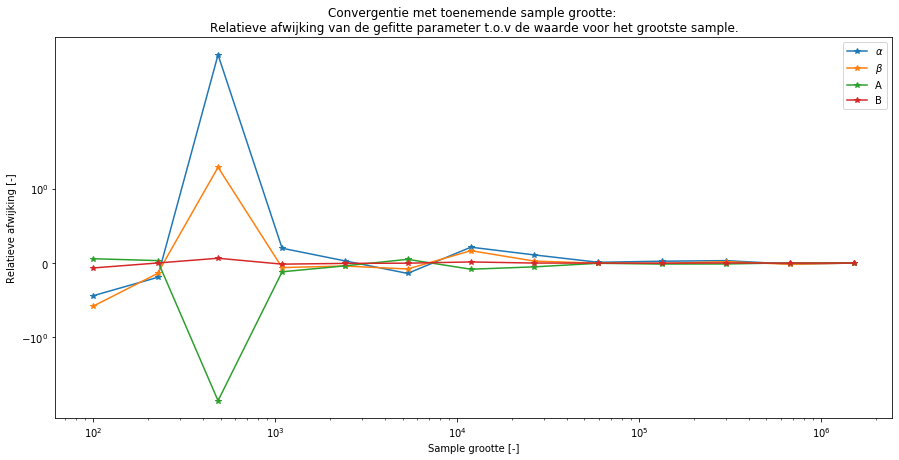

In [155]:
plt.plot(np.array(sizes_r)**2.,np.array([(par[0]-params_r[-1][0])/params_r[-1][0] for par in params_r]),'-*',label=r'$\alpha$')
plt.plot(np.array(sizes_r)**2.,np.array([(par[1]-params_r[-1][1])/params_r[-1][1] for par in params_r]),'-*',label=r'$\beta$')
plt.plot(np.array(sizes_r)**2.,np.array([(par[2]-params_r[-1][2])/params_r[-1][2] for par in params_r]),'-*',label=r'A')
plt.plot(np.array(sizes_r)**2.,np.array([(par[3]-params_r[-1][3])/params_r[-1][3] for par in params_r]),'-*',label=r'B')
fig=plt.gcf()
fig.set_size_inches(15,7)
ax=plt.gca()
#ax.set_ylim(-1,1)
plt.yscale('symlog')
plt.xscale('log')
ax.set_title('Convergentie met toenemende sample grootte: \nRelatieve afwijking van de gefitte parameter t.o.v de waarde voor het grootste sample.')
ax.set_xlabel('Sample grootte [-]')
ax.set_ylabel('Relatieve afwijking [-]')
lgnd=ax.legend()

In [188]:
size = 50000
estimates = []
with open('effective_beta.txt','w') as effbeta:
    for sgvval in np.array(list(range(-4,23)))*0.5:
        result=effective_beta_random(sgvval, size)        
        est2=result[0]
        estimates.append((sgvval,est2))
        effbeta.write("%15.5e, %15.5e, %15.5e, %15.5e, %15.5e\n"%(sgvval, est2[0], est2[1], est2[2], est2[3]))
        sys.stdout.write("%15.5e, %15.5e, %15.5e, %15.5e, %15.5e\n"%(sgvval, est2[0], est2[1], est2[2], est2[3]))

   -2.00000e+00,     1.10415e+03,     1.37150e+03,    -1.86450e+04,     1.94955e+04
   -1.50000e+00,     4.96705e+02,     5.71145e+02,    -5.60231e+03,     4.63350e+03
   -1.00000e+00,     1.71980e+02,     2.00879e+02,    -4.04425e+03,     4.87260e+03
   -5.00000e-01,     1.34855e+03,     1.49063e+03,    -1.51216e+04,     1.89936e+04
    0.00000e+00,     1.13069e+03,     1.35426e+03,    -1.46274e+04,     2.23459e+04
    5.00000e-01,     1.26160e+02,     1.18351e+02,    -3.32002e+03,     9.55881e+03
    1.00000e+00,     2.29539e+02,     2.09405e+02,    -5.40619e+03,     1.33511e+04
    1.50000e+00,     9.84059e+02,     1.36860e+03,    -1.56247e+04,     3.48243e+04
    2.00000e+00,     3.51011e+02,     3.64769e+02,    -8.55148e+03,     2.21077e+04
    2.50000e+00,     3.30153e+03,     2.83719e+03,    -4.30244e+04,     5.05852e+04
    3.00000e+00,     1.36019e+03,     1.59170e+03,    -2.49574e+04,     4.66439e+04
    3.50000e+00,     2.02039e+02,     1.91907e+02,    -5.58255e+03,     2.24

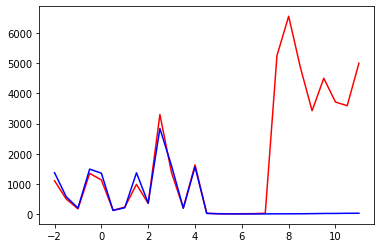

In [190]:
plt.plot(np.array([est[0] for est in estimates]),np.array([est[1][0] for est in estimates]),'r-')
plt.plot(np.array([est[0] for est in estimates]),np.array([est[1][1] for est in estimates]),'b-')

In [198]:
yy = []
pct_025 = []
pct_975 = []
pct_500 = []
mean = []

for est in estimates:
    yy.append(est[0])
    alpha_fit=est[1][0]
    beta_fit=est[1][1]
    AA_fit=est[1][2]
    BB_fit=est[1][3]
    pct_025.append(beta_reverse(alpha_fit,beta_fit,AA_fit,BB_fit,0.025))
    pct_500.append(beta_reverse(alpha_fit,beta_fit,AA_fit,BB_fit,0.500))
    pct_975.append(beta_reverse(alpha_fit,beta_fit,AA_fit,BB_fit,0.975))
    mean.append(alpha_fit/(alpha_fit+beta_fit)*(BB_fit-AA_fit)+AA_fit)
np_yy = np.array(yy)
np_pct025 = np.array(pct_025)
np_pct500 = np.array(pct_500)
np_pct975 = np.array(pct_975)
np_mean = np.array(mean)


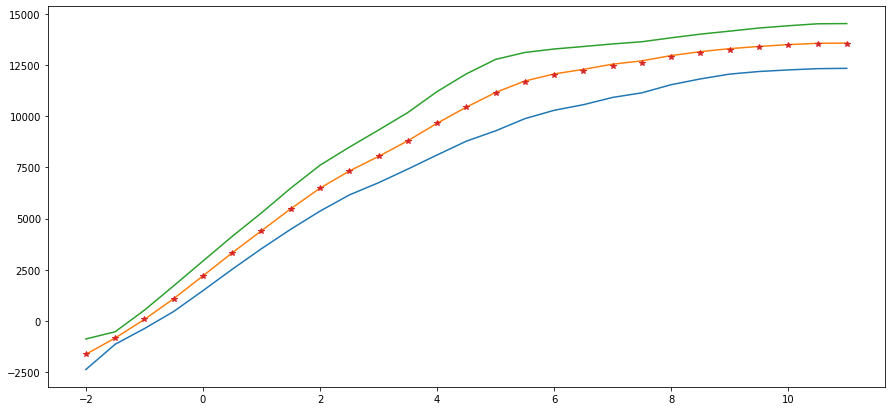

In [199]:
plt.plot(np_yy,np_pct025,'-')
plt.plot(np_yy,np_pct500,'-')
plt.plot(np_yy,np_pct975,'-')
plt.plot(np_yy,np_mean,'*')
fig=plt.gcf()
fig.set_size_inches(15,7)


(0, 20000)

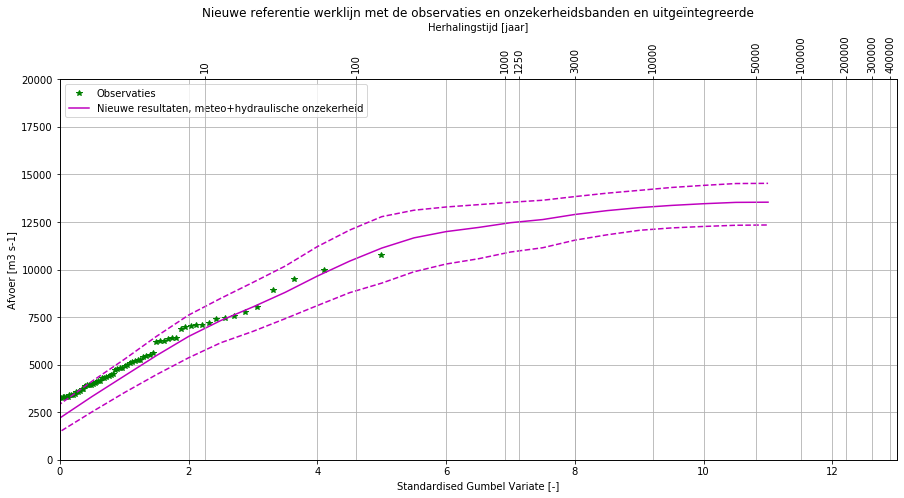

In [217]:
#plot nieuw versus observations met 
# plt.plot(rijn_new['sgv'],rijn_new['mu'],'b-',label="Nieuwe resultaten, meteo onzekerheid")
# plt.plot(rijn_new['sgv'],rijn_new['mu']+1.96*rijn_new['sigma'],'b--')
# plt.plot(rijn_new['sgv'],rijn_new['mu']-1.96*rijn_new['sigma'],'b--')
# plt.plot(rijn_new['uitintegratie']['sgv'],rijn_new['uitintegratie']['levels'],'k-',label="Uitintegratie meteo onzekerheid")
plt.plot(rijn_obs['sgv'],regression_2018(rijn_obs['mu']),'g*',label="Observaties")
plt.plot(np_yy,np_mean,'m-',label='Nieuwe resultaten, meteo+hydraulische onzekerheid')
plt.plot(np_yy,np_pct025,'m--')
plt.plot(np_yy,np_pct975,'m--')

ax=plt.gca()
ax.set_xlim(0,13)
fig=plt.gcf()
fig.set_size_inches(15,7)
lgnd = ax.legend(loc="upper left")
add_gum_axis(Tretlist,ax)
ti=ax.set_title('Nieuwe referentie werklijn met de observaties en onzekerheidsbanden en uitgeïntegreerde')
ax.set_ylim(0,20000)

In [1]:
import pygraphviz as pgv
from IPython.display import Image

def draw(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

g1 = """digraph top {
   a -> b -> c;
}"""
draw(g1)

ModuleNotFoundError: No module named 'pygraphviz'